# cuda:6

In [2]:
import sys
sys.path.insert(1,'/home/bwhiteak/ChaosESN/ESN_utils/')

import numpy as np
import torch
import rc_tools as rct
import rc_analysis as rca
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.optimize import fsolve
from scipy.signal import argrelextrema
import warnings
import time

import pdb

from skopt.space import Real,Integer
from skopt.utils import use_named_args
from skopt import gp_minimize

from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D

import warnings
warnings.filterwarnings("ignore")

#from jupyterthemes import jtplot
#jtplot.style(theme='solarizedd', context='notebook',
#             ticks=True, grid=False)

np.random.seed(11)
torch.set_printoptions(precision=10)
dtype = torch.float32 

print(f'Python: {sys.version}')
print(f'Numpy: {np.__version__}')
print(f'Torch: {torch.__version__}')

DEVICE = 'cuda:6'

FREERUN = 20
DT = .02

rho = 28.0
sigma = 10.0
beta = 8/3

def f(state, t):
    x,y,z = state
    return sigma*(y-x), x*(rho-z)-y, x*y - beta*z

state0 = [1.,1.,1.]
t = np.arange(0,300+FREERUN,DT)
states = odeint(f,state0,t)

log_z = np.log(states[:,2])

MU_X = np.mean(log_z)
signal = log_z-MU_X

M = signal.shape[0] - int(FREERUN/DT)
K = 1
L = 1
RF = .5
TEST = 1000
LEAD = 100
BURNIN = 100
REG = 1e-8
TRAINLENGTH = M-TEST


MINMAX = np.max(states[:TRAINLENGTH+TEST,2]) - \
         np.min(states[:TRAINLENGTH+TEST,2])
STD = np.std(states[:TRAINLENGTH+TEST,2])

BINS = 50

print(f'Signal length M={M}')
print(f'Normalizing value max-min id {MINMAX:.3f}')
print(f'Normalizing value max-min id {STD:.3f}')

Python: 3.8.12 (default, Oct 12 2021, 13:49:34) 
[GCC 7.5.0]
Numpy: 1.21.2
Torch: 1.10.0
Signal length M=15000
Normalizing value max-min id 46.872
Normalizing value max-min id 8.567


In [3]:
def get_weight_matricesGPU(k,n,l,ri,ro):
    win = torch.rand((n,k),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(ri)
    wfb = torch.zeros((n,l),dtype=dtype, device=torch.device(DEVICE))
    wout = torch.rand((l,n+k),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(ro)
    return win, wfb, wout

def set_vectorsGPU(n,l,r):
    x0 = torch.rand((n,1),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(r)
    y0 = torch.zeros((l,1),dtype=dtype, device=torch.device(DEVICE))
    return x0, y0

def update_res_stateGPU(wnet,xt,uxy,a,g):
    z = torch.matmul(wnet,uxy)
    return torch.mul(xt,1-a) + torch.mul(torch.tanh(z),a*g)

def predict_yGPU(wout,xu):
    return torch.matmul(wout, xu)

def get_matrixGPU(n,r,sr):
    A = (torch.rand((n,n),dtype=dtype,
                   device=torch.device(DEVICE))-.5)*r
    At = torch.transpose(A,0,1)
    D = torch.diag(torch.diag(A))   
    W = A + At - D
    eig = torch.eig(W, eigenvectors=False)
    wsr = torch.max(torch.abs(eig[0]))
    return W.div(wsr).mul(sr)

def resize_spaces(mn, mx, best, isAlpha=False):
    #pdb.set_trace()
    if(best.size==0):
        new_mn = np.max([0, mn - .5*mn])
        new_mx = 1.5*mx
    else:
        best_mn = np.min(best)
        best_mx = np.max(best)
        mn_bound = (best_mn-mn)/2
        mx_bound = (mx -best_mx)/2
        new_mn, new_mx = best_mn-mn_bound, best_mx+mx_bound
        print(f'\nBest mn:{best_mn:.3f}\t mn:{best_mx:.3f}')
        print(f'New bounds mn--mx: {mn_bound:.3f}--{mx_bound:.3f}')
    if(isAlpha):
        if(new_mx>1):
            new_mx = 1
    
    return new_mn, new_mx

In [4]:
import json
from json import JSONEncoder

# numpy arrays cannot be written to json 
# convert to list
class NumpyArrayEncoder(JSONEncoder):
    def default(self,obj):
        if isinstance(obj,np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self,obj)
    

In [5]:
#min_a, max_a = .55, .7
#min_sr, max_sr = .8, 1.
#min_g, max_g = 1.4, 1.7
#min_ri, max_ri = .001, 4.
#min_rr, max_rr = .001, 4.
min_a, max_a = .7, 1.
min_sr, max_sr = 1.5, 3.
min_g, max_g = .001, 2.
min_ri, max_ri = .3, 3.5
min_rr, max_rr = .4, 4.

space = [Real(min_a, max_a, name='a'),
         Real(min_sr, max_sr, name='sr'),
         Real(min_ri, max_ri, name='ri'),
         Real(min_rr, max_rr, name='rr')
        ]

@use_named_args(space)
def loop(a=1.0,sr=1.0,ri=1.0,rr=1.0):
    start = time.time()
    amp = 1.
    global running_error, s, counter, signal, N, ref, rn, \
           alphas, rhos, gammas, inScales, resScales, dict_model, \
           model_counter, error_per_N, error_over_N, best_N_model
    
    ut = torch.zeros((1,1),dtype=dtype,
                     device=torch.device(DEVICE))
    tp = torch.zeros((1,1),dtype=dtype,
                     device=torch.device(DEVICE))
    
    Wres = get_matrixGPU(N,rr,sr)
    Win, Wfb, Wout = get_weight_matricesGPU(K,N,L,ri,RF)
    Wnet = torch.cat((Win,Wres,Wfb),1)
    xt, yt = set_vectorsGPU(N,L,rr)

    states = torch.zeros((TRAINLENGTH, N+K),dtype=dtype,
                         device=DEVICE)
    targets = torch.zeros((TRAINLENGTH),dtype=dtype, device=DEVICE)
    for i in range(TRAINLENGTH):
        ut[0,0] = s[i]
        tp[0,0] = s[i+1]
        targets[i] = s[i+1]
        uxy = torch.cat((ut,xt,yt),0)
        xt1 = update_res_stateGPU(Wnet,xt,uxy,a,amp)
        xu = torch.transpose(torch.cat((xt1,ut),0),0,1).to(DEVICE)
        states[i,:] = xu[0,:]
        xt, yt = xt1, tp 

    state = states.detach().cpu().numpy()

    torch.cuda.synchronize()
    wout = rct.get_trained_weights(state[BURNIN:],
                                   signal[BURNIN+1:TRAINLENGTH+1],
                                   REG)
    Wout = torch.from_numpy(wout.reshape(L,N+K)).type(dtype).cuda(DEVICE)
    torch.cuda.synchronize()

    predictions = torch.zeros((M+int(FREERUN/DT),1),
                              dtype=dtype,
                              device=torch.device(DEVICE))

    xt, yt = set_vectorsGPU(N,L,rr)
    ut.fill_(0.0)
    for i in range(M+int(FREERUN/DT)):
        if(i < TRAINLENGTH):
            ut[0,0] = s[i]
        else:
            ut = yt
        uxy = torch.cat((ut,xt,yt),0)
        xt1 = update_res_stateGPU(Wnet,xt,uxy,a,amp)
        xu = torch.cat((xt1,ut),0).to(DEVICE)
        yt1 = predict_yGPU(Wout,xu)
        predictions[i] = yt1[0,0]
        xt, yt = xt1, yt1

    yHat_GPU = predictions.detach().cpu().numpy()
    
    nrmse = 1000.0
    try:
        nrmse = rca.NRMSE(np.exp(signal[TRAINLENGTH:TRAINLENGTH+TEST]+MU_X),
                          np.exp(yHat_GPU[TRAINLENGTH:TRAINLENGTH+TEST]+MU_X),
                          MINMAX) 
    except:
        pass
    
    
    av = signal[TRAINLENGTH:TRAINLENGTH+TEST].reshape(TEST,1)
    bv = np.squeeze(yHat_GPU[TRAINLENGTH:TRAINLENGTH+TEST]).reshape(TEST,1)
    num = np.squeeze(np.dot(av.T,bv))
    den = np.linalg.norm(av)*np.linalg.norm(bv)
    cosine_similarity = num/den
    cosine_distance = 1 - cosine_similarity
    dist = cosine_distance
    
    loss = nrmse + dist
    if(np.isnan(loss) or (np.isinf(loss) or (loss > 1000.0))):
        loss = 1000
    
    if((loss < running_error) and (nrmse < .15)):
        print(f'Dist {dist:3f}')
        running_error = loss
        wnet = Wnet.detach().cpu().numpy()
        currentParams = np.array([a,sr,amp,ri,rr,loss])
        if(error_over_N > running_error):
            print('\n\nNew N best!!!!!!!!!!!!\n\n')
            error_over_N = running_error  #set the lowest error
            best_N_model = [N,ref,rn,counter]
            states_dict = {'States': state}
            with open(f'Dicts/States/states_Lz_{N}.json', 'w') as fp:
                json.dump(states_dict, fp, cls=NumpyArrayEncoder)
            dict_model[str(N)] = {'Wnet': wnet,
                                  'Wout': wout,
                                  'Preds': yHat_GPU,
                                  'Params': currentParams}
            print(best_N_model)
        
        alphas.append(a)
        rhos.append(sr)
        gammas.append(amp)
        inScales.append(ri)
        resScales.append(rr)
        
        fig = plt.figure(figsize=(10,8))
        ax1 = plt.subplot(111)
        ax1.plot(signal[TRAINLENGTH-LEAD:], label='Target')
        ax1.plot(yHat_GPU[TRAINLENGTH-LEAD:], label='GPU')
        ax1.axvline(LEAD,c='orange',linestyle='dashed')
        ax1.axvline(LEAD+TEST,c='r',linestyle='dashed')
        ax1.set_ylim(-4,4)
        ax1.legend()
        plt.show()
        plt.close()
        model_counter += 1
        error_per_N.append(nrmse)
        
        print(f' Iter={counter} a={a:.3f} sr={sr:.3f} amp={amp:.3f}',
              f' ri={ri:.3f} rr={rr:.3f} loss={loss:3f} nrmse={nrmse:3f} CD {dist:3f}')
    ####### Running info ##############################
    print(f'Iter: {counter} #### Time {(time.time()-start):.2f}',
          f' NRMSE {nrmse:.3f} CD {dist:.3f}')
    ###### Store this run #############################
    dict_counters[str(N)] = {'numModels': model_counter,
                             'meanError': np.mean(np.array(error_per_N),axis=0).tolist(),
                             'varError' : np.var(np.array(error_per_N),axis=0).tolist()}
    counter += 1
    return loss

********** Size28 ref 0 -- Run 0 ***********
Iter: 0 #### Time 7.20  NRMSE 1000.000 CD nan
Iter: 1 #### Time 4.13  NRMSE 0.255 CD 0.922
Iter: 2 #### Time 4.05  NRMSE 1000.000 CD nan
Iter: 3 #### Time 4.06  NRMSE 0.203 CD 1.005
Iter: 4 #### Time 4.07  NRMSE 0.197 CD 0.978
Iter: 5 #### Time 4.06  NRMSE 1000.000 CD nan
Iter: 6 #### Time 4.08  NRMSE 1000.000 CD nan
Iter: 7 #### Time 4.07  NRMSE 0.237 CD 0.979
Iter: 8 #### Time 4.18  NRMSE 0.194 CD 0.973
Iter: 9 #### Time 4.07  NRMSE 0.191 CD 0.568
Iter: 10 #### Time 4.05  NRMSE 0.514 CD 0.995
Iter: 11 #### Time 4.06  NRMSE 1000.000 CD nan
Iter: 12 #### Time 4.05  NRMSE 1000.000 CD nan
Iter: 13 #### Time 4.05  NRMSE 0.186 CD 0.961
Iter: 14 #### Time 4.06  NRMSE 1000.000 CD nan
Iter: 15 #### Time 4.06  NRMSE 116291946419907.672 CD 0.994
Iter: 16 #### Time 4.05  NRMSE 1000.000 CD nan
Iter: 17 #### Time 4.07  NRMSE 3.163 CD 0.962
Iter: 18 #### Time 4.05  NRMSE 0.252 CD 0.851
Iter: 19 #### Time 4.04  NRMSE 0.278 CD 1.229
Iter: 20 #### Time 4.08

Iter: 70 #### Time 4.15  NRMSE 0.179 CD 0.814
Iter: 71 #### Time 4.14  NRMSE 1000.000 CD nan
Iter: 72 #### Time 4.17  NRMSE 0.281 CD 1.179
Iter: 73 #### Time 4.18  NRMSE 0.249 CD 1.055
Iter: 74 #### Time 4.17  NRMSE 0.193 CD 0.969
Iter: 75 #### Time 4.17  NRMSE 0.197 CD 0.982
Iter: 76 #### Time 4.32  NRMSE 1000.000 CD nan
Iter: 77 #### Time 4.16  NRMSE 0.189 CD 0.972
Iter: 78 #### Time 4.16  NRMSE 1000.000 CD nan
Iter: 79 #### Time 4.35  NRMSE 0.527 CD 0.993
Iter: 80 #### Time 4.46  NRMSE 0.241 CD 1.106
Iter: 81 #### Time 4.22  NRMSE 0.182 CD 0.812
Iter: 82 #### Time 4.18  NRMSE 493141110624405618688.000 CD 1.000
Iter: 83 #### Time 4.23  NRMSE 1000.000 CD nan
Iter: 84 #### Time 4.20  NRMSE 0.205 CD 0.971
Iter: 85 #### Time 4.24  NRMSE 0.240 CD 0.930
Iter: 86 #### Time 4.21  NRMSE 0.151 CD 0.427
Iter: 87 #### Time 4.24  NRMSE 0.245 CD 1.070
Iter: 88 #### Time 4.22  NRMSE 0.198 CD 0.980
Iter: 89 #### Time 4.22  NRMSE 1000.000 CD nan
Iter: 90 #### Time 4.21  NRMSE 0.224 CD 0.896
Iter: 91 

Iter: 38 #### Time 4.32  NRMSE 0.214 CD 0.915
Iter: 39 #### Time 4.22  NRMSE 0.182 CD 0.906
Iter: 40 #### Time 4.17  NRMSE 1000.000 CD nan
Iter: 41 #### Time 4.20  NRMSE 0.189 CD 0.576
Iter: 42 #### Time 4.14  NRMSE 0.195 CD 0.970
Iter: 43 #### Time 4.22  NRMSE 0.192 CD 0.960
Iter: 44 #### Time 4.28  NRMSE 0.195 CD 0.985
Iter: 45 #### Time 4.24  NRMSE 0.191 CD 0.983
Iter: 46 #### Time 4.28  NRMSE 1000.000 CD nan
Iter: 47 #### Time 4.20  NRMSE 1000.000 CD nan
Iter: 48 #### Time 4.20  NRMSE 1000.000 CD nan
Iter: 49 #### Time 4.23  NRMSE 0.229 CD 0.878
Iter: 50 #### Time 4.37  NRMSE 1000.000 CD nan
Iter: 51 #### Time 4.23  NRMSE 1000.000 CD nan
Iter: 52 #### Time 4.26  NRMSE 1000.000 CD nan
Iter: 53 #### Time 4.30  NRMSE 1000.000 CD nan
Iter: 54 #### Time 4.31  NRMSE 0.195 CD 0.968
Iter: 55 #### Time 4.30  NRMSE 2.239 CD 0.926
Iter: 56 #### Time 4.24  NRMSE 0.255 CD 1.117
Iter: 57 #### Time 4.36  NRMSE 0.194 CD 0.967
Iter: 58 #### Time 4.25  NRMSE 1000.000 CD nan
Iter: 59 #### Time 4.22  

Iter: 3 #### Time 5.04  NRMSE 0.201 CD 0.945
Iter: 4 #### Time 4.46  NRMSE 0.227 CD 1.028
Iter: 5 #### Time 4.62  NRMSE 1000.000 CD 1.007
Iter: 6 #### Time 4.64  NRMSE 0.203 CD 1.020
Iter: 7 #### Time 4.52  NRMSE 0.226 CD 0.942
Iter: 8 #### Time 4.39  NRMSE 0.189 CD 0.975
Iter: 9 #### Time 4.38  NRMSE 0.196 CD 0.801
Iter: 10 #### Time 4.48  NRMSE 1000.000 CD nan
Iter: 11 #### Time 4.40  NRMSE 0.197 CD 0.972
Iter: 12 #### Time 4.42  NRMSE 0.226 CD 0.774
Iter: 13 #### Time 4.43  NRMSE 1000.000 CD 1.001
Iter: 14 #### Time 4.53  NRMSE 0.253 CD 1.092
Iter: 15 #### Time 4.72  NRMSE 1000.000 CD nan
Iter: 16 #### Time 4.58  NRMSE 0.517 CD 0.994
Iter: 17 #### Time 4.40  NRMSE 0.252 CD 1.107
Iter: 18 #### Time 4.44  NRMSE 0.219 CD 0.835
Iter: 19 #### Time 4.46  NRMSE 0.200 CD 0.589
Iter: 20 #### Time 4.45  NRMSE 1000.000 CD nan
Iter: 21 #### Time 4.34  NRMSE 0.193 CD 0.862
Iter: 22 #### Time 4.49  NRMSE 432769825272405827386343424.000 CD 1.002
Iter: 23 #### Time 4.38  NRMSE 110530776891501643374

Iter: 73 #### Time 4.98  NRMSE 1000.000 CD nan
Iter: 74 #### Time 4.41  NRMSE 0.198 CD 0.978
Iter: 75 #### Time 4.55  NRMSE 0.214 CD 0.847
Iter: 76 #### Time 4.64  NRMSE 1000.000 CD nan
Iter: 77 #### Time 4.47  NRMSE 0.206 CD 1.009
Iter: 78 #### Time 4.94  NRMSE 0.219 CD 0.795
Iter: 79 #### Time 4.24  NRMSE 0.186 CD 0.923
Iter: 80 #### Time 4.98  NRMSE 0.187 CD 0.840
Iter: 81 #### Time 4.42  NRMSE 0.278 CD 1.209
Iter: 82 #### Time 4.34  NRMSE 1000.000 CD nan
Iter: 83 #### Time 4.46  NRMSE 0.216 CD 0.932
Iter: 84 #### Time 4.32  NRMSE 0.199 CD 0.869
Iter: 85 #### Time 4.82  NRMSE 0.272 CD 1.151
Iter: 86 #### Time 4.51  NRMSE 0.205 CD 1.012
Iter: 87 #### Time 4.23  NRMSE 0.189 CD 0.945
Iter: 88 #### Time 4.17  NRMSE 0.235 CD 0.898
Iter: 89 #### Time 4.21  NRMSE 0.212 CD 0.960
Iter: 90 #### Time 4.18  NRMSE 0.182 CD 0.822
Iter: 91 #### Time 4.23  NRMSE 0.217 CD 0.919
Iter: 92 #### Time 4.34  NRMSE 1000.000 CD nan
Iter: 93 #### Time 4.18  NRMSE 0.173 CD 0.602
Iter: 94 #### Time 4.12  NRMSE

Iter: 41 #### Time 4.28  NRMSE 1000.000 CD nan
Iter: 42 #### Time 4.43  NRMSE 1000.000 CD nan
Iter: 43 #### Time 4.28  NRMSE 13.624 CD 1.009
Iter: 44 #### Time 4.66  NRMSE 0.184 CD 0.951
Iter: 45 #### Time 4.45  NRMSE 0.219 CD 0.867
Iter: 46 #### Time 4.65  NRMSE 1000.000 CD nan
Iter: 47 #### Time 4.37  NRMSE 0.189 CD 0.895
Iter: 48 #### Time 4.47  NRMSE 1000.000 CD nan
Iter: 49 #### Time 4.79  NRMSE 0.475 CD 1.046
Iter: 50 #### Time 4.35  NRMSE 1000.000 CD nan
Iter: 51 #### Time 4.73  NRMSE 1000.000 CD 1.002
Iter: 52 #### Time 4.61  NRMSE 0.209 CD 0.904
Iter: 53 #### Time 4.55  NRMSE 0.242 CD 1.111
Iter: 54 #### Time 4.46  NRMSE 0.185 CD 0.901
Iter: 55 #### Time 4.35  NRMSE 0.489 CD 0.984
Iter: 56 #### Time 4.45  NRMSE 0.163 CD 0.456
Iter: 57 #### Time 4.45  NRMSE 0.191 CD 0.955
Iter: 58 #### Time 4.34  NRMSE 1000.000 CD nan
Iter: 59 #### Time 4.41  NRMSE 1000.000 CD nan
Iter: 60 #### Time 4.16  NRMSE 416.422 CD 0.998
Iter: 61 #### Time 4.65  NRMSE 1000.000 CD 1.000
Iter: 62 #### Time

Iter: 6 #### Time 4.32  NRMSE 0.206 CD 1.006
Iter: 7 #### Time 4.52  NRMSE 0.183 CD 0.958
Iter: 8 #### Time 4.29  NRMSE 0.206 CD 0.813
Iter: 9 #### Time 4.75  NRMSE 0.224 CD 0.982
Iter: 10 #### Time 4.43  NRMSE 0.242 CD 1.107
Iter: 11 #### Time 4.82  NRMSE 1000.000 CD nan
Iter: 12 #### Time 4.25  NRMSE 1000.000 CD nan
Iter: 13 #### Time 4.35  NRMSE 0.241 CD 0.966
Iter: 14 #### Time 4.42  NRMSE 1000.000 CD nan
Iter: 15 #### Time 4.23  NRMSE 0.209 CD 0.678
Iter: 16 #### Time 4.31  NRMSE 1000.000 CD nan
Iter: 17 #### Time 4.21  NRMSE 1000.000 CD nan
Iter: 18 #### Time 4.41  NRMSE 0.263 CD 1.021
Iter: 19 #### Time 4.52  NRMSE 1000.000 CD nan
Iter: 20 #### Time 4.46  NRMSE 0.199 CD 0.997
Iter: 21 #### Time 4.77  NRMSE 0.186 CD 0.997
Iter: 22 #### Time 4.24  NRMSE 0.229 CD 1.063
Iter: 23 #### Time 4.40  NRMSE 1000.000 CD nan
Iter: 24 #### Time 4.38  NRMSE 1000.000 CD nan
Iter: 25 #### Time 4.50  NRMSE 0.198 CD 0.982
Iter: 26 #### Time 4.52  NRMSE 0.158 CD 0.436
Iter: 27 #### Time 4.37  NRMSE

Iter: 78 #### Time 4.33  NRMSE 0.200 CD 0.589
Iter: 79 #### Time 4.34  NRMSE 0.452 CD 0.985
Iter: 80 #### Time 4.29  NRMSE 0.186 CD 0.965
Iter: 81 #### Time 4.37  NRMSE 0.208 CD 0.979
Iter: 82 #### Time 4.41  NRMSE 1000.000 CD nan
Iter: 83 #### Time 4.16  NRMSE 27.666 CD 1.003
Iter: 84 #### Time 4.53  NRMSE 6.811 CD 1.000
Iter: 85 #### Time 4.37  NRMSE 0.490 CD 1.002
Iter: 86 #### Time 4.19  NRMSE 1000.000 CD nan
Iter: 87 #### Time 4.42  NRMSE 0.229 CD 1.001
Iter: 88 #### Time 4.25  NRMSE 1000.000 CD nan
Iter: 89 #### Time 4.32  NRMSE 0.186 CD 0.954
Iter: 90 #### Time 4.61  NRMSE 0.194 CD 0.895
Iter: 91 #### Time 4.18  NRMSE 0.203 CD 0.979
Iter: 92 #### Time 4.42  NRMSE 1000.000 CD nan
Iter: 93 #### Time 4.34  NRMSE 0.254 CD 1.022
Iter: 94 #### Time 4.25  NRMSE 0.211 CD 0.975
Iter: 95 #### Time 4.38  NRMSE 0.199 CD 0.985
Iter: 96 #### Time 4.27  NRMSE 0.195 CD 0.963
Iter: 97 #### Time 4.29  NRMSE 0.184 CD 0.953
Iter: 98 #### Time 4.38  NRMSE 0.239 CD 1.090
Iter: 99 #### Time 4.19  NRMS

Iter: 46 #### Time 4.64  NRMSE 0.192 CD 0.964
Iter: 47 #### Time 4.73  NRMSE 1000.000 CD nan
Iter: 48 #### Time 4.50  NRMSE 1000.000 CD nan
Iter: 49 #### Time 4.56  NRMSE 868.419 CD 1.010
Iter: 50 #### Time 4.85  NRMSE 0.233 CD 0.904
Iter: 51 #### Time 4.45  NRMSE 0.215 CD 0.718
Iter: 52 #### Time 6.00  NRMSE 0.200 CD 0.975
Iter: 53 #### Time 5.29  NRMSE 0.176 CD 0.859
Iter: 54 #### Time 4.57  NRMSE 0.191 CD 0.933
Iter: 55 #### Time 6.31  NRMSE 0.184 CD 0.965
Iter: 56 #### Time 4.75  NRMSE 1000.000 CD nan
Iter: 57 #### Time 4.51  NRMSE 89747065043819407679687258800128.000 CD 0.998
Iter: 58 #### Time 4.30  NRMSE 1000.000 CD nan
Iter: 59 #### Time 4.50  NRMSE 0.232 CD 0.903
Iter: 60 #### Time 4.53  NRMSE 0.485 CD 1.011
Iter: 61 #### Time 4.71  NRMSE 0.239 CD 1.059
Iter: 62 #### Time 4.73  NRMSE 0.242 CD 0.967
Iter: 63 #### Time 4.78  NRMSE 1000.000 CD nan
Iter: 64 #### Time 5.32  NRMSE 0.453 CD 1.002
Iter: 65 #### Time 6.35  NRMSE 1000.000 CD nan
Iter: 66 #### Time 4.61  NRMSE 0.199 CD 0

Iter: 11 #### Time 5.98  NRMSE 1000.000 CD nan
Iter: 12 #### Time 6.44  NRMSE 1000.000 CD nan
Iter: 13 #### Time 5.21  NRMSE 0.257 CD 1.156
Iter: 14 #### Time 4.55  NRMSE 1000.000 CD nan
Iter: 15 #### Time 4.42  NRMSE 0.187 CD 0.932
Iter: 16 #### Time 4.90  NRMSE 0.234 CD 0.879
Iter: 17 #### Time 4.68  NRMSE 0.269 CD 1.157
Iter: 18 #### Time 4.39  NRMSE 0.217 CD 0.931
Iter: 19 #### Time 4.63  NRMSE 0.387 CD 0.992
Iter: 20 #### Time 4.75  NRMSE 0.257 CD 1.035
Iter: 21 #### Time 6.09  NRMSE 0.214 CD 0.962
Iter: 22 #### Time 5.24  NRMSE 1000.000 CD nan
Iter: 23 #### Time 4.66  NRMSE 1000.000 CD nan
Iter: 24 #### Time 4.78  NRMSE 0.230 CD 0.805
Iter: 25 #### Time 4.75  NRMSE 0.163 CD 0.410
Iter: 26 #### Time 5.96  NRMSE 3822265224.518 CD 1.000
Iter: 27 #### Time 4.60  NRMSE 1000.000 CD nan
Iter: 28 #### Time 4.61  NRMSE 0.204 CD 0.975
Iter: 29 #### Time 4.59  NRMSE 0.245 CD 0.995
Iter: 30 #### Time 4.69  NRMSE 0.472 CD 0.996
Iter: 31 #### Time 4.36  NRMSE 0.362 CD 0.908
Iter: 32 #### Time 

Iter: 84 #### Time 5.58  NRMSE 0.180 CD 0.938
Iter: 85 #### Time 6.37  NRMSE 0.205 CD 1.024
Iter: 86 #### Time 4.59  NRMSE 1000.000 CD nan
Iter: 87 #### Time 4.75  NRMSE 1000.000 CD nan
Iter: 88 #### Time 4.62  NRMSE 1000.000 CD nan
Iter: 89 #### Time 4.63  NRMSE 0.228 CD 0.876
Iter: 90 #### Time 4.89  NRMSE 0.178 CD 0.795
Iter: 91 #### Time 5.07  NRMSE 0.270 CD 1.138
Iter: 92 #### Time 5.06  NRMSE 0.198 CD 0.965
Iter: 93 #### Time 4.62  NRMSE 0.214 CD 0.987
Iter: 94 #### Time 4.34  NRMSE 0.230 CD 0.963
Iter: 95 #### Time 4.83  NRMSE 0.227 CD 0.881
Iter: 96 #### Time 4.63  NRMSE 1000.000 CD nan
Iter: 97 #### Time 4.35  NRMSE 0.212 CD 0.866
Iter: 98 #### Time 4.63  NRMSE 0.233 CD 1.049
Iter: 99 #### Time 4.46  NRMSE 1000.000 CD nan
End Run 1 Time 465.719

Best result = 0.5971873737667439
a = 0.8838365776738129
sr = 2.046657331735949
amp = 1.904435582748127
ri = 1.6444112114979101
********** Size28 ref 3 -- Run 2 ***********
Iter: 0 #### Time 4.42  NRMSE 1000.000 CD nan
Iter: 1 #### Time

Iter: 51 #### Time 4.54  NRMSE 1000.000 CD nan
Iter: 52 #### Time 4.73  NRMSE 0.181 CD 0.925
Iter: 53 #### Time 4.66  NRMSE 0.196 CD 0.977
Iter: 54 #### Time 4.47  NRMSE 0.240 CD 0.986
Iter: 55 #### Time 4.35  NRMSE 11.551 CD 1.007
Iter: 56 #### Time 4.55  NRMSE 0.238 CD 0.815
Iter: 57 #### Time 4.84  NRMSE 1000.000 CD nan
Iter: 58 #### Time 4.37  NRMSE 1000.000 CD 0.995
Iter: 59 #### Time 4.46  NRMSE 1000.000 CD nan
Iter: 60 #### Time 4.87  NRMSE 1000.000 CD nan
Iter: 61 #### Time 4.61  NRMSE 1000.000 CD nan
Iter: 62 #### Time 4.56  NRMSE 1000.000 CD nan
Iter: 63 #### Time 4.54  NRMSE 1000.000 CD nan
Iter: 64 #### Time 4.40  NRMSE 0.243 CD 1.021
Iter: 65 #### Time 4.64  NRMSE 0.172 CD 0.524
Iter: 66 #### Time 4.72  NRMSE 0.231 CD 0.892
Iter: 67 #### Time 4.60  NRMSE 1000.000 CD nan
Iter: 68 #### Time 4.55  NRMSE 36235726910032756918567047266304.000 CD 0.999
Iter: 69 #### Time 4.44  NRMSE 0.255 CD 1.065
Iter: 70 #### Time 4.48  NRMSE 0.183 CD 0.853
Iter: 71 #### Time 4.63  NRMSE 1000.0

Iter: 15 #### Time 4.56  NRMSE 0.246 CD 1.026
Iter: 16 #### Time 4.51  NRMSE 0.187 CD 0.970
Iter: 17 #### Time 4.73  NRMSE 1000.000 CD nan
Iter: 18 #### Time 5.26  NRMSE 0.266 CD 1.003
Iter: 19 #### Time 4.42  NRMSE 1000.000 CD nan
Iter: 20 #### Time 4.89  NRMSE 1019157315.591 CD 1.096
Iter: 21 #### Time 4.66  NRMSE 1000.000 CD nan
Iter: 22 #### Time 4.51  NRMSE 0.237 CD 1.071
Iter: 23 #### Time 4.64  NRMSE 1000.000 CD nan
Iter: 24 #### Time 4.64  NRMSE 0.180 CD 0.620
Iter: 25 #### Time 5.26  NRMSE 0.232 CD 0.889
Iter: 26 #### Time 4.86  NRMSE 1000.000 CD nan
Iter: 27 #### Time 4.62  NRMSE 1000.000 CD nan
Iter: 28 #### Time 5.07  NRMSE 0.260 CD 1.101
Iter: 29 #### Time 6.50  NRMSE 0.194 CD 0.970
Iter: 30 #### Time 5.07  NRMSE 0.339 CD 0.991
Iter: 31 #### Time 4.81  NRMSE 0.263 CD 0.933
Iter: 32 #### Time 4.47  NRMSE 1000.000 CD nan
Iter: 33 #### Time 4.54  NRMSE 0.191 CD 0.605
Iter: 34 #### Time 4.62  NRMSE 0.231 CD 0.928
Iter: 35 #### Time 4.63  NRMSE 0.227 CD 0.930
Iter: 36 #### Time

Iter: 86 #### Time 4.49  NRMSE 1000.000 CD nan
Iter: 87 #### Time 4.69  NRMSE 0.362 CD 1.019
Iter: 88 #### Time 4.47  NRMSE 0.223 CD 0.985
Iter: 89 #### Time 4.39  NRMSE 0.204 CD 0.665
Iter: 90 #### Time 4.50  NRMSE 0.182 CD 0.855
Iter: 91 #### Time 4.50  NRMSE 0.183 CD 0.914
Iter: 92 #### Time 4.35  NRMSE 0.191 CD 0.971
Iter: 93 #### Time 4.55  NRMSE 0.197 CD 0.961
Iter: 94 #### Time 4.69  NRMSE 156983934958378118283264.000 CD 1.001
Iter: 95 #### Time 4.38  NRMSE 0.244 CD 0.849
Iter: 96 #### Time 4.55  NRMSE 0.202 CD 1.002
Iter: 97 #### Time 4.47  NRMSE 0.274 CD 0.976
Iter: 98 #### Time 5.45  NRMSE 1000.000 CD nan
Iter: 99 #### Time 5.57  NRMSE 0.189 CD 1.013
End Run 1 Time 500.831

Best result = 0.6600750405824614
a = 0.7710255456889693
sr = 2.126240771786158
amp = 0.8713560302108505
ri = 1.229599584118446
********** Size28 ref 4 -- Run 2 ***********
Iter: 0 #### Time 4.60  NRMSE 0.224 CD 0.646
Iter: 1 #### Time 4.77  NRMSE 0.493 CD 0.987
Iter: 2 #### Time 4.42  NRMSE 0.240 CD 1.110


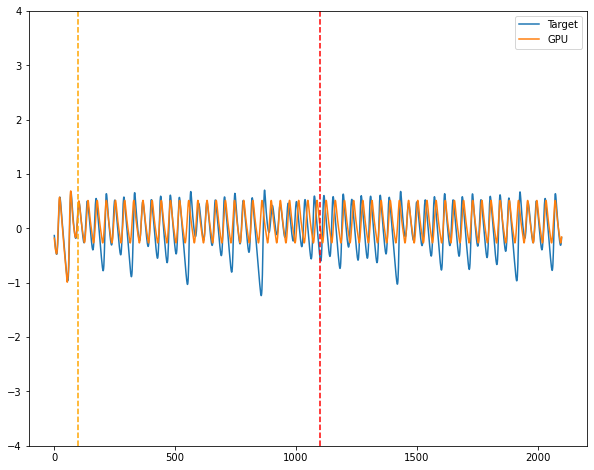

 Iter=24 a=0.785 sr=2.823 amp=1.000  ri=2.045 rr=3.381 loss=0.613484 nrmse=0.148856 CD 0.464628
Iter: 24 #### Time 6.41  NRMSE 0.149 CD 0.465
Iter: 25 #### Time 5.30  NRMSE 1000.000 CD nan
Iter: 26 #### Time 4.90  NRMSE 0.200 CD 0.577
Iter: 27 #### Time 4.42  NRMSE 0.232 CD 0.927
Iter: 28 #### Time 4.95  NRMSE 0.232 CD 0.785
Iter: 29 #### Time 4.42  NRMSE 1000.000 CD nan
Iter: 30 #### Time 4.60  NRMSE 0.193 CD 0.985
Iter: 31 #### Time 4.40  NRMSE 1000.000 CD nan
Iter: 32 #### Time 4.74  NRMSE 300.283 CD 0.967
Iter: 33 #### Time 4.61  NRMSE 1000.000 CD nan
Iter: 34 #### Time 4.75  NRMSE 1000.000 CD 0.999
Iter: 35 #### Time 4.71  NRMSE 0.192 CD 0.970
Iter: 36 #### Time 4.46  NRMSE 0.255 CD 1.233
Iter: 37 #### Time 4.64  NRMSE 1000.000 CD nan
Iter: 38 #### Time 4.53  NRMSE 0.254 CD 1.049
Iter: 39 #### Time 4.61  NRMSE 1000.000 CD nan
Iter: 40 #### Time 4.70  NRMSE 0.196 CD 0.991
Iter: 41 #### Time 5.65  NRMSE 0.289 CD 1.316
Iter: 42 #### Time 5.10  NRMSE 0.248 CD 1.096
Iter: 43 #### Time 

Iter: 94 #### Time 4.48  NRMSE 0.182 CD 0.912
Iter: 95 #### Time 5.62  NRMSE 0.429 CD 0.996
Iter: 96 #### Time 5.51  NRMSE 0.197 CD 0.627
Iter: 97 #### Time 4.44  NRMSE 1000.000 CD nan
Iter: 98 #### Time 4.56  NRMSE 1000.000 CD nan
Iter: 99 #### Time 4.56  NRMSE 0.207 CD 0.695
End Run 3 Time 499.223

Best result = 0.584568388640722
a = 0.7538640270217042
sr = 2.0491465778450895
amp = 1.0928520900916587
ri = 1.4954179333644695
********** Size28 ref 4 -- Run 4 ***********
Iter: 0 #### Time 4.69  NRMSE 0.181 CD 0.935
Iter: 1 #### Time 4.43  NRMSE 1000.000 CD nan
Iter: 2 #### Time 4.67  NRMSE 1000.000 CD nan
Iter: 3 #### Time 4.47  NRMSE 1000.000 CD nan
Iter: 4 #### Time 4.73  NRMSE 0.484 CD 1.012
Iter: 5 #### Time 4.43  NRMSE 0.520 CD 0.994
Iter: 6 #### Time 5.60  NRMSE 0.219 CD 0.892
Iter: 7 #### Time 6.11  NRMSE 1000.000 CD nan
Iter: 8 #### Time 5.01  NRMSE 1000.000 CD nan
Iter: 9 #### Time 4.70  NRMSE 0.209 CD 0.847
Iter: 10 #### Time 4.66  NRMSE 1000.000 CD 1.008
Iter: 11 #### Time 4.

Iter: 50 #### Time 6.27  NRMSE 1000.000 CD nan
Iter: 51 #### Time 5.69  NRMSE 0.198 CD 0.972
Iter: 52 #### Time 4.87  NRMSE 0.242 CD 0.947
Iter: 53 #### Time 5.06  NRMSE 0.208 CD 0.979
Iter: 54 #### Time 4.33  NRMSE 0.406 CD 0.943
Iter: 55 #### Time 4.51  NRMSE 0.202 CD 0.974
Iter: 56 #### Time 5.20  NRMSE 0.195 CD 0.981
Iter: 57 #### Time 4.49  NRMSE 0.273 CD 1.177
Iter: 58 #### Time 4.71  NRMSE 0.195 CD 0.884
Iter: 59 #### Time 4.45  NRMSE 0.171 CD 0.481
Iter: 60 #### Time 5.48  NRMSE 0.209 CD 0.876
Iter: 61 #### Time 4.54  NRMSE 0.240 CD 1.036
Iter: 62 #### Time 4.72  NRMSE 0.232 CD 1.055
Iter: 63 #### Time 4.90  NRMSE 0.272 CD 1.195
Iter: 64 #### Time 5.26  NRMSE 0.205 CD 1.046
Iter: 65 #### Time 5.11  NRMSE 0.230 CD 0.910
Iter: 66 #### Time 4.83  NRMSE 0.206 CD 1.016
Iter: 67 #### Time 4.49  NRMSE 1000.000 CD nan
Iter: 68 #### Time 5.01  NRMSE 0.237 CD 0.802
Iter: 69 #### Time 4.73  NRMSE 0.197 CD 0.978
Iter: 70 #### Time 5.13  NRMSE 0.193 CD 0.967
Iter: 71 #### Time 4.80  NRMSE 0

Iter: 18 #### Time 4.59  NRMSE 1000.000 CD nan
Iter: 19 #### Time 4.45  NRMSE 0.187 CD 0.962
Iter: 20 #### Time 4.54  NRMSE 1000.000 CD nan
Iter: 21 #### Time 4.58  NRMSE 0.227 CD 0.788
Iter: 22 #### Time 4.46  NRMSE 0.185 CD 0.978
Iter: 23 #### Time 4.37  NRMSE 0.201 CD 0.981
Iter: 24 #### Time 4.47  NRMSE 0.214 CD 0.979
Iter: 25 #### Time 4.49  NRMSE 0.402 CD 1.295
Iter: 26 #### Time 4.39  NRMSE 1000.000 CD nan
Iter: 27 #### Time 4.42  NRMSE 0.184 CD 0.890
Iter: 28 #### Time 4.52  NRMSE 1000.000 CD nan
Iter: 29 #### Time 4.44  NRMSE 0.300 CD 0.921
Iter: 30 #### Time 4.84  NRMSE 0.196 CD 0.977
Iter: 31 #### Time 4.33  NRMSE 0.199 CD 0.952
Iter: 32 #### Time 5.30  NRMSE 0.199 CD 0.957
Iter: 33 #### Time 4.45  NRMSE 0.202 CD 1.029
Iter: 34 #### Time 4.85  NRMSE 0.226 CD 1.059
Iter: 35 #### Time 4.48  NRMSE 0.421 CD 0.996
Iter: 36 #### Time 5.12  NRMSE 0.188 CD 0.939
Iter: 37 #### Time 4.95  NRMSE 0.208 CD 0.963
Iter: 38 #### Time 4.71  NRMSE 0.218 CD 0.979
Iter: 39 #### Time 5.26  NRMSE

Iter: 90 #### Time 4.91  NRMSE 0.198 CD 0.979
Iter: 91 #### Time 5.27  NRMSE 0.189 CD 0.964
Iter: 92 #### Time 5.68  NRMSE 0.360 CD 1.160
Iter: 93 #### Time 6.12  NRMSE 0.220 CD 1.026
Iter: 94 #### Time 5.59  NRMSE 0.236 CD 1.044
Iter: 95 #### Time 5.22  NRMSE 0.231 CD 1.009
Iter: 96 #### Time 4.49  NRMSE 1000.000 CD nan
Iter: 97 #### Time 4.91  NRMSE 0.525 CD 1.001
Iter: 98 #### Time 5.42  NRMSE 1000.000 CD nan
Iter: 99 #### Time 4.95  NRMSE 1000.000 CD nan
End Run 3 Time 483.950

Best result = 0.6689858176451956
a = 0.7280473365607254
sr = 1.680792419969241
amp = 1.2577708608027538
ri = 1.0441550659170167
********** Size26 ref 0 -- Run 4 ***********
Iter: 0 #### Time 4.69  NRMSE 0.187 CD 0.885
Iter: 1 #### Time 4.62  NRMSE 10889011343717588726185984.000 CD 1.023
Iter: 2 #### Time 4.44  NRMSE 7084119.273 CD 0.998
Iter: 3 #### Time 5.25  NRMSE 17796369668.183 CD 0.999
Iter: 4 #### Time 5.21  NRMSE 0.219 CD 0.874
Iter: 5 #### Time 4.52  NRMSE 0.195 CD 0.977
Iter: 6 #### Time 4.87  NRMSE

Iter: 55 #### Time 5.24  NRMSE 0.180 CD 0.917
Iter: 56 #### Time 4.88  NRMSE 0.205 CD 0.974
Iter: 57 #### Time 4.53  NRMSE 0.184 CD 0.929
Iter: 58 #### Time 4.72  NRMSE 1000.000 CD nan
Iter: 59 #### Time 4.81  NRMSE 0.224 CD 0.844
Iter: 60 #### Time 4.94  NRMSE 0.247 CD 1.037
Iter: 61 #### Time 4.99  NRMSE 0.520 CD 0.988
Iter: 62 #### Time 4.42  NRMSE 0.187 CD 0.934
Iter: 63 #### Time 4.53  NRMSE 0.187 CD 0.969
Iter: 64 #### Time 4.54  NRMSE 0.190 CD 0.959
Iter: 65 #### Time 4.57  NRMSE 0.522 CD 0.996
Iter: 66 #### Time 5.25  NRMSE 0.348 CD 1.037
Iter: 67 #### Time 4.59  NRMSE 0.197 CD 0.976
Iter: 68 #### Time 4.73  NRMSE 1000.000 CD nan
Iter: 69 #### Time 4.61  NRMSE 0.529 CD 0.998
Iter: 70 #### Time 4.64  NRMSE 0.229 CD 0.877
Iter: 71 #### Time 4.53  NRMSE 1000.000 CD 1.003
Iter: 72 #### Time 4.60  NRMSE 0.188 CD 0.913
Iter: 73 #### Time 4.64  NRMSE 1000.000 CD nan
Iter: 74 #### Time 4.57  NRMSE 0.186 CD 0.973
Iter: 75 #### Time 4.59  NRMSE 1000.000 CD nan
Iter: 76 #### Time 4.48  NR

Iter: 23 #### Time 4.48  NRMSE 0.219 CD 1.021
Iter: 24 #### Time 4.52  NRMSE 0.199 CD 0.973
Iter: 25 #### Time 5.50  NRMSE 1000.000 CD nan
Iter: 26 #### Time 4.68  NRMSE 0.489 CD 0.993
Iter: 27 #### Time 4.41  NRMSE 0.395 CD 1.082
Iter: 28 #### Time 4.58  NRMSE 0.227 CD 1.043
Iter: 29 #### Time 4.36  NRMSE 0.181 CD 0.938
Iter: 30 #### Time 5.42  NRMSE 0.203 CD 0.971
Iter: 31 #### Time 5.65  NRMSE 0.197 CD 0.990
Iter: 32 #### Time 4.40  NRMSE 739312627324721408.000 CD 1.004
Iter: 33 #### Time 4.68  NRMSE 0.233 CD 0.933
Iter: 34 #### Time 5.30  NRMSE 0.259 CD 1.086
Iter: 35 #### Time 4.31  NRMSE 0.200 CD 0.974
Iter: 36 #### Time 4.67  NRMSE 0.189 CD 0.978
Iter: 37 #### Time 4.65  NRMSE 0.181 CD 0.927
Iter: 38 #### Time 5.32  NRMSE 0.216 CD 0.969
Iter: 39 #### Time 5.02  NRMSE 0.234 CD 0.990
Iter: 40 #### Time 4.65  NRMSE 1000.000 CD nan
Iter: 41 #### Time 4.52  NRMSE 1000.000 CD nan
Iter: 42 #### Time 4.73  NRMSE 0.227 CD 0.938
Iter: 43 #### Time 4.72  NRMSE 0.214 CD 1.023
Iter: 44 #### 

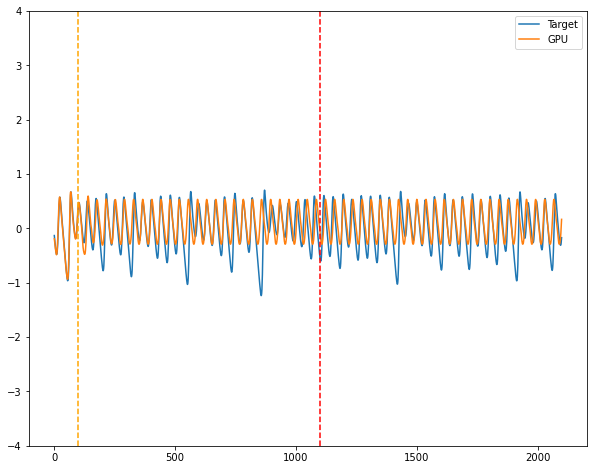

 Iter=65 a=0.732 sr=2.573 amp=1.000  ri=2.956 rr=2.685 loss=0.594990 nrmse=0.148672 CD 0.446318
Iter: 65 #### Time 6.09  NRMSE 0.149 CD 0.446
Iter: 66 #### Time 5.08  NRMSE 1000.000 CD nan
Iter: 67 #### Time 5.35  NRMSE 1000.000 CD nan
Iter: 68 #### Time 4.79  NRMSE 0.232 CD 0.953
Iter: 69 #### Time 4.68  NRMSE 0.180 CD 0.926
Iter: 70 #### Time 4.60  NRMSE 0.230 CD 0.928
Iter: 71 #### Time 5.22  NRMSE 0.209 CD 1.035
Iter: 72 #### Time 4.62  NRMSE 0.186 CD 0.845
Iter: 73 #### Time 4.77  NRMSE 0.207 CD 0.986
Iter: 74 #### Time 4.36  NRMSE 0.562 CD 0.992
Iter: 75 #### Time 4.90  NRMSE 0.192 CD 0.877
Iter: 76 #### Time 4.31  NRMSE 0.497 CD 0.999
Iter: 77 #### Time 4.36  NRMSE 0.225 CD 0.864
Iter: 78 #### Time 4.43  NRMSE 0.223 CD 0.978
Iter: 79 #### Time 4.40  NRMSE 0.299 CD 1.388
Iter: 80 #### Time 4.33  NRMSE 0.324 CD 1.020
Iter: 81 #### Time 4.30  NRMSE 1000.000 CD nan
Iter: 82 #### Time 4.59  NRMSE 1000.000 CD nan
Iter: 83 #### Time 4.37  NRMSE 1000.000 CD nan
Iter: 84 #### Time 4.48  

Iter: 30 #### Time 4.57  NRMSE 0.600 CD 0.997
Iter: 31 #### Time 4.96  NRMSE 0.204 CD 0.837
Iter: 32 #### Time 4.78  NRMSE 0.365 CD 1.085
Iter: 33 #### Time 5.31  NRMSE 1000.000 CD nan
Iter: 34 #### Time 5.11  NRMSE 0.250 CD 1.066
Iter: 35 #### Time 6.07  NRMSE 1000.000 CD nan
Iter: 36 #### Time 5.45  NRMSE 0.232 CD 1.006
Iter: 37 #### Time 4.78  NRMSE 0.190 CD 0.981
Iter: 38 #### Time 4.83  NRMSE 1000.000 CD nan
Iter: 39 #### Time 4.82  NRMSE 0.208 CD 0.994
Iter: 40 #### Time 5.04  NRMSE 1000.000 CD nan
Iter: 41 #### Time 4.48  NRMSE 1000.000 CD nan
Iter: 42 #### Time 5.16  NRMSE 0.216 CD 1.023
Iter: 43 #### Time 5.25  NRMSE 0.217 CD 0.842
Iter: 44 #### Time 4.86  NRMSE 0.212 CD 0.932
Iter: 45 #### Time 4.36  NRMSE 1000.000 CD nan
Iter: 46 #### Time 5.01  NRMSE 0.177 CD 0.869
Iter: 47 #### Time 4.58  NRMSE 1000.000 CD nan
Iter: 48 #### Time 4.78  NRMSE 0.283 CD 0.835
Iter: 49 #### Time 4.50  NRMSE 0.232 CD 0.769
Iter: 50 #### Time 5.04  NRMSE 0.300 CD 1.370
Iter: 51 #### Time 4.60  NR

Iter: 89 #### Time 4.46  NRMSE 1000.000 CD nan
Iter: 90 #### Time 4.58  NRMSE 0.188 CD 0.966
Iter: 91 #### Time 4.99  NRMSE 1000.000 CD nan
Iter: 92 #### Time 4.43  NRMSE 0.254 CD 1.078
Iter: 93 #### Time 4.70  NRMSE 0.190 CD 0.971
Iter: 94 #### Time 5.09  NRMSE 0.204 CD 0.596
Iter: 95 #### Time 4.48  NRMSE 0.241 CD 1.000
Iter: 96 #### Time 4.61  NRMSE 1000.000 CD nan
Iter: 97 #### Time 4.37  NRMSE 0.227 CD 0.929
Iter: 98 #### Time 4.76  NRMSE 0.234 CD 0.979
Iter: 99 #### Time 5.46  NRMSE 1000.000 CD nan
End Run 0 Time 481.465

Best result = 0.7998519589172287
a = 0.718085333624988
sr = 2.1031082371415515
amp = 1.4213723694559486
ri = 0.9484756612177911
********** Size26 ref 2 -- Run 1 ***********
Iter: 0 #### Time 4.50  NRMSE 0.190 CD 0.939
Iter: 1 #### Time 4.71  NRMSE 0.210 CD 1.008
Iter: 2 #### Time 4.90  NRMSE 0.199 CD 0.858
Iter: 3 #### Time 4.40  NRMSE 0.229 CD 0.904
Iter: 4 #### Time 4.74  NRMSE 1000.000 CD 0.951
Iter: 5 #### Time 4.36  NRMSE 0.216 CD 1.050
Iter: 6 #### Time 4.

Iter: 57 #### Time 4.87  NRMSE 0.234 CD 0.969
Iter: 58 #### Time 4.51  NRMSE 1000.000 CD nan
Iter: 59 #### Time 5.08  NRMSE 1000.000 CD nan
Iter: 60 #### Time 5.22  NRMSE 0.210 CD 0.638
Iter: 61 #### Time 5.52  NRMSE 0.256 CD 1.109
Iter: 62 #### Time 5.02  NRMSE 0.187 CD 0.568
Iter: 63 #### Time 4.31  NRMSE 0.270 CD 1.276
Iter: 64 #### Time 4.62  NRMSE 0.236 CD 0.995
Iter: 65 #### Time 4.41  NRMSE 0.284 CD 1.273
Iter: 66 #### Time 4.54  NRMSE 0.197 CD 0.948
Iter: 67 #### Time 4.96  NRMSE 0.239 CD 0.983
Iter: 68 #### Time 4.41  NRMSE 0.182 CD 0.939
Iter: 69 #### Time 4.98  NRMSE 1000.000 CD nan
Iter: 70 #### Time 4.76  NRMSE 1000.000 CD nan
Iter: 71 #### Time 4.76  NRMSE 0.198 CD 0.957
Iter: 72 #### Time 4.49  NRMSE 0.193 CD 0.971
Iter: 73 #### Time 4.67  NRMSE 0.181 CD 0.936
Iter: 74 #### Time 4.51  NRMSE 1000.000 CD nan
Iter: 75 #### Time 5.50  NRMSE 0.198 CD 0.976
Iter: 76 #### Time 5.60  NRMSE 0.230 CD 0.887
Iter: 77 #### Time 4.54  NRMSE 0.518 CD 0.999
Iter: 78 #### Time 4.43  NRMS

Iter: 24 #### Time 4.49  NRMSE 0.216 CD 0.974
Iter: 25 #### Time 4.55  NRMSE 0.201 CD 0.991
Iter: 26 #### Time 5.20  NRMSE 1000.000 CD nan
Iter: 27 #### Time 5.15  NRMSE 0.519 CD 0.971
Iter: 28 #### Time 4.62  NRMSE 1000.000 CD nan
Iter: 29 #### Time 4.71  NRMSE 0.190 CD 0.976
Iter: 30 #### Time 5.53  NRMSE 0.187 CD 0.949
Iter: 31 #### Time 5.84  NRMSE 0.183 CD 0.853
Iter: 32 #### Time 5.39  NRMSE 0.192 CD 0.544
Iter: 33 #### Time 4.69  NRMSE 1000.000 CD nan
Iter: 34 #### Time 4.74  NRMSE 0.511 CD 1.008
Iter: 35 #### Time 4.52  NRMSE 0.197 CD 0.977
Iter: 36 #### Time 5.02  NRMSE 0.230 CD 0.837
Iter: 37 #### Time 4.99  NRMSE 0.196 CD 0.947
Iter: 38 #### Time 4.80  NRMSE 1000.000 CD nan
Iter: 39 #### Time 5.24  NRMSE 1000.000 CD nan
Iter: 40 #### Time 4.88  NRMSE 0.195 CD 0.970
Iter: 41 #### Time 4.85  NRMSE 0.196 CD 0.977
Iter: 42 #### Time 4.48  NRMSE 1000.000 CD nan
Iter: 43 #### Time 4.67  NRMSE 0.203 CD 0.666
Iter: 44 #### Time 4.64  NRMSE 0.227 CD 1.092
Iter: 45 #### Time 4.46  NRM

Iter: 92 #### Time 5.94  NRMSE 0.195 CD 0.981
Iter: 93 #### Time 5.02  NRMSE 0.208 CD 0.643
Iter: 94 #### Time 4.36  NRMSE 1000.000 CD nan
Iter: 95 #### Time 4.40  NRMSE 0.187 CD 0.903
Iter: 96 #### Time 4.20  NRMSE 0.267 CD 1.106
Iter: 97 #### Time 4.46  NRMSE 1000.000 CD nan
Iter: 98 #### Time 4.15  NRMSE 1000.000 CD nan
Iter: 99 #### Time 4.40  NRMSE 0.227 CD 1.053
End Run 0 Time 507.148

Best result = 0.6009148317733786
a = 0.895889431049309
sr = 1.7809452491532647
amp = 3.094294382409569
ri = 3.258924950735966
********** Size26 ref 3 -- Run 1 ***********
Iter: 0 #### Time 4.64  NRMSE 0.189 CD 0.961
Iter: 1 #### Time 4.18  NRMSE 0.303 CD 1.420
Iter: 2 #### Time 4.47  NRMSE 1000.000 CD nan
Iter: 3 #### Time 4.66  NRMSE 0.178 CD 0.888
Iter: 4 #### Time 4.29  NRMSE 1000.000 CD nan
Iter: 5 #### Time 4.82  NRMSE 1000.000 CD nan
Iter: 6 #### Time 4.34  NRMSE 0.279 CD 1.189
Iter: 7 #### Time 4.54  NRMSE 0.229 CD 1.007
Iter: 8 #### Time 4.26  NRMSE 0.183 CD 0.827
Iter: 9 #### Time 4.42  NR

Iter: 59 #### Time 4.30  NRMSE 5.035 CD 1.024
Iter: 60 #### Time 4.27  NRMSE 0.228 CD 0.752
Iter: 61 #### Time 4.43  NRMSE 1000.000 CD nan
Iter: 62 #### Time 4.27  NRMSE 1000.000 CD nan
Iter: 63 #### Time 4.50  NRMSE 0.530 CD 0.998
Iter: 64 #### Time 4.11  NRMSE 0.235 CD 1.114
Iter: 65 #### Time 4.46  NRMSE 0.528 CD 1.000
Iter: 66 #### Time 5.11  NRMSE 0.171 CD 0.490
Iter: 67 #### Time 4.39  NRMSE 1000.000 CD nan
Iter: 68 #### Time 4.45  NRMSE 0.195 CD 0.969
Iter: 69 #### Time 4.23  NRMSE 0.223 CD 1.048
Iter: 70 #### Time 4.47  NRMSE 1000.000 CD nan
Iter: 71 #### Time 4.20  NRMSE 0.185 CD 0.983
Iter: 72 #### Time 4.42  NRMSE 0.234 CD 0.969
Iter: 73 #### Time 4.36  NRMSE 0.237 CD 0.996
Iter: 74 #### Time 4.29  NRMSE 1000.000 CD nan
Iter: 75 #### Time 4.44  NRMSE 0.179 CD 0.896
Iter: 76 #### Time 4.31  NRMSE 0.193 CD 0.946
Iter: 77 #### Time 4.67  NRMSE 1000.000 CD 1.016
Iter: 78 #### Time 4.65  NRMSE 0.200 CD 0.990
Iter: 79 #### Time 4.27  NRMSE 249.565 CD 0.991
Iter: 80 #### Time 4.60 

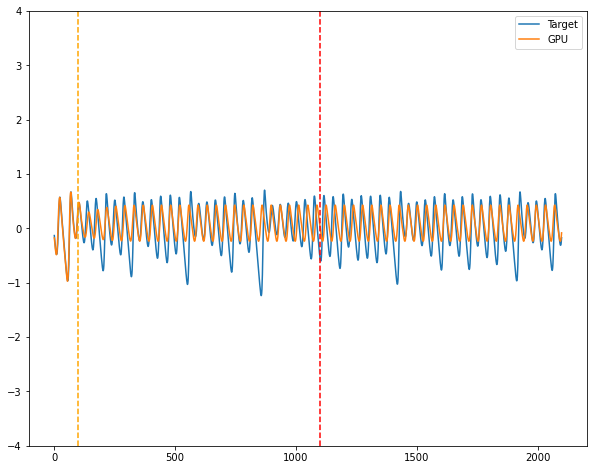

 Iter=5 a=0.804 sr=2.344 amp=1.000  ri=1.939 rr=1.647 loss=0.627076 nrmse=0.149180 CD 0.477896
Iter: 5 #### Time 4.23  NRMSE 0.149 CD 0.478
Iter: 6 #### Time 4.16  NRMSE 0.222 CD 0.980
Iter: 7 #### Time 4.09  NRMSE 0.164 CD 0.411
Iter: 8 #### Time 4.16  NRMSE 0.186 CD 0.916
Iter: 9 #### Time 4.25  NRMSE 0.197 CD 0.983
Iter: 10 #### Time 4.07  NRMSE 0.197 CD 0.963
Iter: 11 #### Time 4.09  NRMSE 0.208 CD 1.004
Iter: 12 #### Time 4.16  NRMSE 0.203 CD 0.975
Iter: 13 #### Time 4.11  NRMSE 0.239 CD 0.961
Iter: 14 #### Time 4.11  NRMSE 5556135811526520084233191424.000 CD 1.002
Iter: 15 #### Time 4.16  NRMSE 1000.000 CD nan
Iter: 16 #### Time 4.13  NRMSE 0.501 CD 0.998
Iter: 17 #### Time 4.12  NRMSE 1544194.838 CD 0.998
Iter: 18 #### Time 4.11  NRMSE 0.211 CD 0.984
Iter: 19 #### Time 4.12  NRMSE 1000.000 CD nan
Iter: 20 #### Time 4.30  NRMSE 0.231 CD 1.069
Iter: 21 #### Time 4.40  NRMSE 1000.000 CD nan
Iter: 22 #### Time 4.15  NRMSE 0.163 CD 0.596
Iter: 23 #### Time 4.11  NRMSE 0.192 CD 0.966


Iter: 73 #### Time 4.29  NRMSE 0.202 CD 0.980
Iter: 74 #### Time 4.36  NRMSE 1000.000 CD nan
Iter: 75 #### Time 4.22  NRMSE 1000.000 CD 1.020
Iter: 76 #### Time 4.10  NRMSE 1000.000 CD 0.978
Iter: 77 #### Time 4.06  NRMSE 1000.000 CD nan
Iter: 78 #### Time 4.07  NRMSE 1000.000 CD nan
Iter: 79 #### Time 4.05  NRMSE 0.218 CD 0.952
Iter: 80 #### Time 4.07  NRMSE 1000.000 CD nan
Iter: 81 #### Time 4.07  NRMSE 1000.000 CD 1.002
Iter: 82 #### Time 4.06  NRMSE 0.199 CD 0.911
Iter: 83 #### Time 4.07  NRMSE 1000.000 CD 1.006
Iter: 84 #### Time 4.08  NRMSE 1000.000 CD nan
Iter: 85 #### Time 4.09  NRMSE 0.225 CD 0.836
Iter: 86 #### Time 4.08  NRMSE 0.185 CD 0.895
Iter: 87 #### Time 4.06  NRMSE 1000.000 CD nan
Iter: 88 #### Time 4.07  NRMSE 0.231 CD 1.039
Iter: 89 #### Time 4.07  NRMSE 5629.777 CD 1.000
Iter: 90 #### Time 4.09  NRMSE 1000.000 CD nan
Iter: 91 #### Time 4.06  NRMSE 1000.000 CD nan
Iter: 92 #### Time 4.09  NRMSE 0.218 CD 0.908
Iter: 93 #### Time 4.07  NRMSE 1000.000 CD nan
Iter: 94 #

Iter: 30 #### Time 4.12  NRMSE 0.193 CD 0.980
Iter: 31 #### Time 4.10  NRMSE 0.200 CD 0.979
Iter: 32 #### Time 4.10  NRMSE 1000.000 CD nan
Iter: 33 #### Time 4.15  NRMSE 0.226 CD 1.095
Iter: 34 #### Time 4.08  NRMSE 0.314 CD 1.255
Iter: 35 #### Time 4.08  NRMSE 1.483 CD 0.994
Iter: 36 #### Time 4.13  NRMSE 1000.000 CD 0.985
Iter: 37 #### Time 4.07  NRMSE 0.187 CD 0.548
Iter: 38 #### Time 4.10  NRMSE 210613362.490 CD 0.994
Iter: 39 #### Time 4.12  NRMSE 1000.000 CD nan
Iter: 40 #### Time 4.10  NRMSE 1000.000 CD nan
Iter: 41 #### Time 4.10  NRMSE 0.204 CD 1.035
Iter: 42 #### Time 4.09  NRMSE 1000.000 CD nan
Iter: 43 #### Time 4.06  NRMSE 0.220 CD 0.924
Iter: 44 #### Time 4.07  NRMSE 1000.000 CD nan
Iter: 45 #### Time 4.08  NRMSE 1000.000 CD nan
Iter: 46 #### Time 4.06  NRMSE 1000.000 CD nan
Iter: 47 #### Time 4.08  NRMSE 0.235 CD 0.873
Iter: 48 #### Time 4.06  NRMSE 0.186 CD 0.924
Iter: 49 #### Time 4.06  NRMSE 0.259 CD 0.963
Iter: 50 #### Time 4.17  NRMSE 0.212 CD 0.858
Iter: 51 #### Ti

Iter: 0 #### Time 4.09  NRMSE 0.239 CD 0.985
Iter: 1 #### Time 4.07  NRMSE 0.238 CD 0.974
Iter: 2 #### Time 4.21  NRMSE 1000.000 CD nan
Iter: 3 #### Time 4.12  NRMSE 0.199 CD 0.978
Iter: 4 #### Time 4.09  NRMSE 0.219 CD 0.894
Iter: 5 #### Time 4.12  NRMSE 0.529 CD 1.000
Iter: 6 #### Time 4.09  NRMSE 0.234 CD 1.018
Iter: 7 #### Time 4.12  NRMSE 5112241444825691752235008.000 CD 0.995
Iter: 8 #### Time 4.10  NRMSE 0.266 CD 1.132
Iter: 9 #### Time 4.10  NRMSE 0.527 CD 0.992
Iter: 10 #### Time 4.10  NRMSE 0.462 CD 1.006
Iter: 11 #### Time 4.07  NRMSE 0.186 CD 0.971
Iter: 12 #### Time 4.10  NRMSE 0.234 CD 1.102
Iter: 13 #### Time 4.07  NRMSE 0.206 CD 0.947
Iter: 14 #### Time 4.21  NRMSE 1000.000 CD nan
Iter: 15 #### Time 4.08  NRMSE 0.189 CD 0.974
Iter: 16 #### Time 4.30  NRMSE 0.269 CD 1.119
Iter: 17 #### Time 4.32  NRMSE 0.200 CD 0.977
Iter: 18 #### Time 4.26  NRMSE 0.245 CD 0.975
Iter: 19 #### Time 4.28  NRMSE 0.367 CD 0.983
Iter: 20 #### Time 4.22  NRMSE 0.193 CD 0.997
Iter: 21 #### Time

Iter: 72 #### Time 4.32  NRMSE 0.234 CD 1.052
Iter: 73 #### Time 4.48  NRMSE 0.200 CD 0.952
Iter: 74 #### Time 4.34  NRMSE 1000.000 CD 0.997
Iter: 75 #### Time 4.45  NRMSE 1000.000 CD nan
Iter: 76 #### Time 4.19  NRMSE 0.200 CD 1.038
Iter: 77 #### Time 4.17  NRMSE 1000.000 CD nan
Iter: 78 #### Time 4.19  NRMSE 0.228 CD 0.895
Iter: 79 #### Time 4.10  NRMSE 0.216 CD 1.083
Iter: 80 #### Time 4.13  NRMSE 0.224 CD 0.877
Iter: 81 #### Time 4.18  NRMSE 0.424 CD 1.001
Iter: 82 #### Time 4.14  NRMSE 0.321 CD 0.856
Iter: 83 #### Time 4.18  NRMSE 1000.000 CD nan
Iter: 84 #### Time 4.14  NRMSE 0.171 CD 0.487
Iter: 85 #### Time 4.11  NRMSE 1000.000 CD nan
Iter: 86 #### Time 4.38  NRMSE 0.187 CD 0.961
Iter: 87 #### Time 4.15  NRMSE 1000.000 CD nan
Iter: 88 #### Time 4.18  NRMSE 0.232 CD 1.043
Iter: 89 #### Time 4.21  NRMSE 0.175 CD 0.528
Iter: 90 #### Time 4.15  NRMSE 0.196 CD 0.967
Iter: 91 #### Time 4.18  NRMSE 0.191 CD 0.983
Iter: 92 #### Time 4.21  NRMSE 0.218 CD 0.850
Iter: 93 #### Time 4.17  N

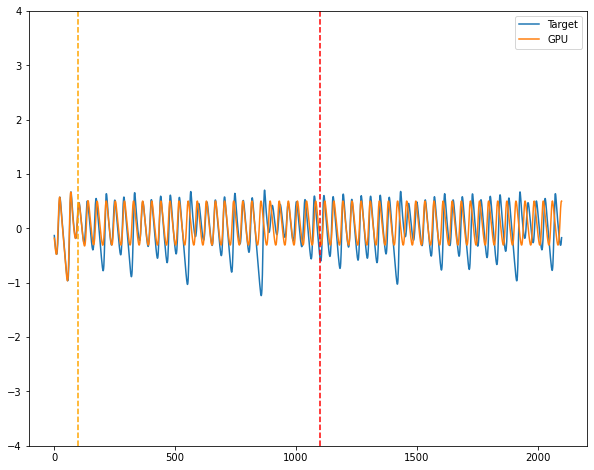

 Iter=4 a=0.729 sr=2.865 amp=1.000  ri=2.453 rr=3.375 loss=0.587713 nrmse=0.145376 CD 0.442338
Iter: 4 #### Time 5.80  NRMSE 0.145 CD 0.442
Iter: 5 #### Time 4.77  NRMSE 1000.000 CD nan
Iter: 6 #### Time 4.27  NRMSE 0.271 CD 1.129
Iter: 7 #### Time 4.52  NRMSE 0.272 CD 1.185
Iter: 8 #### Time 4.69  NRMSE 0.227 CD 1.048
Iter: 9 #### Time 4.17  NRMSE 0.249 CD 1.053
Iter: 10 #### Time 4.43  NRMSE 1000.000 CD nan
Iter: 11 #### Time 4.70  NRMSE 0.233 CD 0.991
Iter: 12 #### Time 4.37  NRMSE 0.231 CD 0.854
Iter: 13 #### Time 4.62  NRMSE 1000.000 CD nan
Iter: 14 #### Time 4.25  NRMSE 1000.000 CD nan
Iter: 15 #### Time 4.47  NRMSE 0.233 CD 0.901
Iter: 16 #### Time 4.26  NRMSE 1000.000 CD nan
Iter: 17 #### Time 4.35  NRMSE 0.188 CD 0.960
Iter: 18 #### Time 4.89  NRMSE 1000.000 CD nan
Iter: 19 #### Time 4.33  NRMSE 0.245 CD 1.023
Iter: 20 #### Time 4.68  NRMSE 0.252 CD 1.004
Iter: 21 #### Time 4.67  NRMSE 0.168 CD 0.515
Iter: 22 #### Time 4.47  NRMSE 0.200 CD 0.965
Iter: 23 #### Time 4.58  NRMSE 

Iter: 73 #### Time 4.33  NRMSE 0.212 CD 0.991
Iter: 74 #### Time 4.18  NRMSE 12.631 CD 1.137
Iter: 75 #### Time 4.38  NRMSE 0.190 CD 0.964
Iter: 76 #### Time 4.34  NRMSE 1000.000 CD nan
Iter: 77 #### Time 4.21  NRMSE 0.185 CD 0.982
Iter: 78 #### Time 4.30  NRMSE 1000.000 CD nan
Iter: 79 #### Time 4.45  NRMSE 1000.000 CD nan
Iter: 80 #### Time 4.20  NRMSE 0.248 CD 1.109
Iter: 81 #### Time 4.34  NRMSE 0.192 CD 0.874
Iter: 82 #### Time 4.37  NRMSE 1000.000 CD nan
Iter: 83 #### Time 4.15  NRMSE 0.232 CD 0.974
Iter: 84 #### Time 4.44  NRMSE 0.199 CD 0.987
Iter: 85 #### Time 4.43  NRMSE 0.219 CD 1.036
Iter: 86 #### Time 4.13  NRMSE 1000.000 CD nan
Iter: 87 #### Time 4.43  NRMSE 17035615003.139 CD 1.002
Iter: 88 #### Time 4.52  NRMSE 1000.000 CD nan
Iter: 89 #### Time 4.29  NRMSE 1000.000 CD nan
Iter: 90 #### Time 4.53  NRMSE 1000.000 CD nan
Iter: 91 #### Time 4.47  NRMSE 1000.000 CD nan
Iter: 92 #### Time 4.14  NRMSE 0.518 CD 0.997
Iter: 93 #### Time 4.58  NRMSE 0.264 CD 1.229
Iter: 94 #### 

Iter: 40 #### Time 4.47  NRMSE 0.202 CD 0.952
Iter: 41 #### Time 4.47  NRMSE 0.192 CD 0.998
Iter: 42 #### Time 4.38  NRMSE 0.194 CD 0.966
Iter: 43 #### Time 4.47  NRMSE 1000.000 CD nan
Iter: 44 #### Time 4.47  NRMSE 1000.000 CD nan
Iter: 45 #### Time 4.26  NRMSE 1000.000 CD nan
Iter: 46 #### Time 4.25  NRMSE 1000.000 CD nan
Iter: 47 #### Time 4.57  NRMSE 415849.985 CD 1.002
Iter: 48 #### Time 4.44  NRMSE 0.183 CD 0.625
Iter: 49 #### Time 4.23  NRMSE 0.194 CD 0.957
Iter: 50 #### Time 4.32  NRMSE 0.243 CD 0.980
Iter: 51 #### Time 4.38  NRMSE 1414945036931839447690903552.000 CD 1.002
Iter: 52 #### Time 4.17  NRMSE 0.180 CD 0.912
Iter: 53 #### Time 4.54  NRMSE 0.182 CD 0.945
Iter: 54 #### Time 4.31  NRMSE 0.249 CD 0.958
Iter: 55 #### Time 4.19  NRMSE 1000.000 CD 0.999
Iter: 56 #### Time 4.40  NRMSE 1000.000 CD nan
Iter: 57 #### Time 4.45  NRMSE 1000.000 CD nan
Iter: 58 #### Time 4.13  NRMSE 0.247 CD 0.985
Iter: 59 #### Time 4.40  NRMSE 0.203 CD 0.998
Iter: 60 #### Time 4.13  NRMSE 0.243 CD

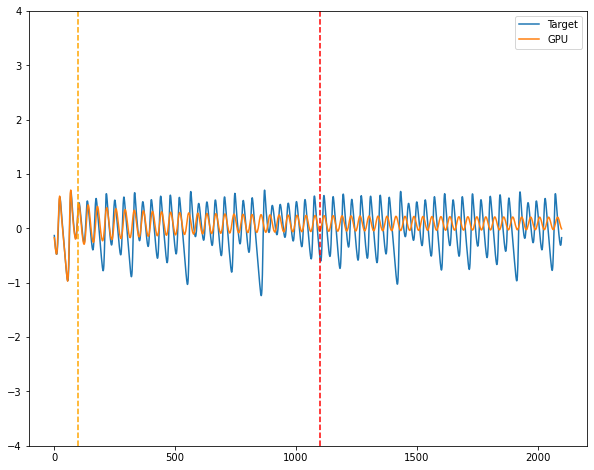

 Iter=26 a=0.942 sr=1.745 amp=1.000  ri=1.424 rr=0.992 loss=0.605522 nrmse=0.143150 CD 0.462372
Iter: 26 #### Time 4.30  NRMSE 0.143 CD 0.462
Iter: 27 #### Time 4.22  NRMSE 1000.000 CD nan
Iter: 28 #### Time 4.13  NRMSE 0.247 CD 1.083
Iter: 29 #### Time 4.12  NRMSE 0.245 CD 1.041
Iter: 30 #### Time 4.11  NRMSE 0.246 CD 1.072
Iter: 31 #### Time 4.12  NRMSE 0.236 CD 0.951
Iter: 32 #### Time 4.11  NRMSE 0.207 CD 1.005
Iter: 33 #### Time 4.15  NRMSE 1000.000 CD nan
Iter: 34 #### Time 4.16  NRMSE 0.233 CD 1.011
Iter: 35 #### Time 4.13  NRMSE 0.186 CD 0.803
Iter: 36 #### Time 4.14  NRMSE 0.231 CD 0.894
Iter: 37 #### Time 4.13  NRMSE 0.184 CD 0.954
Iter: 38 #### Time 4.12  NRMSE 1000.000 CD nan
Iter: 39 #### Time 4.13  NRMSE 1000.000 CD nan
Iter: 40 #### Time 4.12  NRMSE 0.413 CD 0.990
Iter: 41 #### Time 4.13  NRMSE 0.242 CD 1.109
Iter: 42 #### Time 4.21  NRMSE 0.184 CD 0.984
Iter: 43 #### Time 4.28  NRMSE 1000.000 CD nan
Iter: 44 #### Time 4.19  NRMSE 1000.000 CD nan
Iter: 45 #### Time 4.18 

Iter: 95 #### Time 4.66  NRMSE 0.228 CD 0.753
Iter: 96 #### Time 4.16  NRMSE 1000.000 CD nan
Iter: 97 #### Time 4.59  NRMSE 0.596 CD 0.942
Iter: 98 #### Time 4.11  NRMSE 0.197 CD 0.957
Iter: 99 #### Time 4.08  NRMSE 1000.000 CD nan
End Run 1 Time 438.719

Best result = 0.6825859559140155
a = 0.7997517137098853
sr = 2.3596680925709452
amp = 2.316364233253998
ri = 1.53979221743911
********** Size24 ref 1 -- Run 2 ***********
Iter: 0 #### Time 4.46  NRMSE 1000.000 CD nan
Iter: 1 #### Time 4.29  NRMSE 0.531 CD 0.998
Iter: 2 #### Time 4.17  NRMSE 1000.000 CD nan
Iter: 3 #### Time 4.15  NRMSE 0.196 CD 0.986
Iter: 4 #### Time 4.08  NRMSE 1000.000 CD nan
Iter: 5 #### Time 4.12  NRMSE 0.284 CD 1.277
Iter: 6 #### Time 4.15  NRMSE 0.203 CD 1.006
Iter: 7 #### Time 4.13  NRMSE 1000.000 CD nan
Iter: 8 #### Time 4.11  NRMSE 0.193 CD 0.956
Iter: 9 #### Time 4.11  NRMSE 1000.000 CD nan
Iter: 10 #### Time 4.17  NRMSE 0.196 CD 0.922
Iter: 11 #### Time 4.17  NRMSE 0.196 CD 0.981
Iter: 12 #### Time 4.13  N

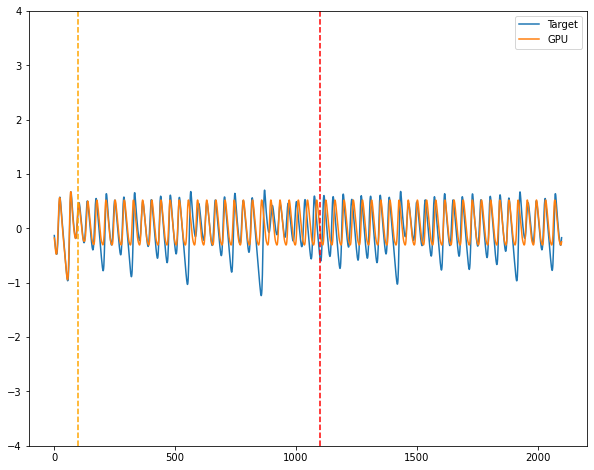

 Iter=28 a=0.872 sr=2.014 amp=1.000  ri=2.251 rr=0.834 loss=0.586153 nrmse=0.148893 CD 0.437260
Iter: 28 #### Time 4.94  NRMSE 0.149 CD 0.437
Iter: 29 #### Time 4.14  NRMSE 1000.000 CD nan
Iter: 30 #### Time 4.11  NRMSE 0.513 CD 0.992
Iter: 31 #### Time 4.11  NRMSE 1000.000 CD nan
Iter: 32 #### Time 4.06  NRMSE 0.192 CD 0.983
Iter: 33 #### Time 4.21  NRMSE 0.182 CD 0.952
Iter: 34 #### Time 4.09  NRMSE 0.258 CD 1.024
Iter: 35 #### Time 4.15  NRMSE 0.271 CD 1.216
Iter: 36 #### Time 4.09  NRMSE 1000.000 CD nan
Iter: 37 #### Time 4.14  NRMSE 0.181 CD 0.911
Iter: 38 #### Time 4.18  NRMSE 0.226 CD 0.975
Iter: 39 #### Time 4.31  NRMSE 1000.000 CD 0.992
Iter: 40 #### Time 4.13  NRMSE 967.040 CD 0.993
Iter: 41 #### Time 4.18  NRMSE 0.212 CD 1.023
Iter: 42 #### Time 4.13  NRMSE 0.182 CD 0.971
Iter: 43 #### Time 4.19  NRMSE 0.205 CD 1.003
Iter: 44 #### Time 4.13  NRMSE 0.498 CD 0.996
Iter: 45 #### Time 4.45  NRMSE 0.184 CD 0.957
Iter: 46 #### Time 4.47  NRMSE 1000.000 CD nan
Iter: 47 #### Time 4.

Iter: 99 #### Time 4.06  NRMSE 1000.000 CD nan
End Run 3 Time 440.392

Best result = 0.6308213948975958
a = 0.8872706721376742
sr = 1.7323485771080704
amp = 1.3981808385671057
ri = 2.5699722451274742
********** Size24 ref 1 -- Run 4 ***********
Iter: 0 #### Time 4.10  NRMSE 1000.000 CD nan
Iter: 1 #### Time 4.04  NRMSE 1000.000 CD nan
Iter: 2 #### Time 4.11  NRMSE 0.186 CD 0.879
Iter: 3 #### Time 4.13  NRMSE 0.242 CD 1.041
Iter: 4 #### Time 4.11  NRMSE 0.209 CD 0.997
Iter: 5 #### Time 4.12  NRMSE 0.206 CD 0.912
Iter: 6 #### Time 4.29  NRMSE 0.536 CD 1.002
Iter: 7 #### Time 4.10  NRMSE 0.189 CD 0.954
Iter: 8 #### Time 4.06  NRMSE 0.194 CD 0.874
Iter: 9 #### Time 4.12  NRMSE 1000.000 CD nan
Iter: 10 #### Time 4.15  NRMSE 1000.000 CD nan
Iter: 11 #### Time 4.13  NRMSE 0.192 CD 0.803
Iter: 12 #### Time 4.08  NRMSE 0.202 CD 0.980
Iter: 13 #### Time 4.12  NRMSE 0.186 CD 0.919
Iter: 14 #### Time 4.12  NRMSE 1000.000 CD nan
Iter: 15 #### Time 4.13  NRMSE 1000.000 CD 1.004
Iter: 16 #### Time 4.

Iter: 56 #### Time 4.33  NRMSE 0.155 CD 0.468
Iter: 57 #### Time 4.70  NRMSE 0.196 CD 0.627
Iter: 58 #### Time 4.56  NRMSE 1000.000 CD nan
Iter: 59 #### Time 4.26  NRMSE 0.198 CD 0.960
Iter: 60 #### Time 4.70  NRMSE 0.180 CD 0.921
Iter: 61 #### Time 4.23  NRMSE 0.201 CD 1.021
Iter: 62 #### Time 4.89  NRMSE 0.225 CD 1.151
Iter: 63 #### Time 4.62  NRMSE 0.196 CD 0.951
Iter: 64 #### Time 4.33  NRMSE 0.246 CD 0.866
Iter: 65 #### Time 5.08  NRMSE 0.291 CD 0.974
Iter: 66 #### Time 4.25  NRMSE 0.262 CD 1.132
Iter: 67 #### Time 4.56  NRMSE 0.192 CD 0.965
Iter: 68 #### Time 4.37  NRMSE 0.249 CD 1.005
Iter: 69 #### Time 4.32  NRMSE 0.213 CD 1.035
Iter: 70 #### Time 4.49  NRMSE 0.176 CD 0.855
Iter: 71 #### Time 4.78  NRMSE 1000.000 CD 1.001
Iter: 72 #### Time 5.09  NRMSE 0.200 CD 0.973
Iter: 73 #### Time 4.25  NRMSE 0.199 CD 0.992
Iter: 74 #### Time 4.58  NRMSE 0.284 CD 0.845
Iter: 75 #### Time 4.30  NRMSE 0.206 CD 0.634
Iter: 76 #### Time 4.25  NRMSE 0.218 CD 1.023
Iter: 77 #### Time 4.11  NRMSE

Iter: 23 #### Time 4.40  NRMSE 0.190 CD 0.970
Iter: 24 #### Time 4.69  NRMSE 0.187 CD 0.957
Iter: 25 #### Time 4.33  NRMSE 0.231 CD 1.066
Iter: 26 #### Time 4.53  NRMSE 0.499 CD 1.003
Iter: 27 #### Time 4.41  NRMSE 0.219 CD 1.076
Iter: 28 #### Time 4.58  NRMSE 0.181 CD 0.918
Iter: 29 #### Time 4.23  NRMSE 1000.000 CD nan
Iter: 30 #### Time 4.53  NRMSE 0.189 CD 0.944
Iter: 31 #### Time 4.24  NRMSE 1000.000 CD nan
Iter: 32 #### Time 4.32  NRMSE 0.209 CD 0.945
Iter: 33 #### Time 4.55  NRMSE 0.183 CD 0.864
Iter: 34 #### Time 4.26  NRMSE 1000.000 CD nan
Iter: 35 #### Time 4.66  NRMSE 0.267 CD 1.277
Iter: 36 #### Time 4.45  NRMSE 0.197 CD 0.968
Iter: 37 #### Time 4.20  NRMSE 0.193 CD 0.969
Iter: 38 #### Time 4.35  NRMSE 0.182 CD 0.894
Iter: 39 #### Time 4.36  NRMSE 0.181 CD 0.949
Iter: 40 #### Time 4.82  NRMSE 1000.000 CD nan
Iter: 41 #### Time 4.62  NRMSE 1000.000 CD nan
Iter: 42 #### Time 4.28  NRMSE 0.181 CD 0.931
Iter: 43 #### Time 4.33  NRMSE 0.288 CD 1.322
Iter: 44 #### Time 4.21  NRMS

Iter: 94 #### Time 4.62  NRMSE 1000.000 CD 1.024
Iter: 95 #### Time 4.26  NRMSE 0.248 CD 1.002
Iter: 96 #### Time 4.55  NRMSE 0.230 CD 0.735
Iter: 97 #### Time 4.20  NRMSE 1000.000 CD nan
Iter: 98 #### Time 4.77  NRMSE 1000.000 CD nan
Iter: 99 #### Time 4.41  NRMSE 0.268 CD 1.158
End Run 3 Time 431.924

Best result = 0.69586684895901
a = 0.7889948925572731
sr = 1.8493995798406049
amp = 0.8145552570942187
ri = 2.865340069298837
********** Size24 ref 2 -- Run 4 ***********
Iter: 0 #### Time 4.35  NRMSE 0.229 CD 0.903
Iter: 1 #### Time 4.81  NRMSE 0.201 CD 0.965
Iter: 2 #### Time 4.17  NRMSE 0.252 CD 1.091
Iter: 3 #### Time 4.55  NRMSE 0.192 CD 0.971
Iter: 4 #### Time 4.39  NRMSE 0.943 CD 0.993
Iter: 5 #### Time 4.31  NRMSE 0.692 CD 0.887
Iter: 6 #### Time 4.44  NRMSE 0.176 CD 0.546
Iter: 7 #### Time 4.16  NRMSE 0.227 CD 1.076
Iter: 8 #### Time 4.54  NRMSE 0.184 CD 0.971
Iter: 9 #### Time 4.43  NRMSE 0.177 CD 0.868
Iter: 10 #### Time 4.48  NRMSE 1000.000 CD nan
Iter: 11 #### Time 4.54  NR

Iter: 56 #### Time 4.11  NRMSE 1000.000 CD nan
Iter: 57 #### Time 4.35  NRMSE 0.183 CD 0.833
Iter: 58 #### Time 4.36  NRMSE 1000.000 CD nan
Iter: 59 #### Time 4.15  NRMSE 0.198 CD 0.977
Iter: 60 #### Time 4.49  NRMSE 1000.000 CD nan
Iter: 61 #### Time 4.34  NRMSE 0.268 CD 1.166
Iter: 62 #### Time 4.35  NRMSE 0.196 CD 0.971
Iter: 63 #### Time 4.39  NRMSE 0.201 CD 1.001
Iter: 64 #### Time 4.45  NRMSE 0.213 CD 0.729
Iter: 65 #### Time 4.17  NRMSE 0.196 CD 0.949
Iter: 66 #### Time 4.42  NRMSE 10.489 CD 0.869
Iter: 67 #### Time 4.44  NRMSE 0.197 CD 0.963
Iter: 68 #### Time 4.13  NRMSE 0.251 CD 0.897
Iter: 69 #### Time 4.89  NRMSE 1000.000 CD nan
Iter: 70 #### Time 4.30  NRMSE 0.205 CD 0.943
Iter: 71 #### Time 4.20  NRMSE 1000.000 CD nan
Iter: 72 #### Time 4.41  NRMSE 0.200 CD 0.810
Iter: 73 #### Time 4.47  NRMSE 1000.000 CD nan
Iter: 74 #### Time 4.12  NRMSE 0.202 CD 0.960
Iter: 75 #### Time 4.57  NRMSE 0.280 CD 1.193
Iter: 76 #### Time 4.37  NRMSE 0.205 CD 0.957
Iter: 77 #### Time 4.25  NR

Iter: 22 #### Time 4.32  NRMSE 0.214 CD 1.132
Iter: 23 #### Time 4.23  NRMSE 0.484 CD 1.002
Iter: 24 #### Time 4.40  NRMSE 0.192 CD 0.942
Iter: 25 #### Time 4.34  NRMSE 0.242 CD 0.918
Iter: 26 #### Time 4.20  NRMSE 1000.000 CD nan
Iter: 27 #### Time 4.38  NRMSE 0.182 CD 0.519
Iter: 28 #### Time 4.29  NRMSE 265834.565 CD 0.998
Iter: 29 #### Time 4.12  NRMSE 1000.000 CD 1.030
Iter: 30 #### Time 4.29  NRMSE 0.523 CD 0.992
Iter: 31 #### Time 4.32  NRMSE 0.267 CD 1.100
Iter: 32 #### Time 4.27  NRMSE 1000.000 CD 1.003
Iter: 33 #### Time 4.31  NRMSE 0.194 CD 0.987
Iter: 34 #### Time 4.74  NRMSE 0.227 CD 0.962
Iter: 35 #### Time 4.28  NRMSE 0.197 CD 0.932
Iter: 36 #### Time 4.45  NRMSE 0.261 CD 1.089
Iter: 37 #### Time 4.17  NRMSE 0.199 CD 0.824
Iter: 38 #### Time 4.48  NRMSE 1000.000 CD nan
Iter: 39 #### Time 4.36  NRMSE 1000.000 CD 0.994
Iter: 40 #### Time 4.22  NRMSE 26.311 CD 0.997
Iter: 41 #### Time 4.36  NRMSE 0.198 CD 0.974
Iter: 42 #### Time 4.37  NRMSE 0.212 CD 0.772
Iter: 43 #### Tim

Iter: 94 #### Time 4.59  NRMSE 581181998887838376412577792.000 CD 1.001
Iter: 95 #### Time 4.29  NRMSE 0.533 CD 0.996
Iter: 96 #### Time 4.14  NRMSE 1000.000 CD nan
Iter: 97 #### Time 4.37  NRMSE 1000.000 CD nan
Iter: 98 #### Time 4.43  NRMSE 1000.000 CD nan
Iter: 99 #### Time 4.16  NRMSE 1000.000 CD nan
End Run 3 Time 421.574

Best result = 0.6319628447491632
a = 0.7284759964531407
sr = 2.648331364890133
amp = 0.8557839716220728
ri = 1.185790417054476
********** Size24 ref 3 -- Run 4 ***********
Iter: 0 #### Time 4.27  NRMSE 0.182 CD 0.821
Iter: 1 #### Time 4.29  NRMSE 1000.000 CD nan
Iter: 2 #### Time 4.43  NRMSE 0.225 CD 1.004
Iter: 3 #### Time 4.43  NRMSE 1000.000 CD nan
Iter: 4 #### Time 4.31  NRMSE 0.244 CD 1.092
Iter: 5 #### Time 4.60  NRMSE 0.225 CD 0.965
Iter: 6 #### Time 4.15  NRMSE 0.244 CD 1.068
Iter: 7 #### Time 4.55  NRMSE 0.231 CD 0.922
Iter: 8 #### Time 4.18  NRMSE 0.192 CD 0.970
Iter: 9 #### Time 4.64  NRMSE 0.231 CD 1.059
Iter: 10 #### Time 4.26  NRMSE 1000.000 CD nan

Iter: 55 #### Time 4.09  NRMSE 0.220 CD 1.017
Iter: 56 #### Time 4.13  NRMSE 0.193 CD 0.981
Iter: 57 #### Time 4.15  NRMSE 1000.000 CD nan
Iter: 58 #### Time 4.11  NRMSE 0.277 CD 1.201
Iter: 59 #### Time 4.09  NRMSE 0.185 CD 0.940
Iter: 60 #### Time 4.14  NRMSE 0.221 CD 1.009
Iter: 61 #### Time 4.10  NRMSE 0.251 CD 1.052
Iter: 62 #### Time 4.07  NRMSE 0.240 CD 1.069
Iter: 63 #### Time 4.07  NRMSE 0.199 CD 0.998
Iter: 64 #### Time 4.09  NRMSE 0.220 CD 0.985
Iter: 65 #### Time 4.09  NRMSE 0.178 CD 0.880
Iter: 66 #### Time 4.09  NRMSE 0.180 CD 0.919
Iter: 67 #### Time 4.09  NRMSE 0.223 CD 1.005
Iter: 68 #### Time 4.13  NRMSE 0.179 CD 0.817
Iter: 69 #### Time 4.10  NRMSE 0.553 CD 0.996
Iter: 70 #### Time 4.13  NRMSE 0.187 CD 0.771
Iter: 71 #### Time 4.08  NRMSE 0.201 CD 0.988
Iter: 72 #### Time 4.17  NRMSE 0.224 CD 0.954
Iter: 73 #### Time 4.20  NRMSE 0.191 CD 0.906
Iter: 74 #### Time 4.38  NRMSE 0.241 CD 0.932
Iter: 75 #### Time 4.17  NRMSE 1000.000 CD nan
Iter: 76 #### Time 4.50  NRMSE 0

Iter: 23 #### Time 4.24  NRMSE 0.218 CD 1.030
Iter: 24 #### Time 4.14  NRMSE 1000.000 CD nan
Iter: 25 #### Time 4.18  NRMSE 0.482 CD 1.006
Iter: 26 #### Time 4.25  NRMSE 1000.000 CD nan
Iter: 27 #### Time 4.10  NRMSE 0.218 CD 0.922
Iter: 28 #### Time 4.11  NRMSE 0.181 CD 0.797
Iter: 29 #### Time 4.23  NRMSE 1000.000 CD 0.992
Iter: 30 #### Time 4.07  NRMSE 1000.000 CD nan
Iter: 31 #### Time 4.11  NRMSE 0.199 CD 0.979
Iter: 32 #### Time 4.18  NRMSE 0.203 CD 0.983
Iter: 33 #### Time 4.05  NRMSE 1000.000 CD nan
Iter: 34 #### Time 4.09  NRMSE 1000.000 CD 1.000
Iter: 35 #### Time 4.06  NRMSE 0.500 CD 0.999
Iter: 36 #### Time 4.11  NRMSE 0.196 CD 0.603
Iter: 37 #### Time 4.09  NRMSE 0.247 CD 1.074
Iter: 38 #### Time 4.04  NRMSE 1000.000 CD nan
Iter: 39 #### Time 4.08  NRMSE 1000.000 CD 1.004
Iter: 40 #### Time 4.13  NRMSE 1000.000 CD nan
Iter: 41 #### Time 4.13  NRMSE 1000.000 CD nan
Iter: 42 #### Time 4.18  NRMSE 1000.000 CD nan
Iter: 43 #### Time 4.18  NRMSE 1000.000 CD nan
Iter: 44 #### Ti

Iter: 95 #### Time 4.14  NRMSE 1000.000 CD nan
Iter: 96 #### Time 4.18  NRMSE 0.211 CD 1.035
Iter: 97 #### Time 4.12  NRMSE 0.185 CD 0.544
Iter: 98 #### Time 4.40  NRMSE 0.227 CD 0.951
Iter: 99 #### Time 4.11  NRMSE 0.196 CD 0.986
End Run 3 Time 426.665

Best result = 0.6584425038285475
a = 0.8956601837272001
sr = 2.88068517496453
amp = 0.39933407540413096
ri = 2.6396916571652853
********** Size24 ref 4 -- Run 4 ***********
Iter: 0 #### Time 4.09  NRMSE 0.184 CD 0.860
Iter: 1 #### Time 4.09  NRMSE 0.184 CD 0.971
Iter: 2 #### Time 4.26  NRMSE 0.468 CD 0.999
Iter: 3 #### Time 4.11  NRMSE 0.216 CD 0.957
Iter: 4 #### Time 4.13  NRMSE 1000.000 CD 0.999
Iter: 5 #### Time 4.09  NRMSE 0.228 CD 0.974
Iter: 6 #### Time 4.16  NRMSE 0.196 CD 0.979
Iter: 7 #### Time 4.09  NRMSE 0.223 CD 0.911
Iter: 8 #### Time 4.14  NRMSE 1000.000 CD nan
Iter: 9 #### Time 4.11  NRMSE 0.199 CD 0.978
Iter: 10 #### Time 4.16  NRMSE 1000.000 CD nan
Iter: 11 #### Time 4.14  NRMSE 0.253 CD 1.039
Iter: 12 #### Time 4.12  

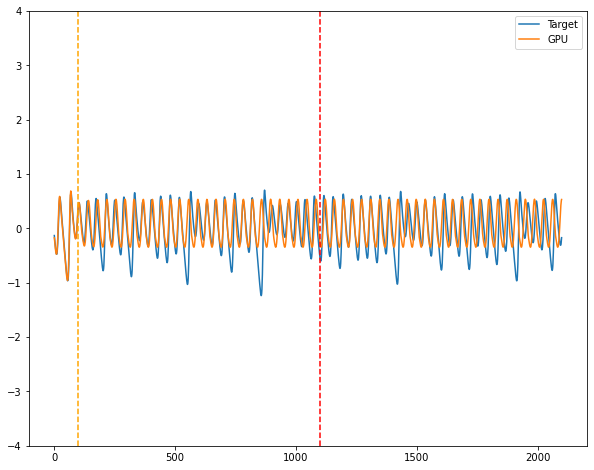

 Iter=47 a=0.996 sr=1.674 amp=1.000  ri=1.271 rr=2.163 loss=0.569973 nrmse=0.149041 CD 0.420932
Iter: 47 #### Time 5.22  NRMSE 0.149 CD 0.421
Iter: 48 #### Time 4.25  NRMSE 0.209 CD 0.837
Iter: 49 #### Time 4.30  NRMSE 0.201 CD 0.989
Iter: 50 #### Time 4.69  NRMSE 0.237 CD 0.792
Iter: 51 #### Time 4.21  NRMSE 0.197 CD 0.985
Iter: 52 #### Time 4.62  NRMSE 1000.000 CD nan
Iter: 53 #### Time 4.72  NRMSE 0.250 CD 0.950
Iter: 54 #### Time 4.54  NRMSE 0.220 CD 0.979
Iter: 55 #### Time 4.39  NRMSE 0.173 CD 0.503
Iter: 56 #### Time 4.20  NRMSE 1000.000 CD nan
Iter: 57 #### Time 4.44  NRMSE 0.229 CD 1.025
Iter: 58 #### Time 4.93  NRMSE 0.192 CD 0.966
Iter: 59 #### Time 4.23  NRMSE 0.239 CD 1.103
Iter: 60 #### Time 4.43  NRMSE 1000.000 CD nan
Iter: 61 #### Time 4.14  NRMSE 1000.000 CD nan
Iter: 62 #### Time 4.61  NRMSE 153725529592.993 CD 1.002
Iter: 63 #### Time 4.29  NRMSE 1000.000 CD nan
Iter: 64 #### Time 4.29  NRMSE 1000.000 CD nan
Iter: 65 #### Time 4.52  NRMSE 1000.000 CD nan
Iter: 66 ###

Iter: 0 #### Time 4.13  NRMSE 4993.900 CD 0.963
Iter: 1 #### Time 4.15  NRMSE 0.198 CD 0.938
Iter: 2 #### Time 4.17  NRMSE 1000.000 CD nan
Iter: 3 #### Time 4.13  NRMSE 0.242 CD 0.953
Iter: 4 #### Time 4.14  NRMSE 4444997224.408 CD 1.005
Iter: 5 #### Time 4.80  NRMSE 0.196 CD 0.977
Iter: 6 #### Time 4.39  NRMSE 0.181 CD 0.924
Iter: 7 #### Time 4.38  NRMSE 0.239 CD 1.060
Iter: 8 #### Time 4.41  NRMSE 0.191 CD 0.936
Iter: 9 #### Time 4.69  NRMSE 16.447 CD 0.987
Iter: 10 #### Time 4.18  NRMSE 2.078 CD 1.004
Iter: 11 #### Time 4.53  NRMSE 0.241 CD 0.917
Iter: 12 #### Time 4.29  NRMSE 1000.000 CD nan
Iter: 13 #### Time 4.21  NRMSE 0.201 CD 0.983
Iter: 14 #### Time 4.47  NRMSE 0.200 CD 0.983
Iter: 15 #### Time 4.33  NRMSE 1000.000 CD nan
Iter: 16 #### Time 4.25  NRMSE 0.465 CD 0.990
Iter: 17 #### Time 4.30  NRMSE 0.187 CD 0.967
Iter: 18 #### Time 4.36  NRMSE 0.244 CD 0.855
Iter: 19 #### Time 4.17  NRMSE 1000.000 CD nan
Iter: 20 #### Time 4.53  NRMSE 1000.000 CD nan
Iter: 21 #### Time 4.31  N

Iter: 73 #### Time 4.10  NRMSE 0.189 CD 0.769
Iter: 74 #### Time 4.10  NRMSE 0.203 CD 0.977
Iter: 75 #### Time 4.12  NRMSE 0.199 CD 0.783
Iter: 76 #### Time 4.04  NRMSE 0.222 CD 0.999
Iter: 77 #### Time 4.12  NRMSE 0.203 CD 0.966
Iter: 78 #### Time 4.26  NRMSE 0.198 CD 0.972
Iter: 79 #### Time 4.15  NRMSE 0.251 CD 1.033
Iter: 80 #### Time 4.12  NRMSE 1000.000 CD nan
Iter: 81 #### Time 4.17  NRMSE 0.193 CD 0.563
Iter: 82 #### Time 4.12  NRMSE 0.184 CD 0.895
Iter: 83 #### Time 4.16  NRMSE 0.247 CD 0.867
Iter: 84 #### Time 4.37  NRMSE 0.231 CD 0.969
Iter: 85 #### Time 4.13  NRMSE 0.528 CD 1.001
Iter: 86 #### Time 4.09  NRMSE 0.208 CD 0.899
Iter: 87 #### Time 4.09  NRMSE 0.183 CD 0.891
Iter: 88 #### Time 4.09  NRMSE 0.201 CD 0.985
Iter: 89 #### Time 4.13  NRMSE 0.195 CD 1.012
Iter: 90 #### Time 4.24  NRMSE 1000.000 CD nan
Iter: 91 #### Time 4.08  NRMSE 0.263 CD 0.973
Iter: 92 #### Time 4.10  NRMSE 0.223 CD 0.784
Iter: 93 #### Time 4.10  NRMSE 0.184 CD 0.871
Iter: 94 #### Time 4.07  NRMSE 0

Iter: 40 #### Time 4.09  NRMSE 1000.000 CD nan
Iter: 41 #### Time 4.11  NRMSE 1000.000 CD nan
Iter: 42 #### Time 4.10  NRMSE 0.164 CD 0.462
Iter: 43 #### Time 4.12  NRMSE 0.174 CD 0.511
Iter: 44 #### Time 4.08  NRMSE 1000.000 CD 0.960
Iter: 45 #### Time 4.10  NRMSE 0.347 CD 0.993
Iter: 46 #### Time 4.11  NRMSE 0.260 CD 1.086
Iter: 47 #### Time 4.14  NRMSE 0.182 CD 0.847
Iter: 48 #### Time 4.09  NRMSE 1000.000 CD nan
Iter: 49 #### Time 4.14  NRMSE 16.752 CD 1.001
Iter: 50 #### Time 4.14  NRMSE 0.476 CD 1.004
Iter: 51 #### Time 4.15  NRMSE 0.194 CD 0.973
Iter: 52 #### Time 4.07  NRMSE 0.185 CD 0.955
Iter: 53 #### Time 4.08  NRMSE 0.209 CD 0.967
Iter: 54 #### Time 4.12  NRMSE 0.225 CD 0.992
Iter: 55 #### Time 4.11  NRMSE 0.240 CD 1.040
Iter: 56 #### Time 4.09  NRMSE 1000.000 CD nan
Iter: 57 #### Time 4.08  NRMSE 1000.000 CD nan
Iter: 58 #### Time 4.09  NRMSE 0.194 CD 0.983
Iter: 59 #### Time 4.13  NRMSE 1000.000 CD nan
Iter: 60 #### Time 4.07  NRMSE 0.261 CD 0.866
Iter: 61 #### Time 4.11 

Iter: 5 #### Time 4.13  NRMSE 1000.000 CD nan
Iter: 6 #### Time 4.09  NRMSE 0.200 CD 0.980
Iter: 7 #### Time 4.11  NRMSE 1000.000 CD nan
Iter: 8 #### Time 4.11  NRMSE 0.205 CD 1.010
Iter: 9 #### Time 4.12  NRMSE 1000.000 CD nan
Iter: 10 #### Time 4.18  NRMSE 0.202 CD 0.953
Iter: 11 #### Time 4.09  NRMSE 0.218 CD 0.817
Iter: 12 #### Time 4.12  NRMSE 1000.000 CD nan
Iter: 13 #### Time 4.12  NRMSE 0.198 CD 0.990
Iter: 14 #### Time 4.12  NRMSE 1359891790352982.750 CD 1.091
Iter: 15 #### Time 4.16  NRMSE 0.228 CD 0.865
Iter: 16 #### Time 4.17  NRMSE 0.223 CD 1.068
Iter: 17 #### Time 4.12  NRMSE 0.228 CD 0.895
Iter: 18 #### Time 4.17  NRMSE 0.246 CD 1.042
Iter: 19 #### Time 4.17  NRMSE 0.207 CD 0.947
Iter: 20 #### Time 4.16  NRMSE 0.200 CD 0.984
Iter: 21 #### Time 4.11  NRMSE 1000.000 CD 1.007
Iter: 22 #### Time 4.15  NRMSE 0.285 CD 1.247
Iter: 23 #### Time 4.12  NRMSE 0.253 CD 1.013
Iter: 24 #### Time 4.13  NRMSE 1000.000 CD nan
Iter: 25 #### Time 4.21  NRMSE 1000.000 CD nan
Iter: 26 #### T

Iter: 77 #### Time 4.15  NRMSE 0.518 CD 0.996
Iter: 78 #### Time 4.13  NRMSE 0.317 CD 1.076
Iter: 79 #### Time 4.14  NRMSE 0.226 CD 0.988
Iter: 80 #### Time 4.11  NRMSE 0.183 CD 0.910
Iter: 81 #### Time 4.13  NRMSE 1000.000 CD nan
Iter: 82 #### Time 4.12  NRMSE 1000.000 CD nan
Iter: 83 #### Time 4.15  NRMSE 0.195 CD 0.982
Iter: 84 #### Time 4.18  NRMSE 0.199 CD 1.018
Iter: 85 #### Time 4.16  NRMSE 0.207 CD 0.865
Iter: 86 #### Time 4.18  NRMSE 1000.000 CD nan
Iter: 87 #### Time 4.13  NRMSE 0.529 CD 1.001
Iter: 88 #### Time 4.20  NRMSE 1000.000 CD nan
Iter: 89 #### Time 4.13  NRMSE 0.220 CD 0.908
Iter: 90 #### Time 4.13  NRMSE 0.289 CD 1.294
Iter: 91 #### Time 4.15  NRMSE 1000.000 CD 1.000
Iter: 92 #### Time 4.13  NRMSE 1000.000 CD nan
Iter: 93 #### Time 4.13  NRMSE 82959.597 CD 0.985
Iter: 94 #### Time 4.13  NRMSE 0.216 CD 0.989
Iter: 95 #### Time 4.11  NRMSE 1000.000 CD nan
Iter: 96 #### Time 4.11  NRMSE 0.225 CD 1.028
Iter: 97 #### Time 4.10  NRMSE 0.203 CD 0.966
Iter: 98 #### Time 4.

Iter: 44 #### Time 4.41  NRMSE 0.230 CD 0.965
Iter: 45 #### Time 4.26  NRMSE 0.185 CD 0.963
Iter: 46 #### Time 4.23  NRMSE 1000.000 CD nan
Iter: 47 #### Time 4.28  NRMSE 0.199 CD 0.939
Iter: 48 #### Time 4.23  NRMSE 0.511 CD 0.998
Iter: 49 #### Time 4.22  NRMSE 0.200 CD 0.625
Iter: 50 #### Time 4.37  NRMSE 0.512 CD 0.995
Iter: 51 #### Time 4.24  NRMSE 1000.000 CD 1.000
Iter: 52 #### Time 4.25  NRMSE 0.199 CD 0.980
Iter: 53 #### Time 4.20  NRMSE 0.229 CD 0.935
Iter: 54 #### Time 4.11  NRMSE 0.180 CD 0.926
Iter: 55 #### Time 4.28  NRMSE 0.197 CD 0.969
Iter: 56 #### Time 5.25  NRMSE 0.206 CD 0.938
Iter: 57 #### Time 4.81  NRMSE 0.229 CD 0.884
Iter: 58 #### Time 4.85  NRMSE 0.216 CD 0.956
Iter: 59 #### Time 4.37  NRMSE 1000.000 CD nan
Iter: 60 #### Time 4.13  NRMSE 0.237 CD 0.846
Iter: 61 #### Time 4.20  NRMSE 1000.000 CD nan
Iter: 62 #### Time 4.17  NRMSE 1000.000 CD nan
Iter: 63 #### Time 4.09  NRMSE 1000.000 CD nan
Iter: 64 #### Time 4.17  NRMSE 1000.000 CD nan
Iter: 65 #### Time 4.21  

Iter: 10 #### Time 4.21  NRMSE 0.201 CD 0.987
Iter: 11 #### Time 4.23  NRMSE 0.184 CD 0.846
Iter: 12 #### Time 4.18  NRMSE 1000.000 CD nan
Iter: 13 #### Time 4.15  NRMSE 1000.000 CD nan
Iter: 14 #### Time 4.13  NRMSE 0.186 CD 0.550
Iter: 15 #### Time 4.13  NRMSE 1000.000 CD nan
Iter: 16 #### Time 4.18  NRMSE 0.193 CD 0.972
Iter: 17 #### Time 4.19  NRMSE 0.196 CD 0.976
Iter: 18 #### Time 4.24  NRMSE 0.193 CD 0.975
Iter: 19 #### Time 4.11  NRMSE 0.173 CD 0.491
Iter: 20 #### Time 4.14  NRMSE 0.381 CD 1.295
Iter: 21 #### Time 4.12  NRMSE 1000.000 CD nan
Iter: 22 #### Time 4.17  NRMSE 0.186 CD 0.580
Iter: 23 #### Time 4.14  NRMSE 1000.000 CD nan
Iter: 24 #### Time 4.13  NRMSE 0.191 CD 0.967
Iter: 25 #### Time 4.12  NRMSE 1000.000 CD nan
Iter: 26 #### Time 4.28  NRMSE 1000.000 CD nan
Iter: 27 #### Time 4.49  NRMSE 0.272 CD 1.140
Iter: 28 #### Time 4.19  NRMSE 1000.000 CD nan
Iter: 29 #### Time 4.17  NRMSE 0.196 CD 0.983
Iter: 30 #### Time 4.15  NRMSE 0.180 CD 0.899
Iter: 31 #### Time 4.15  N

Iter: 82 #### Time 4.17  NRMSE 1000.000 CD nan
Iter: 83 #### Time 4.11  NRMSE 0.272 CD 0.838
Iter: 84 #### Time 4.16  NRMSE 1000.000 CD nan
Iter: 85 #### Time 4.13  NRMSE 1000.000 CD nan
Iter: 86 #### Time 4.13  NRMSE 1000.000 CD nan
Iter: 87 #### Time 4.12  NRMSE 0.243 CD 1.037
Iter: 88 #### Time 4.14  NRMSE 1000.000 CD nan
Iter: 89 #### Time 4.12  NRMSE 1000.000 CD nan
Iter: 90 #### Time 4.11  NRMSE 1000.000 CD nan
Iter: 91 #### Time 4.12  NRMSE 0.556 CD 0.996
Iter: 92 #### Time 4.16  NRMSE 2742704859.473 CD 1.002
Iter: 93 #### Time 4.15  NRMSE 0.196 CD 0.949
Iter: 94 #### Time 4.15  NRMSE 0.234 CD 1.101
Iter: 95 #### Time 4.13  NRMSE 1000.000 CD nan
Iter: 96 #### Time 4.13  NRMSE 0.528 CD 1.001
Iter: 97 #### Time 4.12  NRMSE 1000.000 CD nan
Iter: 98 #### Time 4.15  NRMSE 1000.000 CD nan
Iter: 99 #### Time 4.16  NRMSE 1000.000 CD nan
End Run 2 Time 443.132

Best result = 0.923062009310081
a = 0.7280654492396336
sr = 2.542235479092705
amp = 0.7651844610412888
ri = 2.031420284039666
**

Iter: 50 #### Time 4.69  NRMSE 0.257 CD 1.081
Iter: 51 #### Time 4.16  NRMSE 0.223 CD 0.882
Iter: 52 #### Time 4.14  NRMSE 0.244 CD 1.021
Iter: 53 #### Time 4.11  NRMSE 0.244 CD 1.064
Iter: 54 #### Time 4.11  NRMSE 1000.000 CD 0.991
Iter: 55 #### Time 4.12  NRMSE 0.517 CD 0.989
Iter: 56 #### Time 4.16  NRMSE 0.199 CD 0.986
Iter: 57 #### Time 4.10  NRMSE 0.214 CD 0.952
Iter: 58 #### Time 4.11  NRMSE 0.210 CD 0.993
Iter: 59 #### Time 4.09  NRMSE 0.198 CD 0.972
Iter: 60 #### Time 4.14  NRMSE 0.191 CD 0.932
Iter: 61 #### Time 4.17  NRMSE 1000.000 CD nan
Iter: 62 #### Time 4.11  NRMSE 1000.000 CD nan
Iter: 63 #### Time 4.12  NRMSE 1000.000 CD nan
Iter: 64 #### Time 4.14  NRMSE 0.187 CD 0.538
Iter: 65 #### Time 4.14  NRMSE 1000.000 CD nan
Iter: 66 #### Time 4.14  NRMSE 0.196 CD 0.975
Iter: 67 #### Time 4.15  NRMSE 0.197 CD 0.972
Iter: 68 #### Time 4.20  NRMSE 0.312 CD 1.137
Iter: 69 #### Time 4.14  NRMSE 0.193 CD 0.945
Iter: 70 #### Time 4.22  NRMSE 1000.000 CD nan
Iter: 71 #### Time 4.13  N

Iter: 15 #### Time 4.78  NRMSE 1000.000 CD 1.017
Iter: 16 #### Time 4.60  NRMSE 0.204 CD 0.981
Iter: 17 #### Time 4.52  NRMSE 1000.000 CD 1.003
Iter: 18 #### Time 4.26  NRMSE 0.271 CD 1.210
Iter: 19 #### Time 4.76  NRMSE 0.198 CD 0.976
Iter: 20 #### Time 4.41  NRMSE 1053145920918.570 CD 1.001
Iter: 21 #### Time 4.47  NRMSE 0.198 CD 0.974
Iter: 22 #### Time 4.38  NRMSE 1000.000 CD nan
Iter: 23 #### Time 4.19  NRMSE 1000.000 CD nan
Iter: 24 #### Time 4.53  NRMSE 1000.000 CD 0.999
Iter: 25 #### Time 4.13  NRMSE 1000.000 CD nan
Iter: 26 #### Time 4.75  NRMSE 0.202 CD 1.036
Iter: 27 #### Time 4.33  NRMSE 1000.000 CD nan
Iter: 28 #### Time 4.47  NRMSE 0.213 CD 0.866
Iter: 29 #### Time 4.40  NRMSE 0.245 CD 1.024
Iter: 30 #### Time 4.50  NRMSE 25183864704501372.000 CD 0.998
Iter: 31 #### Time 4.73  NRMSE 1000.000 CD nan
Iter: 32 #### Time 4.21  NRMSE 0.190 CD 0.803
Iter: 33 #### Time 4.56  NRMSE 0.234 CD 1.016
Iter: 34 #### Time 4.22  NRMSE 0.291 CD 1.026
Iter: 35 #### Time 4.18  NRMSE 0.261 C

Iter: 87 #### Time 5.62  NRMSE 0.196 CD 0.989
Iter: 88 #### Time 5.85  NRMSE 1000.000 CD nan
Iter: 89 #### Time 5.40  NRMSE 0.188 CD 0.973
Iter: 90 #### Time 5.79  NRMSE 1000.000 CD nan
Iter: 91 #### Time 5.49  NRMSE 0.199 CD 0.979
Iter: 92 #### Time 5.36  NRMSE 0.193 CD 0.946
Iter: 93 #### Time 5.28  NRMSE 0.193 CD 0.968
Iter: 94 #### Time 5.40  NRMSE 0.181 CD 0.921
Iter: 95 #### Time 5.50  NRMSE 0.203 CD 0.949
Iter: 96 #### Time 5.79  NRMSE 0.427 CD 1.000
Iter: 97 #### Time 5.17  NRMSE 1000.000 CD 0.999
Iter: 98 #### Time 5.41  NRMSE 1000.000 CD nan
Iter: 99 #### Time 5.37  NRMSE 0.180 CD 0.790
End Run 2 Time 542.812

Best result = 0.8649918418412236
a = 0.92729957352649
sr = 2.726356088813732
amp = 1.1242729239930602
ri = 3.6150343790404245
********** Size22 ref 3 -- Run 3 ***********
Iter: 0 #### Time 5.18  NRMSE 1000.000 CD nan
Iter: 1 #### Time 5.41  NRMSE 0.209 CD 1.001
Iter: 2 #### Time 6.25  NRMSE 1000.000 CD 1.003
Iter: 3 #### Time 5.20  NRMSE 0.231 CD 1.049
Iter: 4 #### Time

Iter: 55 #### Time 5.08  NRMSE 0.281 CD 1.304
Iter: 56 #### Time 5.55  NRMSE 0.191 CD 0.739
Iter: 57 #### Time 5.44  NRMSE 1000.000 CD nan
Iter: 58 #### Time 5.15  NRMSE 0.208 CD 0.987
Iter: 59 #### Time 5.51  NRMSE 0.487 CD 0.989
Iter: 60 #### Time 5.11  NRMSE 0.240 CD 0.999
Iter: 61 #### Time 6.36  NRMSE 1000.000 CD nan
Iter: 62 #### Time 5.15  NRMSE 1000.000 CD nan
Iter: 63 #### Time 5.66  NRMSE 0.192 CD 0.966
Iter: 64 #### Time 6.55  NRMSE 1000.000 CD nan
Iter: 65 #### Time 5.07  NRMSE 1000.000 CD nan
Iter: 66 #### Time 5.79  NRMSE 0.195 CD 0.970
Iter: 67 #### Time 5.30  NRMSE 0.181 CD 0.947
Iter: 68 #### Time 5.23  NRMSE 1000.000 CD nan
Iter: 69 #### Time 5.33  NRMSE 1000.000 CD 1.001
Iter: 70 #### Time 5.70  NRMSE 1000.000 CD nan
Iter: 71 #### Time 5.04  NRMSE 1000.000 CD nan
Iter: 72 #### Time 5.63  NRMSE 0.249 CD 1.055
Iter: 73 #### Time 5.20  NRMSE 0.238 CD 1.033
Iter: 74 #### Time 5.73  NRMSE 1000.000 CD nan
Iter: 75 #### Time 5.86  NRMSE 1000.000 CD nan
Iter: 76 #### Time 5.

Iter: 20 #### Time 5.67  NRMSE 0.177 CD 0.525
Iter: 21 #### Time 6.59  NRMSE 0.213 CD 0.639
Iter: 22 #### Time 5.30  NRMSE 0.227 CD 0.860
Iter: 23 #### Time 6.49  NRMSE 0.194 CD 0.545
Iter: 24 #### Time 5.27  NRMSE 0.198 CD 0.977
Iter: 25 #### Time 6.21  NRMSE 1000.000 CD nan
Iter: 26 #### Time 6.92  NRMSE 0.202 CD 0.979
Iter: 27 #### Time 5.27  NRMSE 1000.000 CD nan
Iter: 28 #### Time 7.04  NRMSE 0.232 CD 1.034
Iter: 29 #### Time 5.54  NRMSE 1000.000 CD nan
Iter: 30 #### Time 6.71  NRMSE 0.233 CD 1.039
Iter: 31 #### Time 5.61  NRMSE 0.213 CD 0.980
Iter: 32 #### Time 6.37  NRMSE 1000.000 CD nan
Iter: 33 #### Time 8.25  NRMSE 0.241 CD 0.982
Iter: 34 #### Time 5.58  NRMSE 1000.000 CD nan
Iter: 35 #### Time 8.04  NRMSE 1000.000 CD nan
Iter: 36 #### Time 5.87  NRMSE 0.181 CD 0.920
Iter: 37 #### Time 7.07  NRMSE 1000.000 CD nan
Iter: 38 #### Time 6.10  NRMSE 0.197 CD 0.971
Iter: 39 #### Time 6.87  NRMSE 1000.000 CD nan
Iter: 40 #### Time 6.65  NRMSE 1000.000 CD nan
Iter: 41 #### Time 5.99  

Iter: 92 #### Time 5.89  NRMSE 149.756 CD 1.015
Iter: 93 #### Time 6.24  NRMSE 0.203 CD 0.800
Iter: 94 #### Time 5.31  NRMSE 0.229 CD 0.947
Iter: 95 #### Time 6.44  NRMSE 1000.000 CD nan
Iter: 96 #### Time 5.62  NRMSE 0.195 CD 0.972
Iter: 97 #### Time 5.37  NRMSE 1000.000 CD nan
Iter: 98 #### Time 6.77  NRMSE 0.223 CD 0.883
Iter: 99 #### Time 6.40  NRMSE 1000.000 CD nan
End Run 2 Time 547.850

Best result = 0.7282695679272453
a = 0.896089255498053
sr = 2.494029405559446
amp = 3.087430555426786
ri = 3.320419920986288
********** Size22 ref 4 -- Run 3 ***********
Iter: 0 #### Time 7.17  NRMSE 1000.000 CD nan
Iter: 1 #### Time 6.94  NRMSE 0.231 CD 1.056
Iter: 2 #### Time 5.27  NRMSE 1000.000 CD nan
Iter: 3 #### Time 6.62  NRMSE 0.237 CD 1.021
Iter: 4 #### Time 6.10  NRMSE 0.221 CD 0.725
Iter: 5 #### Time 6.54  NRMSE 1000.000 CD nan
Iter: 6 #### Time 5.83  NRMSE 0.203 CD 0.985
Iter: 7 #### Time 5.68  NRMSE 1000.000 CD nan
Iter: 8 #### Time 6.98  NRMSE 0.197 CD 0.978
Iter: 9 #### Time 5.23  

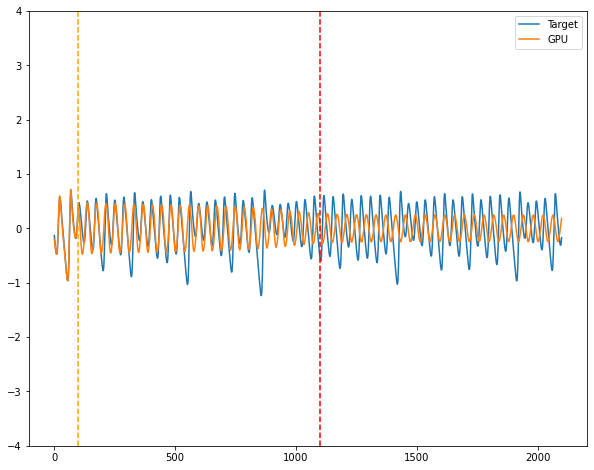

 Iter=32 a=0.971 sr=1.529 amp=1.000  ri=1.962 rr=1.345 loss=0.556228 nrmse=0.143794 CD 0.412434
Iter: 32 #### Time 6.30  NRMSE 0.144 CD 0.412
Iter: 33 #### Time 6.43  NRMSE 0.225 CD 1.104
Iter: 34 #### Time 5.40  NRMSE 1000.000 CD nan
Iter: 35 #### Time 5.93  NRMSE 1000.000 CD nan
Iter: 36 #### Time 6.15  NRMSE 0.188 CD 0.963
Iter: 37 #### Time 5.65  NRMSE 0.196 CD 0.968
Iter: 38 #### Time 6.12  NRMSE 0.225 CD 0.810
Iter: 39 #### Time 5.63  NRMSE 0.212 CD 0.985
Iter: 40 #### Time 7.02  NRMSE 1000.000 CD nan
Iter: 41 #### Time 5.79  NRMSE 1000.000 CD nan
Iter: 42 #### Time 5.90  NRMSE 0.219 CD 0.735
Iter: 43 #### Time 6.33  NRMSE 0.184 CD 0.907
Iter: 44 #### Time 5.63  NRMSE 0.238 CD 1.036
Iter: 45 #### Time 5.36  NRMSE 188.543 CD 1.002
Iter: 46 #### Time 5.75  NRMSE 1000.000 CD nan
Iter: 47 #### Time 7.08  NRMSE 0.222 CD 0.973
Iter: 48 #### Time 5.25  NRMSE 0.203 CD 0.978
Iter: 49 #### Time 7.15  NRMSE 0.293 CD 1.238
Iter: 50 #### Time 5.71  NRMSE 0.234 CD 0.788
Iter: 51 #### Time 5.61

End Run 4 Time 588.161

Best result = 0.6659098636610933
a = 0.7889609340110059
sr = 2.943953368723609
amp = 0.9077451301063841
ri = 3.7600934604694207

Best mn:0.971	 mn:0.971
New bounds mn--mx: 0.464--0.014

Best mn:1.529	 mn:1.529
New bounds mn--mx: 0.718--6.829

Best mn:1.000	 mn:1.000
New bounds mn--mx: 0.500--4.562

Best mn:1.962	 mn:1.962
New bounds mn--mx: 0.972--7.878

Best mn:1.345	 mn:1.345
New bounds mn--mx: 0.660--9.453
Refined search bounds:

Alpha (0.5075332385129141, 0.9856582385129142)

Rho (0.8114197584558445, 8.358294758455845)

Gamma (0.5000312499999999, 5.5625)

r-in (0.9904637508039834, 9.840463750803984)

r-res (0.6848487104826619, 10.797348710482662)

Overall best model [22, 4, 3, 32]
********** Size20 ref 0 -- Run 0 ***********
Iter: 0 #### Time 6.66  NRMSE 1000.000 CD nan
Iter: 1 #### Time 6.04  NRMSE 0.245 CD 1.092
Iter: 2 #### Time 6.97  NRMSE 1000.000 CD nan
Iter: 3 #### Time 5.60  NRMSE 0.212 CD 0.888
Iter: 4 #### Time 6.70  NRMSE 0.227 CD 0.951
Iter: 5 ##

Iter: 57 #### Time 5.70  NRMSE 0.227 CD 0.831
Iter: 58 #### Time 6.10  NRMSE 1000.000 CD nan
Iter: 59 #### Time 6.33  NRMSE 80927858486304800768.000 CD 0.992
Iter: 60 #### Time 6.17  NRMSE 0.183 CD 0.838
Iter: 61 #### Time 5.41  NRMSE 0.202 CD 0.981
Iter: 62 #### Time 6.55  NRMSE 0.196 CD 0.986
Iter: 63 #### Time 6.24  NRMSE 1000.000 CD nan
Iter: 64 #### Time 6.37  NRMSE 0.192 CD 0.952
Iter: 65 #### Time 6.13  NRMSE 0.294 CD 1.308
Iter: 66 #### Time 6.06  NRMSE 0.257 CD 1.064
Iter: 67 #### Time 5.65  NRMSE 1000.000 CD nan
Iter: 68 #### Time 6.77  NRMSE 1000.000 CD nan
Iter: 69 #### Time 6.62  NRMSE 0.183 CD 0.962
Iter: 70 #### Time 6.25  NRMSE 0.518 CD 0.993
Iter: 71 #### Time 7.17  NRMSE 0.173 CD 0.521
Iter: 72 #### Time 5.68  NRMSE 0.213 CD 0.984
Iter: 73 #### Time 6.54  NRMSE 0.222 CD 1.152
Iter: 74 #### Time 6.59  NRMSE 0.190 CD 0.968
Iter: 75 #### Time 5.43  NRMSE 0.269 CD 1.276
Iter: 76 #### Time 6.43  NRMSE 1000.000 CD nan
Iter: 77 #### Time 6.97  NRMSE 1000.000 CD 1.000
Iter: 7

Iter: 24 #### Time 5.23  NRMSE 0.212 CD 0.919
Iter: 25 #### Time 6.30  NRMSE 1000.000 CD nan
Iter: 26 #### Time 5.43  NRMSE 9962.808 CD 1.004
Iter: 27 #### Time 5.15  NRMSE 0.197 CD 0.978
Iter: 28 #### Time 6.38  NRMSE 0.247 CD 0.942
Iter: 29 #### Time 5.43  NRMSE 0.241 CD 1.072
Iter: 30 #### Time 6.75  NRMSE 0.230 CD 0.945
Iter: 31 #### Time 6.86  NRMSE 0.184 CD 0.980
Iter: 32 #### Time 5.83  NRMSE 0.224 CD 1.011
Iter: 33 #### Time 5.53  NRMSE 0.194 CD 0.991
Iter: 34 #### Time 5.80  NRMSE 0.221 CD 1.000
Iter: 35 #### Time 5.22  NRMSE 0.182 CD 0.954
Iter: 36 #### Time 6.65  NRMSE 1000.000 CD nan
Iter: 37 #### Time 5.54  NRMSE 0.196 CD 0.971
Iter: 38 #### Time 6.55  NRMSE 0.253 CD 1.111
Iter: 39 #### Time 6.74  NRMSE 0.224 CD 1.051
Iter: 40 #### Time 5.55  NRMSE 0.227 CD 1.083
Iter: 41 #### Time 6.33  NRMSE 0.196 CD 0.976
Iter: 42 #### Time 6.16  NRMSE 0.230 CD 1.077
Iter: 43 #### Time 5.66  NRMSE 1.965 CD 0.994
Iter: 44 #### Time 7.80  NRMSE 0.694 CD 0.958
Iter: 45 #### Time 5.72  NRMS

Iter: 97 #### Time 4.61  NRMSE 0.207 CD 0.968
Iter: 98 #### Time 4.80  NRMSE 2571366.247 CD 0.999
Iter: 99 #### Time 4.20  NRMSE 0.215 CD 0.975
End Run 4 Time 491.195

Best result = 0.5712335331161679
a = 0.8568967585903432
sr = 2.8773979431597057
amp = 3.181513527940645
ri = 3.6224777852407675
Refined search bounds:

Alpha (0.35, 1)

Rho (0.75, 4.5)

Gamma (0.0005, 3.0)

r-in (0.15, 5.25)

r-res (0.2, 6.0)

********** Size20 ref 1 -- Run 0 ***********
Iter: 0 #### Time 4.96  NRMSE 1000.000 CD 0.990
Iter: 1 #### Time 4.48  NRMSE 0.203 CD 0.982
Iter: 2 #### Time 4.63  NRMSE 0.200 CD 0.979
Iter: 3 #### Time 4.55  NRMSE 0.250 CD 0.984
Iter: 4 #### Time 4.53  NRMSE 0.189 CD 0.986
Iter: 5 #### Time 4.52  NRMSE 0.207 CD 1.003
Iter: 6 #### Time 4.58  NRMSE 0.223 CD 0.989
Iter: 7 #### Time 4.53  NRMSE 0.201 CD 0.992
Iter: 8 #### Time 4.53  NRMSE 0.182 CD 0.966
Iter: 9 #### Time 4.96  NRMSE 0.526 CD 0.989
Iter: 10 #### Time 4.44  NRMSE 0.195 CD 0.985
Iter: 11 #### Time 4.64  NRMSE 0.208 CD 1.10

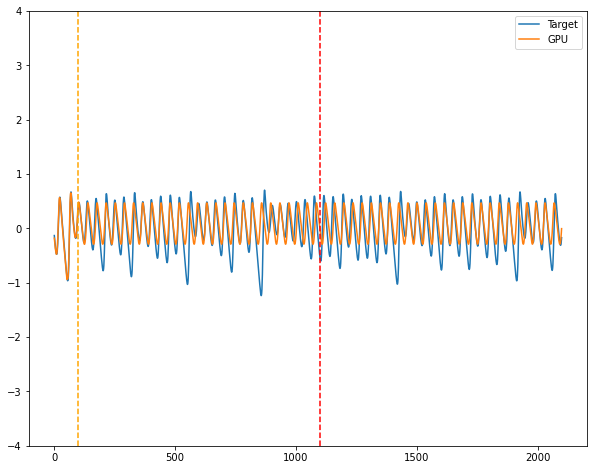

 Iter=43 a=0.923 sr=1.948 amp=1.000  ri=2.375 rr=3.937 loss=0.577329 nrmse=0.143185 CD 0.434144
Iter: 43 #### Time 4.90  NRMSE 0.143 CD 0.434
Iter: 44 #### Time 4.22  NRMSE 0.232 CD 1.053
Iter: 45 #### Time 4.21  NRMSE 0.199 CD 0.980
Iter: 46 #### Time 4.24  NRMSE 1000.000 CD nan
Iter: 47 #### Time 4.28  NRMSE 0.235 CD 0.983
Iter: 48 #### Time 4.42  NRMSE 0.201 CD 1.007
Iter: 49 #### Time 4.23  NRMSE 0.292 CD 1.224
Iter: 50 #### Time 4.23  NRMSE 0.215 CD 1.019
Iter: 51 #### Time 4.20  NRMSE 1000.000 CD nan
Iter: 52 #### Time 4.17  NRMSE 0.217 CD 1.085
Iter: 53 #### Time 4.26  NRMSE 0.229 CD 0.971
Iter: 54 #### Time 4.45  NRMSE 0.225 CD 0.831
Iter: 55 #### Time 4.38  NRMSE 1000.000 CD nan
Iter: 56 #### Time 4.34  NRMSE 0.275 CD 1.176
Iter: 57 #### Time 4.38  NRMSE 753770778.441 CD 1.010
Iter: 58 #### Time 4.36  NRMSE 1000.000 CD nan
Iter: 59 #### Time 4.35  NRMSE 1000.000 CD nan
Iter: 60 #### Time 4.55  NRMSE 1000.000 CD nan
Iter: 61 #### Time 4.48  NRMSE 749978.103 CD 0.999
Iter: 62 ##

Iter: 9 #### Time 4.45  NRMSE 0.227 CD 0.971
Iter: 10 #### Time 4.33  NRMSE 0.194 CD 0.970
Iter: 11 #### Time 4.32  NRMSE 0.178 CD 0.869
Iter: 12 #### Time 4.25  NRMSE 0.244 CD 0.977
Iter: 13 #### Time 4.31  NRMSE 0.191 CD 0.962
Iter: 14 #### Time 4.33  NRMSE 0.461 CD 0.985
Iter: 15 #### Time 4.78  NRMSE 0.228 CD 0.794
Iter: 16 #### Time 4.40  NRMSE 0.242 CD 1.058
Iter: 17 #### Time 4.40  NRMSE 0.522 CD 1.001
Iter: 18 #### Time 4.44  NRMSE 0.212 CD 0.985
Iter: 19 #### Time 4.32  NRMSE 0.236 CD 1.172
Iter: 20 #### Time 4.58  NRMSE 0.190 CD 0.976
Iter: 21 #### Time 4.28  NRMSE 1000.000 CD nan
Iter: 22 #### Time 4.29  NRMSE 1000.000 CD nan
Iter: 23 #### Time 4.26  NRMSE 0.193 CD 0.849
Iter: 24 #### Time 4.27  NRMSE 0.203 CD 0.829
Iter: 25 #### Time 4.35  NRMSE 1000.000 CD nan
Iter: 26 #### Time 4.28  NRMSE 0.256 CD 1.106
Iter: 27 #### Time 4.44  NRMSE 0.191 CD 0.971
Iter: 28 #### Time 4.25  NRMSE 775794528580498845633347584.000 CD 1.000
Iter: 29 #### Time 4.44  NRMSE 1000.000 CD nan
Iter:

Iter: 80 #### Time 4.38  NRMSE 0.227 CD 1.047
Iter: 81 #### Time 4.29  NRMSE 1000.000 CD 1.001
Iter: 82 #### Time 4.31  NRMSE 0.197 CD 0.977
Iter: 83 #### Time 4.41  NRMSE 1000.000 CD 1.001
Iter: 84 #### Time 4.55  NRMSE 0.213 CD 0.961
Iter: 85 #### Time 4.25  NRMSE 0.181 CD 0.932
Iter: 86 #### Time 4.30  NRMSE 0.200 CD 0.980
Iter: 87 #### Time 4.42  NRMSE 0.201 CD 0.983
Iter: 88 #### Time 4.49  NRMSE 1000.000 CD nan
Iter: 89 #### Time 4.47  NRMSE 0.191 CD 0.977
Iter: 90 #### Time 4.47  NRMSE 0.200 CD 0.994
Iter: 91 #### Time 4.49  NRMSE 0.199 CD 0.902
Iter: 92 #### Time 4.25  NRMSE 1000.000 CD nan
Iter: 93 #### Time 4.21  NRMSE 0.238 CD 0.964
Iter: 94 #### Time 4.25  NRMSE 0.179 CD 0.730
Iter: 95 #### Time 4.37  NRMSE 1000.000 CD nan
Iter: 96 #### Time 4.40  NRMSE 0.194 CD 0.924
Iter: 97 #### Time 4.22  NRMSE 0.192 CD 0.969
Iter: 98 #### Time 4.39  NRMSE 0.255 CD 1.050
Iter: 99 #### Time 4.30  NRMSE 0.230 CD 1.028
End Run 4 Time 445.008

Best result = 0.6231328147968165
a = 0.94004840

Iter: 38 #### Time 4.26  NRMSE 0.256 CD 1.063
Iter: 39 #### Time 4.26  NRMSE 0.211 CD 0.623
Iter: 40 #### Time 4.25  NRMSE 1000.000 CD nan
Iter: 41 #### Time 4.43  NRMSE 0.212 CD 1.003
Iter: 42 #### Time 4.35  NRMSE 0.193 CD 0.970
Iter: 43 #### Time 4.34  NRMSE 0.186 CD 0.756
Iter: 44 #### Time 4.43  NRMSE 0.231 CD 0.936
Iter: 45 #### Time 4.30  NRMSE 0.182 CD 0.891
Iter: 46 #### Time 4.33  NRMSE 1000.000 CD nan
Iter: 47 #### Time 4.22  NRMSE 1000.000 CD nan
Iter: 48 #### Time 4.26  NRMSE 0.198 CD 0.962
Iter: 49 #### Time 4.35  NRMSE 0.199 CD 0.664
Iter: 50 #### Time 4.35  NRMSE 0.275 CD 1.193
Iter: 51 #### Time 4.26  NRMSE 0.198 CD 0.908
Iter: 52 #### Time 4.40  NRMSE 0.243 CD 0.909
Iter: 53 #### Time 4.33  NRMSE 0.211 CD 1.001
Iter: 54 #### Time 4.27  NRMSE 0.250 CD 1.028
Iter: 55 #### Time 4.34  NRMSE 0.238 CD 0.719
Iter: 56 #### Time 4.35  NRMSE 0.193 CD 0.959
Iter: 57 #### Time 4.45  NRMSE 0.211 CD 1.053
Iter: 58 #### Time 4.35  NRMSE 1000.000 CD nan
Iter: 59 #### Time 4.26  NRMSE

Iter: 6 #### Time 4.34  NRMSE 0.187 CD 0.930
Iter: 7 #### Time 4.52  NRMSE 0.206 CD 1.009
Iter: 8 #### Time 4.35  NRMSE 1000.000 CD nan
Iter: 9 #### Time 4.30  NRMSE 0.181 CD 0.516
Iter: 10 #### Time 4.38  NRMSE 0.229 CD 0.883
Iter: 11 #### Time 4.37  NRMSE 0.184 CD 0.992
Iter: 12 #### Time 4.38  NRMSE 1000.000 CD 1.008
Iter: 13 #### Time 4.50  NRMSE 0.184 CD 0.869
Iter: 14 #### Time 4.38  NRMSE 0.197 CD 0.979
Iter: 15 #### Time 4.38  NRMSE 0.222 CD 1.076
Iter: 16 #### Time 4.21  NRMSE 0.217 CD 0.992
Iter: 17 #### Time 4.20  NRMSE 1000.000 CD nan
Iter: 18 #### Time 4.22  NRMSE 25.527 CD 1.000
Iter: 19 #### Time 4.19  NRMSE 0.234 CD 0.734
Iter: 20 #### Time 4.36  NRMSE 0.235 CD 1.031
Iter: 21 #### Time 4.20  NRMSE 0.202 CD 0.967
Iter: 22 #### Time 4.34  NRMSE 0.204 CD 0.986
Iter: 23 #### Time 4.34  NRMSE 0.178 CD 0.539
Iter: 24 #### Time 4.26  NRMSE 0.213 CD 0.921
Iter: 25 #### Time 4.31  NRMSE 0.187 CD 0.563
Iter: 26 #### Time 4.26  NRMSE 0.183 CD 0.924
Iter: 27 #### Time 4.42  NRMSE 0

Iter: 77 #### Time 4.21  NRMSE 1000.000 CD nan
Iter: 78 #### Time 4.23  NRMSE 0.500 CD 1.000
Iter: 79 #### Time 4.36  NRMSE 0.297 CD 1.132
Iter: 80 #### Time 4.37  NRMSE 0.291 CD 0.992
Iter: 81 #### Time 4.34  NRMSE 0.177 CD 0.836
Iter: 82 #### Time 4.31  NRMSE 57.596 CD 0.913
Iter: 83 #### Time 4.25  NRMSE 0.166 CD 0.461
Iter: 84 #### Time 4.13  NRMSE 0.467 CD 0.995
Iter: 85 #### Time 4.30  NRMSE 0.418 CD 1.020
Iter: 86 #### Time 4.45  NRMSE 1000.000 CD nan
Iter: 87 #### Time 4.31  NRMSE 1000.000 CD nan
Iter: 88 #### Time 4.26  NRMSE 1000.000 CD nan
Iter: 89 #### Time 4.26  NRMSE 0.185 CD 0.932
Iter: 90 #### Time 4.40  NRMSE 1000.000 CD nan
Iter: 91 #### Time 4.32  NRMSE 0.505 CD 1.000
Iter: 92 #### Time 4.32  NRMSE 0.188 CD 0.772
Iter: 93 #### Time 4.36  NRMSE 0.753 CD 1.011
Iter: 94 #### Time 4.35  NRMSE 1000.000 CD nan
Iter: 95 #### Time 4.37  NRMSE 1000.000 CD nan
Iter: 96 #### Time 4.29  NRMSE 246943859348117818148915249152.000 CD 1.008
Iter: 97 #### Time 4.28  NRMSE 0.191 CD 0.9

Iter: 40 #### Time 4.21  NRMSE 1000.000 CD nan
Iter: 41 #### Time 4.44  NRMSE 1000.000 CD nan
Iter: 42 #### Time 4.29  NRMSE 0.212 CD 0.781
Iter: 43 #### Time 4.29  NRMSE 1000.000 CD nan
Iter: 44 #### Time 4.45  NRMSE 0.193 CD 0.898
Iter: 45 #### Time 4.43  NRMSE 0.211 CD 1.075
Iter: 46 #### Time 4.36  NRMSE 0.414 CD 1.058
Iter: 47 #### Time 4.37  NRMSE 0.186 CD 0.887
Iter: 48 #### Time 4.31  NRMSE 0.206 CD 0.850
Iter: 49 #### Time 4.23  NRMSE 47914935799017112.000 CD 0.997
Iter: 50 #### Time 4.23  NRMSE 0.519 CD 0.996
Iter: 51 #### Time 4.19  NRMSE 0.181 CD 0.943
Iter: 52 #### Time 4.25  NRMSE 1000.000 CD nan
Iter: 53 #### Time 4.39  NRMSE 0.275 CD 1.156
Iter: 54 #### Time 4.36  NRMSE 1000.000 CD nan
Iter: 55 #### Time 4.38  NRMSE 1000.000 CD nan
Iter: 56 #### Time 4.39  NRMSE 0.199 CD 0.968
Iter: 57 #### Time 4.33  NRMSE 0.222 CD 0.990
Iter: 58 #### Time 4.39  NRMSE 1000.000 CD nan
Iter: 59 #### Time 4.26  NRMSE 1000.000 CD nan
Iter: 60 #### Time 4.18  NRMSE 0.209 CD 0.979
Iter: 61 #

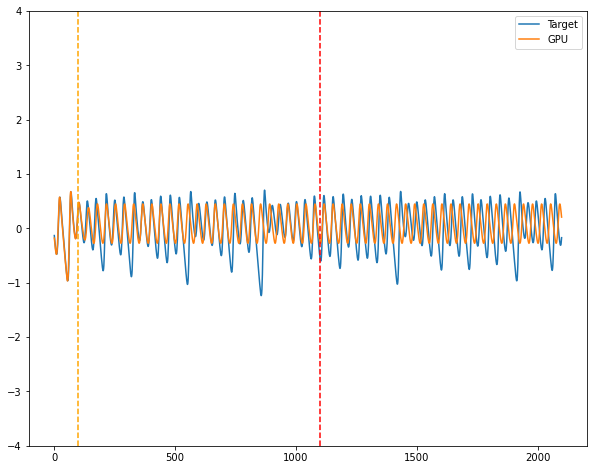

 Iter=44 a=0.938 sr=2.071 amp=1.000  ri=1.605 rr=0.780 loss=0.619719 nrmse=0.146680 CD 0.473038
Iter: 44 #### Time 5.13  NRMSE 0.147 CD 0.473
Iter: 45 #### Time 4.80  NRMSE 0.191 CD 0.912
Iter: 46 #### Time 4.42  NRMSE 29521841.784 CD 0.995
Iter: 47 #### Time 4.74  NRMSE 0.202 CD 0.964
Iter: 48 #### Time 4.37  NRMSE 1000.000 CD nan
Iter: 49 #### Time 4.67  NRMSE 1000.000 CD nan
Iter: 50 #### Time 4.65  NRMSE 1000.000 CD nan
Iter: 51 #### Time 4.53  NRMSE 0.232 CD 1.050
Iter: 52 #### Time 4.82  NRMSE 0.215 CD 0.997
Iter: 53 #### Time 4.78  NRMSE 0.202 CD 0.965
Iter: 54 #### Time 4.31  NRMSE 8697989675.350 CD 1.004
Iter: 55 #### Time 4.71  NRMSE 0.227 CD 0.929
Iter: 56 #### Time 4.63  NRMSE 0.186 CD 0.962
Iter: 57 #### Time 4.48  NRMSE 0.239 CD 1.100
Iter: 58 #### Time 5.40  NRMSE 0.201 CD 0.985
Iter: 59 #### Time 4.65  NRMSE 1000.000 CD nan
Iter: 60 #### Time 4.64  NRMSE 0.523 CD 0.989
Iter: 61 #### Time 4.73  NRMSE 0.202 CD 0.971
Iter: 62 #### Time 4.39  NRMSE 0.179 CD 0.728
Iter: 63 #

Iter: 8 #### Time 4.86  NRMSE 0.202 CD 0.990
Iter: 9 #### Time 4.52  NRMSE 0.253 CD 1.083
Iter: 10 #### Time 4.33  NRMSE 0.249 CD 1.026
Iter: 11 #### Time 4.82  NRMSE 0.236 CD 0.828
Iter: 12 #### Time 4.39  NRMSE 0.213 CD 0.662
Iter: 13 #### Time 4.69  NRMSE 87675.719 CD 0.998
Iter: 14 #### Time 4.39  NRMSE 0.208 CD 0.928
Iter: 15 #### Time 4.57  NRMSE 0.157 CD 0.484
Iter: 16 #### Time 4.56  NRMSE 0.183 CD 0.952
Iter: 17 #### Time 4.33  NRMSE 0.200 CD 0.983
Iter: 18 #### Time 4.47  NRMSE 0.229 CD 0.948
Iter: 19 #### Time 4.43  NRMSE 212394669150149383477526528.000 CD 0.969
Iter: 20 #### Time 4.41  NRMSE 0.261 CD 0.990
Iter: 21 #### Time 4.29  NRMSE 0.203 CD 0.930
Iter: 22 #### Time 5.14  NRMSE 1000.000 CD nan
Iter: 23 #### Time 5.49  NRMSE 0.202 CD 1.016
Iter: 24 #### Time 4.28  NRMSE 1000.000 CD nan
Iter: 25 #### Time 4.94  NRMSE 0.191 CD 0.980
Iter: 26 #### Time 4.51  NRMSE 1000.000 CD nan
Iter: 27 #### Time 4.34  NRMSE 0.182 CD 0.951
Iter: 28 #### Time 4.92  NRMSE 1000.000 CD nan
It

Iter: 69 #### Time 4.36  NRMSE 0.195 CD 0.948
Iter: 70 #### Time 4.32  NRMSE 1000.000 CD nan
Iter: 71 #### Time 4.25  NRMSE 0.170 CD 0.481
Iter: 72 #### Time 4.45  NRMSE 0.221 CD 0.988
Iter: 73 #### Time 4.38  NRMSE 0.248 CD 1.091
Iter: 74 #### Time 4.27  NRMSE 0.193 CD 0.983
Iter: 75 #### Time 4.27  NRMSE 0.196 CD 0.982
Iter: 76 #### Time 4.33  NRMSE 0.210 CD 0.947
Iter: 77 #### Time 4.27  NRMSE 0.186 CD 0.963
Iter: 78 #### Time 4.35  NRMSE 1000.000 CD nan
Iter: 79 #### Time 4.35  NRMSE 0.197 CD 0.640
Iter: 80 #### Time 4.41  NRMSE 0.533 CD 0.989
Iter: 81 #### Time 4.86  NRMSE 0.200 CD 0.975
Iter: 82 #### Time 4.67  NRMSE 0.207 CD 0.686
Iter: 83 #### Time 4.52  NRMSE 0.271 CD 1.151
Iter: 84 #### Time 4.99  NRMSE 0.196 CD 0.974
Iter: 85 #### Time 4.55  NRMSE 1000.000 CD nan
Iter: 86 #### Time 4.58  NRMSE 0.187 CD 0.974
Iter: 87 #### Time 4.61  NRMSE 0.841 CD 0.986
Iter: 88 #### Time 4.48  NRMSE 0.203 CD 0.751
Iter: 89 #### Time 4.92  NRMSE 0.224 CD 0.981
Iter: 90 #### Time 4.81  NRMSE 

Iter: 38 #### Time 4.33  NRMSE 0.238 CD 1.151
Iter: 39 #### Time 4.42  NRMSE 1000.000 CD nan
Iter: 40 #### Time 4.25  NRMSE 0.201 CD 0.967
Iter: 41 #### Time 4.22  NRMSE 0.187 CD 0.969
Iter: 42 #### Time 4.30  NRMSE 0.455 CD 0.991
Iter: 43 #### Time 4.20  NRMSE 0.212 CD 0.928
Iter: 44 #### Time 4.30  NRMSE 0.383 CD 1.006
Iter: 45 #### Time 4.43  NRMSE 0.224 CD 0.946
Iter: 46 #### Time 4.70  NRMSE 1000.000 CD nan
Iter: 47 #### Time 4.34  NRMSE 0.210 CD 0.984
Iter: 48 #### Time 4.24  NRMSE 0.241 CD 0.972
Iter: 49 #### Time 4.43  NRMSE 0.200 CD 0.996
Iter: 50 #### Time 4.38  NRMSE 1000.000 CD nan
Iter: 51 #### Time 4.35  NRMSE 0.185 CD 0.958
Iter: 52 #### Time 4.45  NRMSE 1000.000 CD nan
Iter: 53 #### Time 4.27  NRMSE 1000.000 CD 0.984
Iter: 54 #### Time 4.24  NRMSE 0.520 CD 0.988
Iter: 55 #### Time 4.23  NRMSE 1000.000 CD nan
Iter: 56 #### Time 4.21  NRMSE 0.179 CD 0.906
Iter: 57 #### Time 4.23  NRMSE 1000.000 CD nan
Iter: 58 #### Time 4.24  NRMSE 0.182 CD 0.937
Iter: 59 #### Time 5.09  

Iter: 6 #### Time 4.34  NRMSE 0.242 CD 1.004
Iter: 7 #### Time 4.30  NRMSE 1000.000 CD nan
Iter: 8 #### Time 4.29  NRMSE 0.227 CD 0.882
Iter: 9 #### Time 4.36  NRMSE 0.235 CD 1.001
Iter: 10 #### Time 4.24  NRMSE 0.224 CD 0.848
Iter: 11 #### Time 4.45  NRMSE 0.217 CD 0.990
Iter: 12 #### Time 4.22  NRMSE 1000.000 CD nan
Iter: 13 #### Time 4.20  NRMSE 0.205 CD 0.970
Iter: 14 #### Time 4.24  NRMSE 1000.000 CD nan
Iter: 15 #### Time 4.33  NRMSE 0.219 CD 0.994
Iter: 16 #### Time 4.26  NRMSE 0.194 CD 0.966
Iter: 17 #### Time 4.27  NRMSE 0.187 CD 0.960
Iter: 18 #### Time 4.21  NRMSE 0.200 CD 0.984
Iter: 19 #### Time 4.26  NRMSE 1000.000 CD nan
Iter: 20 #### Time 4.23  NRMSE 0.213 CD 0.988
Iter: 21 #### Time 4.28  NRMSE 1000.000 CD 0.989
Iter: 22 #### Time 4.21  NRMSE 0.191 CD 0.978
Iter: 23 #### Time 4.42  NRMSE 0.516 CD 0.989
Iter: 24 #### Time 4.34  NRMSE 0.197 CD 0.986
Iter: 25 #### Time 4.29  NRMSE 0.202 CD 1.007
Iter: 26 #### Time 4.26  NRMSE 0.225 CD 1.085
Iter: 27 #### Time 4.30  NRMSE 

Iter: 73 #### Time 4.35  NRMSE 0.204 CD 0.959
Iter: 74 #### Time 4.24  NRMSE 0.192 CD 0.987
Iter: 75 #### Time 4.36  NRMSE 1000.000 CD 1.002
Iter: 76 #### Time 4.37  NRMSE 1000.000 CD nan
Iter: 77 #### Time 4.23  NRMSE 1000.000 CD nan
Iter: 78 #### Time 4.38  NRMSE 0.199 CD 0.964
Iter: 79 #### Time 4.28  NRMSE 0.196 CD 0.974
Iter: 80 #### Time 4.27  NRMSE 0.231 CD 0.939
Iter: 81 #### Time 4.26  NRMSE 0.199 CD 0.979
Iter: 82 #### Time 4.26  NRMSE 1000.000 CD nan
Iter: 83 #### Time 4.24  NRMSE 0.247 CD 1.074
Iter: 84 #### Time 4.36  NRMSE 0.198 CD 0.803
Iter: 85 #### Time 4.36  NRMSE 0.188 CD 0.894
Iter: 86 #### Time 4.35  NRMSE 0.207 CD 0.982
Iter: 87 #### Time 4.28  NRMSE 0.552 CD 0.921
Iter: 88 #### Time 4.20  NRMSE 0.210 CD 0.796
Iter: 89 #### Time 4.22  NRMSE 0.210 CD 0.887
Iter: 90 #### Time 4.29  NRMSE 0.232 CD 0.948
Iter: 91 #### Time 4.22  NRMSE 0.248 CD 0.979
Iter: 92 #### Time 4.53  NRMSE 0.246 CD 1.018
Iter: 93 #### Time 4.26  NRMSE 1000.000 CD nan
Iter: 94 #### Time 4.37  NR

Iter: 42 #### Time 4.55  NRMSE 0.193 CD 0.984
Iter: 43 #### Time 4.35  NRMSE 0.231 CD 0.945
Iter: 44 #### Time 4.26  NRMSE 0.194 CD 0.961
Iter: 45 #### Time 4.17  NRMSE 0.236 CD 0.969
Iter: 46 #### Time 4.25  NRMSE 1000.000 CD nan
Iter: 47 #### Time 4.43  NRMSE 0.197 CD 0.960
Iter: 48 #### Time 4.27  NRMSE 0.248 CD 1.048
Iter: 49 #### Time 4.26  NRMSE 0.273 CD 1.176
Iter: 50 #### Time 4.33  NRMSE 0.192 CD 0.799
Iter: 51 #### Time 4.41  NRMSE 0.191 CD 0.956
Iter: 52 #### Time 4.29  NRMSE 0.245 CD 1.110
Iter: 53 #### Time 4.28  NRMSE 0.182 CD 0.936
Iter: 54 #### Time 4.25  NRMSE 0.225 CD 0.854
Iter: 55 #### Time 4.38  NRMSE 0.193 CD 0.971
Iter: 56 #### Time 4.27  NRMSE 0.232 CD 0.902
Iter: 57 #### Time 4.19  NRMSE 1000.000 CD nan
Iter: 58 #### Time 4.21  NRMSE 0.489 CD 1.011
Iter: 59 #### Time 4.18  NRMSE 1000.000 CD nan
Iter: 60 #### Time 4.25  NRMSE 0.213 CD 1.094
Iter: 61 #### Time 4.40  NRMSE 0.217 CD 0.979
Iter: 62 #### Time 4.25  NRMSE 1000.000 CD nan
Dist 0.458982


New N best!!!!

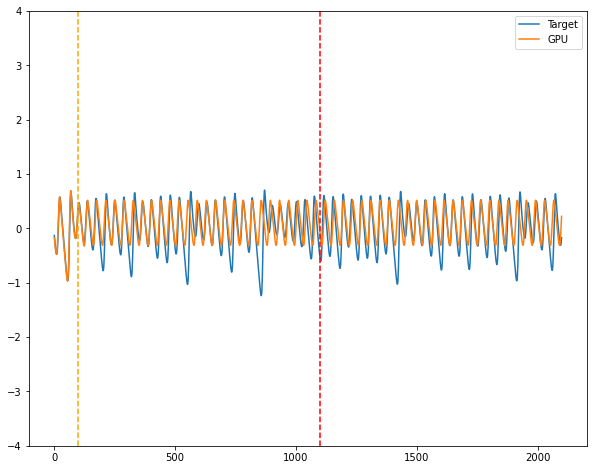

 Iter=63 a=0.953 sr=2.426 amp=1.000  ri=3.482 rr=1.603 loss=0.607255 nrmse=0.148273 CD 0.458982
Iter: 63 #### Time 4.79  NRMSE 0.148 CD 0.459
Iter: 64 #### Time 4.36  NRMSE 0.520 CD 0.993
Iter: 65 #### Time 4.38  NRMSE 0.221 CD 0.862
Iter: 66 #### Time 4.23  NRMSE 0.193 CD 0.661
Iter: 67 #### Time 4.30  NRMSE 0.199 CD 0.992
Iter: 68 #### Time 4.30  NRMSE 0.241 CD 1.007
Iter: 69 #### Time 4.20  NRMSE 37.439 CD 0.998
Iter: 70 #### Time 4.22  NRMSE 0.530 CD 1.000
Iter: 71 #### Time 4.22  NRMSE 0.230 CD 1.003
Iter: 72 #### Time 4.23  NRMSE 0.414 CD 0.942
Iter: 73 #### Time 4.19  NRMSE 0.241 CD 1.117
Iter: 74 #### Time 4.23  NRMSE 0.529 CD 0.997
Iter: 75 #### Time 4.36  NRMSE 1000.000 CD nan
Iter: 76 #### Time 4.23  NRMSE 0.181 CD 0.911
Iter: 77 #### Time 4.41  NRMSE 0.222 CD 1.059
Iter: 78 #### Time 4.42  NRMSE 0.182 CD 0.952
Iter: 79 #### Time 4.42  NRMSE 1000.000 CD nan
Iter: 80 #### Time 4.33  NRMSE 0.212 CD 0.966
Iter: 81 #### Time 4.31  NRMSE 0.205 CD 0.939
Iter: 82 #### Time 4.35  NR

Iter: 29 #### Time 4.27  NRMSE 0.232 CD 1.089
Iter: 30 #### Time 4.23  NRMSE 0.214 CD 0.974
Iter: 31 #### Time 4.26  NRMSE 1000.000 CD nan
Iter: 32 #### Time 4.20  NRMSE 0.186 CD 0.914
Iter: 33 #### Time 4.26  NRMSE 0.226 CD 1.096
Iter: 34 #### Time 4.21  NRMSE 235.308 CD 1.017
Iter: 35 #### Time 4.43  NRMSE 0.212 CD 0.814
Iter: 36 #### Time 4.25  NRMSE 0.213 CD 1.036
Iter: 37 #### Time 4.17  NRMSE 0.313 CD 1.010
Iter: 38 #### Time 4.40  NRMSE 0.186 CD 0.957
Iter: 39 #### Time 4.18  NRMSE 1000.000 CD nan
Iter: 40 #### Time 4.28  NRMSE 0.511 CD 0.986
Iter: 41 #### Time 4.19  NRMSE 0.187 CD 0.919
Iter: 42 #### Time 4.29  NRMSE 0.198 CD 0.971
Iter: 43 #### Time 4.29  NRMSE 1000.000 CD nan
Iter: 44 #### Time 4.28  NRMSE 0.247 CD 1.018
Iter: 45 #### Time 4.51  NRMSE 1000.000 CD nan
Iter: 46 #### Time 4.22  NRMSE 0.221 CD 0.964
Iter: 47 #### Time 4.21  NRMSE 0.184 CD 0.893
Iter: 48 #### Time 4.18  NRMSE 0.227 CD 1.030
Iter: 49 #### Time 4.39  NRMSE 1000.000 CD nan
Iter: 50 #### Time 4.25  NR

Iter: 88 #### Time 4.19  NRMSE 0.190 CD 0.982
Iter: 89 #### Time 4.24  NRMSE 0.189 CD 0.953
Iter: 90 #### Time 4.27  NRMSE 0.178 CD 0.875
Iter: 91 #### Time 4.27  NRMSE 1000.000 CD nan
Iter: 92 #### Time 4.37  NRMSE 0.381 CD 1.227
Iter: 93 #### Time 4.21  NRMSE 0.200 CD 0.973
Iter: 94 #### Time 4.22  NRMSE 1000.000 CD nan
Iter: 95 #### Time 4.18  NRMSE 1000.000 CD nan
Iter: 96 #### Time 4.20  NRMSE 1000.000 CD 1.000
Iter: 97 #### Time 4.23  NRMSE 0.191 CD 0.955
Iter: 98 #### Time 4.39  NRMSE 0.239 CD 1.079
Iter: 99 #### Time 4.22  NRMSE 5442763757859944.000 CD 1.004
End Run 0 Time 451.554

Best result = 0.6383360495993312
a = 0.8236921949051605
sr = 1.7791304337276976
amp = 2.4502173175802864
ri = 2.167256976244987
********** Size18 ref 1 -- Run 1 ***********
Iter: 0 #### Time 4.34  NRMSE 0.183 CD 0.957
Iter: 1 #### Time 4.25  NRMSE 0.189 CD 0.940
Iter: 2 #### Time 4.24  NRMSE 0.240 CD 1.070
Iter: 3 #### Time 4.25  NRMSE 0.187 CD 0.958
Iter: 4 #### Time 4.23  NRMSE 0.186 CD 0.945
Iter:

Iter: 56 #### Time 4.15  NRMSE 846.969 CD 1.003
Iter: 57 #### Time 4.17  NRMSE 0.245 CD 1.081
Iter: 58 #### Time 4.17  NRMSE 0.229 CD 0.781
Iter: 59 #### Time 4.18  NRMSE 1000.000 CD nan
Iter: 60 #### Time 4.29  NRMSE 1000.000 CD nan
Iter: 61 #### Time 4.23  NRMSE 0.267 CD 1.113
Iter: 62 #### Time 4.19  NRMSE 0.208 CD 0.994
Iter: 63 #### Time 4.18  NRMSE 0.208 CD 0.985
Iter: 64 #### Time 4.14  NRMSE 0.204 CD 1.352
Iter: 65 #### Time 4.15  NRMSE 1000.000 CD nan
Iter: 66 #### Time 4.18  NRMSE 0.209 CD 0.943
Iter: 67 #### Time 4.16  NRMSE 1000.000 CD nan
Iter: 68 #### Time 4.20  NRMSE 0.201 CD 0.979
Iter: 69 #### Time 4.19  NRMSE 0.213 CD 1.041
Iter: 70 #### Time 4.15  NRMSE 274657.177 CD 1.001
Iter: 71 #### Time 4.18  NRMSE 0.205 CD 0.978
Iter: 72 #### Time 4.18  NRMSE 0.229 CD 1.016
Iter: 73 #### Time 4.23  NRMSE 0.226 CD 0.986
Iter: 74 #### Time 4.17  NRMSE 0.520 CD 0.997
Iter: 75 #### Time 4.18  NRMSE 2.562 CD 0.996
Iter: 76 #### Time 4.22  NRMSE 0.248 CD 1.116
Iter: 77 #### Time 4.19

Iter: 25 #### Time 4.15  NRMSE 0.198 CD 0.908
Iter: 26 #### Time 4.12  NRMSE 0.233 CD 0.900
Iter: 27 #### Time 4.25  NRMSE 0.190 CD 0.934
Iter: 28 #### Time 4.17  NRMSE 1000.000 CD nan
Iter: 29 #### Time 4.14  NRMSE 0.499 CD 1.006
Iter: 30 #### Time 4.13  NRMSE 0.185 CD 0.959
Iter: 31 #### Time 4.13  NRMSE 0.183 CD 0.858
Iter: 32 #### Time 4.14  NRMSE 0.228 CD 0.942
Iter: 33 #### Time 4.14  NRMSE 0.200 CD 0.980
Iter: 34 #### Time 4.17  NRMSE 1000.000 CD nan
Iter: 35 #### Time 4.16  NRMSE 1000.000 CD nan
Iter: 36 #### Time 4.15  NRMSE 0.204 CD 0.990
Iter: 37 #### Time 4.32  NRMSE 0.182 CD 0.971
Iter: 38 #### Time 4.13  NRMSE 0.536 CD 1.007
Iter: 39 #### Time 4.17  NRMSE 0.202 CD 0.980
Iter: 40 #### Time 4.26  NRMSE 1000.000 CD 1.005
Iter: 41 #### Time 4.30  NRMSE 0.191 CD 0.973
Iter: 42 #### Time 4.22  NRMSE 0.174 CD 0.482
Iter: 43 #### Time 4.16  NRMSE 0.186 CD 0.783
Iter: 44 #### Time 4.18  NRMSE 0.197 CD 0.971
Iter: 45 #### Time 4.26  NRMSE 0.527 CD 1.000
Iter: 46 #### Time 4.17  NRM

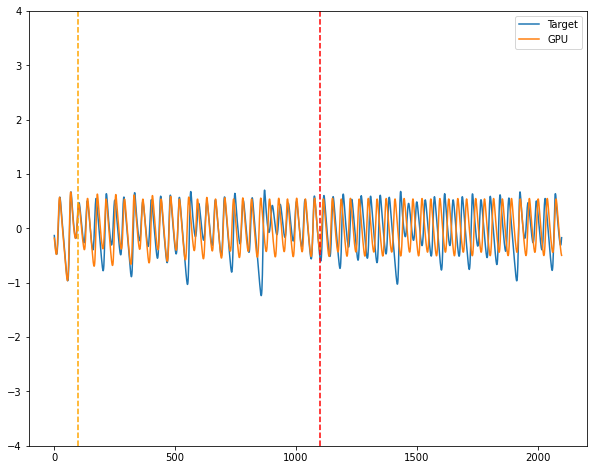

 Iter=93 a=0.760 sr=1.756 amp=1.000  ri=2.386 rr=2.503 loss=0.545349 nrmse=0.149649 CD 0.395700
Iter: 93 #### Time 4.71  NRMSE 0.150 CD 0.396
Iter: 94 #### Time 4.12  NRMSE 0.270 CD 1.035
Iter: 95 #### Time 4.14  NRMSE 1000.000 CD nan
Iter: 96 #### Time 4.18  NRMSE 0.536 CD 0.996
Iter: 97 #### Time 4.18  NRMSE 0.181 CD 0.947
Iter: 98 #### Time 4.16  NRMSE 0.213 CD 0.970
Iter: 99 #### Time 4.12  NRMSE 0.208 CD 1.000
End Run 4 Time 423.631

Best result = 0.5453487653407263
a = 0.7596416916440414
sr = 1.7559599795470529
amp = 2.386313638541183
ri = 2.503072577537063

Best mn:0.760	 mn:0.760
New bounds mn--mx: -0.034--0.109

Best mn:1.756	 mn:1.756
New bounds mn--mx: -0.104--0.479

Best mn:1.000	 mn:1.000
New bounds mn--mx: 0.250--0.250

Best mn:2.386	 mn:2.386
New bounds mn--mx: 0.248--0.552

Best mn:2.503	 mn:2.503
New bounds mn--mx: 0.751--0.149
Refined search bounds:

Alpha (0.7931543696352772, 0.8681543696352771)

Rho (1.859484225559986, 2.234484225559986)

Gamma (0.75025, 1.25)

r-in

Iter: 48 #### Time 4.30  NRMSE 0.217 CD 1.098
Iter: 49 #### Time 4.25  NRMSE 1000.000 CD nan
Iter: 50 #### Time 4.13  NRMSE 0.221 CD 0.986
Iter: 51 #### Time 4.24  NRMSE 18.484 CD 1.003
Iter: 52 #### Time 4.18  NRMSE 0.284 CD 1.134
Iter: 53 #### Time 4.22  NRMSE 1000.000 CD nan
Iter: 54 #### Time 4.36  NRMSE 0.190 CD 0.973
Iter: 55 #### Time 4.23  NRMSE 1000.000 CD nan
Iter: 56 #### Time 4.16  NRMSE 1000.000 CD 0.985
Iter: 57 #### Time 4.13  NRMSE 0.278 CD 1.202
Iter: 58 #### Time 4.15  NRMSE 1000.000 CD nan
Iter: 59 #### Time 4.16  NRMSE 0.195 CD 0.994
Iter: 60 #### Time 4.14  NRMSE 0.200 CD 0.635
Iter: 61 #### Time 4.11  NRMSE 1000.000 CD nan
Iter: 62 #### Time 4.13  NRMSE 0.488 CD 0.987
Iter: 63 #### Time 4.16  NRMSE 1000.000 CD nan
Iter: 64 #### Time 4.37  NRMSE 0.191 CD 0.917
Iter: 65 #### Time 4.23  NRMSE 0.220 CD 0.925
Iter: 66 #### Time 4.16  NRMSE 0.295 CD 0.880
Iter: 67 #### Time 4.16  NRMSE 1563780392231.521 CD 1.032
Iter: 68 #### Time 4.18  NRMSE 0.224 CD 0.644
Iter: 69 ###

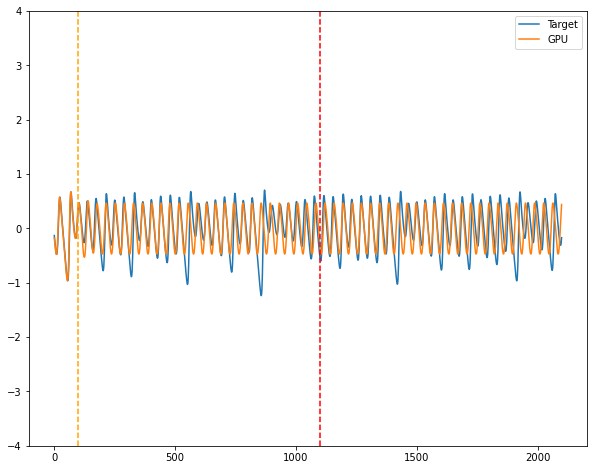

 Iter=91 a=0.830 sr=1.819 amp=1.000  ri=3.152 rr=3.731 loss=0.570602 nrmse=0.146935 CD 0.423667
Iter: 91 #### Time 4.28  NRMSE 0.147 CD 0.424
Iter: 92 #### Time 4.15  NRMSE 0.228 CD 0.982
Iter: 93 #### Time 4.12  NRMSE 0.189 CD 0.951
Iter: 94 #### Time 4.11  NRMSE 0.297 CD 1.150
Iter: 95 #### Time 4.20  NRMSE 1000.000 CD nan
Iter: 96 #### Time 4.17  NRMSE 1000.000 CD nan
Iter: 97 #### Time 4.33  NRMSE 0.185 CD 0.916
Iter: 98 #### Time 4.14  NRMSE 1000.000 CD nan
Iter: 99 #### Time 4.14  NRMSE 1000.000 CD nan
End Run 1 Time 422.783

Best result = 0.5706020822289762
a = 0.8297695975569838
sr = 1.818896726048717
amp = 3.152489582780897
ri = 3.731256796497838
********** Size18 ref 2 -- Run 2 ***********
Iter: 0 #### Time 4.20  NRMSE 1000.000 CD 1.001
Iter: 1 #### Time 4.36  NRMSE 1000.000 CD nan
Iter: 2 #### Time 4.20  NRMSE 0.194 CD 0.982
Iter: 3 #### Time 4.20  NRMSE 0.166 CD 0.455
Iter: 4 #### Time 4.14  NRMSE 0.190 CD 0.987
Iter: 5 #### Time 4.16  NRMSE 1000.000 CD nan
Iter: 6 #### Tim

Iter: 57 #### Time 4.35  NRMSE 1000.000 CD nan
Iter: 58 #### Time 4.16  NRMSE 1000.000 CD nan
Iter: 59 #### Time 4.13  NRMSE 0.205 CD 0.984
Iter: 60 #### Time 4.15  NRMSE 1000.000 CD nan
Iter: 61 #### Time 4.09  NRMSE 1000.000 CD 0.999
Iter: 62 #### Time 4.10  NRMSE 0.206 CD 0.970
Iter: 63 #### Time 4.12  NRMSE 0.181 CD 0.949
Iter: 64 #### Time 4.08  NRMSE 0.194 CD 0.968
Iter: 65 #### Time 4.13  NRMSE 1000.000 CD nan
Iter: 66 #### Time 4.09  NRMSE 0.219 CD 1.073
Iter: 67 #### Time 4.12  NRMSE 1000.000 CD nan
Iter: 68 #### Time 4.12  NRMSE 0.185 CD 0.899
Iter: 69 #### Time 4.21  NRMSE 0.189 CD 0.976
Iter: 70 #### Time 4.14  NRMSE 0.220 CD 1.034
Iter: 71 #### Time 4.11  NRMSE 0.197 CD 0.983
Iter: 72 #### Time 4.14  NRMSE 0.213 CD 1.062
Iter: 73 #### Time 4.10  NRMSE 0.201 CD 0.531
Iter: 74 #### Time 4.08  NRMSE 1000.000 CD nan
Iter: 75 #### Time 4.12  NRMSE 0.198 CD 0.979
Iter: 76 #### Time 4.12  NRMSE 0.386 CD 0.958
Iter: 77 #### Time 4.13  NRMSE 0.198 CD 0.978
Iter: 78 #### Time 4.10  

Iter: 13 #### Time 4.12  NRMSE 0.213 CD 0.881
Iter: 14 #### Time 4.15  NRMSE 1000.000 CD nan
Iter: 15 #### Time 4.16  NRMSE 0.191 CD 0.946
Iter: 16 #### Time 4.12  NRMSE 0.520 CD 0.994
Iter: 17 #### Time 4.20  NRMSE 1000.000 CD nan
Iter: 18 #### Time 4.13  NRMSE 0.189 CD 0.986
Iter: 19 #### Time 4.12  NRMSE 1000.000 CD nan
Iter: 20 #### Time 4.11  NRMSE 0.223 CD 0.760
Iter: 21 #### Time 4.11  NRMSE 0.188 CD 0.976
Iter: 22 #### Time 4.14  NRMSE 1000.000 CD nan
Iter: 23 #### Time 4.25  NRMSE 1000.000 CD nan
Iter: 24 #### Time 4.24  NRMSE 1000.000 CD 1.024
Iter: 25 #### Time 4.16  NRMSE 0.531 CD 0.997
Iter: 26 #### Time 4.16  NRMSE 1000.000 CD nan
Iter: 27 #### Time 4.12  NRMSE 1000.000 CD nan
Iter: 28 #### Time 4.29  NRMSE 0.219 CD 0.992
Iter: 29 #### Time 4.21  NRMSE 0.252 CD 1.082
Iter: 30 #### Time 4.14  NRMSE 0.425 CD 0.971
Iter: 31 #### Time 4.10  NRMSE 0.199 CD 0.562
Iter: 32 #### Time 4.13  NRMSE 0.193 CD 0.979
Iter: 33 #### Time 4.15  NRMSE 0.200 CD 0.985
Iter: 34 #### Time 4.15 

Iter: 85 #### Time 4.16  NRMSE 0.185 CD 0.957
Iter: 86 #### Time 4.14  NRMSE 1000.000 CD nan
Iter: 87 #### Time 4.20  NRMSE 0.233 CD 0.981
Iter: 88 #### Time 4.13  NRMSE 1000.000 CD nan
Iter: 89 #### Time 4.16  NRMSE 0.200 CD 0.989
Iter: 90 #### Time 4.12  NRMSE 0.261 CD 1.042
Iter: 91 #### Time 4.10  NRMSE 0.200 CD 1.004
Iter: 92 #### Time 4.13  NRMSE 0.181 CD 0.955
Iter: 93 #### Time 4.13  NRMSE 0.528 CD 1.001
Iter: 94 #### Time 4.13  NRMSE 0.195 CD 0.982
Iter: 95 #### Time 4.14  NRMSE 0.199 CD 0.953
Iter: 96 #### Time 4.16  NRMSE 0.192 CD 0.926
Iter: 97 #### Time 4.19  NRMSE 0.164 CD 0.491
Iter: 98 #### Time 4.21  NRMSE 1000.000 CD nan
Iter: 99 #### Time 4.15  NRMSE 9456506030403126151872512.000 CD 1.001
End Run 1 Time 418.906

Best result = 0.6546602901165478
a = 0.9965882729070132
sr = 1.5499239161639982
amp = 2.9426324495709393
ri = 3.5466139606885956
********** Size18 ref 3 -- Run 2 ***********
Iter: 0 #### Time 4.15  NRMSE 0.204 CD 0.956
Iter: 1 #### Time 4.11  NRMSE 1000.000 C

Iter: 53 #### Time 4.19  NRMSE 0.198 CD 0.978
Iter: 54 #### Time 4.16  NRMSE 0.230 CD 1.149
Iter: 55 #### Time 4.33  NRMSE 1000.000 CD nan
Iter: 56 #### Time 4.16  NRMSE 0.232 CD 1.048
Iter: 57 #### Time 4.13  NRMSE 0.471 CD 1.008
Iter: 58 #### Time 4.15  NRMSE 1000.000 CD nan
Iter: 59 #### Time 4.13  NRMSE 0.153 CD 0.384
Iter: 60 #### Time 4.12  NRMSE 0.468 CD 0.990
Iter: 61 #### Time 4.14  NRMSE 1000.000 CD nan
Iter: 62 #### Time 4.13  NRMSE 7.847 CD 1.042
Iter: 63 #### Time 4.15  NRMSE 1000.000 CD 0.989
Iter: 64 #### Time 4.16  NRMSE 1000.000 CD 1.010
Iter: 65 #### Time 4.17  NRMSE 0.247 CD 1.082
Iter: 66 #### Time 4.13  NRMSE 0.272 CD 0.983
Iter: 67 #### Time 4.13  NRMSE 1000.000 CD nan
Iter: 68 #### Time 4.11  NRMSE 0.200 CD 0.995
Iter: 69 #### Time 4.08  NRMSE 0.239 CD 1.004
Iter: 70 #### Time 4.18  NRMSE 0.268 CD 0.972
Iter: 71 #### Time 4.18  NRMSE 1000.000 CD nan
Iter: 72 #### Time 4.11  NRMSE 0.209 CD 0.955
Iter: 73 #### Time 4.13  NRMSE 0.227 CD 1.007
Iter: 74 #### Time 4.13

Iter: 16 #### Time 4.18  NRMSE 0.192 CD 0.968
Iter: 17 #### Time 4.18  NRMSE 1000.000 CD nan
Iter: 18 #### Time 4.13  NRMSE 0.202 CD 0.989
Iter: 19 #### Time 4.15  NRMSE 43629628776230235393753088.000 CD 1.018
Iter: 20 #### Time 4.29  NRMSE 0.212 CD 0.868
Iter: 21 #### Time 4.20  NRMSE 0.182 CD 0.947
Iter: 22 #### Time 4.13  NRMSE 0.193 CD 0.965
Iter: 23 #### Time 4.16  NRMSE 1000.000 CD nan
Iter: 24 #### Time 4.17  NRMSE 0.197 CD 0.953
Iter: 25 #### Time 4.15  NRMSE 0.183 CD 0.951
Iter: 26 #### Time 4.17  NRMSE 0.218 CD 0.986
Iter: 27 #### Time 4.20  NRMSE 0.191 CD 0.974
Iter: 28 #### Time 4.14  NRMSE 1000.000 CD nan
Iter: 29 #### Time 4.12  NRMSE 1000.000 CD nan
Iter: 30 #### Time 4.14  NRMSE 0.279 CD 1.183
Iter: 31 #### Time 4.14  NRMSE 0.529 CD 1.000
Iter: 32 #### Time 4.10  NRMSE 1000.000 CD nan
Iter: 33 #### Time 4.11  NRMSE 1000.000 CD nan
Iter: 34 #### Time 4.16  NRMSE 0.523 CD 0.988
Iter: 35 #### Time 4.16  NRMSE 0.188 CD 0.930
Iter: 36 #### Time 4.10  NRMSE 0.229 CD 0.999
Ite

Iter: 88 #### Time 4.40  NRMSE 0.190 CD 1.087
Iter: 89 #### Time 4.12  NRMSE 0.183 CD 0.961
Iter: 90 #### Time 4.09  NRMSE 0.367 CD 1.027
Iter: 91 #### Time 4.22  NRMSE 1000.000 CD nan
Iter: 92 #### Time 4.15  NRMSE 0.193 CD 0.959
Iter: 93 #### Time 4.31  NRMSE 0.262 CD 0.989
Iter: 94 #### Time 4.20  NRMSE 0.235 CD 0.820
Iter: 95 #### Time 4.11  NRMSE 1000.000 CD nan
Iter: 96 #### Time 4.19  NRMSE 0.181 CD 0.793
Iter: 97 #### Time 4.11  NRMSE 0.196 CD 0.988
Iter: 98 #### Time 4.17  NRMSE 1000.000 CD nan
Iter: 99 #### Time 4.14  NRMSE 0.191 CD 0.966
End Run 1 Time 417.393

Best result = 0.7185329818277544
a = 0.8094040315915411
sr = 1.7197990665125193
amp = 1.0911917442250518
ri = 3.321596052713992
********** Size18 ref 4 -- Run 2 ***********
Iter: 0 #### Time 4.20  NRMSE 0.231 CD 0.924
Iter: 1 #### Time 4.13  NRMSE 1000.000 CD nan
Iter: 2 #### Time 4.14  NRMSE 0.197 CD 0.981
Iter: 3 #### Time 4.12  NRMSE 0.225 CD 0.793
Iter: 4 #### Time 4.08  NRMSE 1000.000 CD nan
Iter: 5 #### Time 4.1

Iter: 56 #### Time 4.16  NRMSE 0.255 CD 1.071
Iter: 57 #### Time 4.12  NRMSE 0.237 CD 0.979
Iter: 58 #### Time 4.13  NRMSE 1000.000 CD nan
Iter: 59 #### Time 4.27  NRMSE 0.170 CD 0.421
Iter: 60 #### Time 4.14  NRMSE 0.214 CD 0.781
Iter: 61 #### Time 4.12  NRMSE 0.204 CD 1.000
Iter: 62 #### Time 4.15  NRMSE 0.219 CD 0.756
Iter: 63 #### Time 4.15  NRMSE 1000.000 CD nan
Iter: 64 #### Time 4.16  NRMSE 1000.000 CD nan
Iter: 65 #### Time 4.16  NRMSE 1000.000 CD nan
Iter: 66 #### Time 4.38  NRMSE 0.173 CD 0.810
Iter: 67 #### Time 4.16  NRMSE 1000.000 CD nan
Iter: 68 #### Time 4.17  NRMSE 0.179 CD 0.794
Iter: 69 #### Time 4.14  NRMSE 0.203 CD 0.913
Iter: 70 #### Time 4.20  NRMSE 1000.000 CD nan
Iter: 71 #### Time 4.15  NRMSE 1000.000 CD nan
Iter: 72 #### Time 4.23  NRMSE 0.506 CD 0.933
Iter: 73 #### Time 4.16  NRMSE 0.197 CD 0.935
Iter: 74 #### Time 4.12  NRMSE 0.192 CD 0.954
Iter: 75 #### Time 4.40  NRMSE 1000.000 CD nan
Iter: 76 #### Time 4.23  NRMSE 0.205 CD 0.994
Iter: 77 #### Time 4.17  N

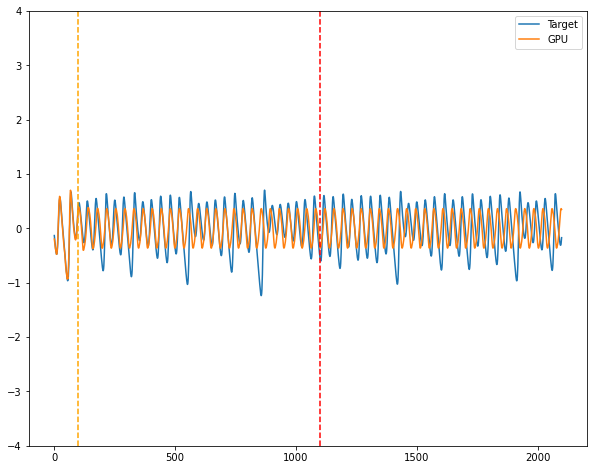

 Iter=47 a=0.996 sr=1.674 amp=1.000  ri=1.271 rr=2.163 loss=0.559742 nrmse=0.141582 CD 0.418160
Iter: 47 #### Time 4.43  NRMSE 0.142 CD 0.418
Iter: 48 #### Time 4.12  NRMSE 0.204 CD 0.988
Iter: 49 #### Time 4.22  NRMSE 1000.000 CD nan
Iter: 50 #### Time 4.12  NRMSE 0.197 CD 0.968
Iter: 51 #### Time 4.12  NRMSE 1000.000 CD 0.999
Iter: 52 #### Time 4.13  NRMSE 0.206 CD 1.021
Iter: 53 #### Time 4.16  NRMSE 0.180 CD 0.899
Iter: 54 #### Time 4.14  NRMSE 0.184 CD 0.855
Iter: 55 #### Time 4.16  NRMSE 0.248 CD 1.052
Iter: 56 #### Time 4.15  NRMSE 0.183 CD 0.952
Iter: 57 #### Time 4.21  NRMSE 1000.000 CD 1.001
Iter: 58 #### Time 4.22  NRMSE 0.237 CD 0.955
Iter: 59 #### Time 4.18  NRMSE 0.192 CD 0.974
Iter: 60 #### Time 4.14  NRMSE 0.192 CD 0.981
Iter: 61 #### Time 4.22  NRMSE 1000.000 CD nan
Iter: 62 #### Time 4.36  NRMSE 0.253 CD 0.888
Iter: 63 #### Time 4.22  NRMSE 1000.000 CD nan
Iter: 64 #### Time 4.19  NRMSE 1000.000 CD 0.957
Iter: 65 #### Time 4.15  NRMSE 1000.000 CD nan
Iter: 66 #### Tim

Iter: 0 #### Time 4.19  NRMSE 0.197 CD 0.971
Iter: 1 #### Time 4.14  NRMSE 0.184 CD 0.866
Iter: 2 #### Time 4.18  NRMSE 0.243 CD 1.040
Iter: 3 #### Time 4.21  NRMSE 0.199 CD 0.673
Iter: 4 #### Time 4.16  NRMSE 1000.000 CD nan
Iter: 5 #### Time 4.14  NRMSE 1000.000 CD nan
Iter: 6 #### Time 4.10  NRMSE 1000.000 CD nan
Iter: 7 #### Time 4.12  NRMSE 0.218 CD 0.983
Iter: 8 #### Time 4.15  NRMSE 0.181 CD 0.928
Iter: 9 #### Time 4.12  NRMSE 1000.000 CD nan
Iter: 10 #### Time 4.10  NRMSE 1.287 CD 1.117
Iter: 11 #### Time 4.12  NRMSE 0.191 CD 0.897
Iter: 12 #### Time 4.20  NRMSE 1000.000 CD 1.009
Iter: 13 #### Time 4.18  NRMSE 0.200 CD 0.976
Iter: 14 #### Time 4.13  NRMSE 0.181 CD 0.956
Iter: 15 #### Time 4.12  NRMSE 0.196 CD 0.975
Iter: 16 #### Time 4.15  NRMSE 0.194 CD 0.975
Iter: 17 #### Time 4.22  NRMSE 0.232 CD 0.939
Iter: 18 #### Time 4.18  NRMSE 0.196 CD 0.978
Iter: 19 #### Time 4.22  NRMSE 1000.000 CD nan
Iter: 20 #### Time 4.19  NRMSE 0.201 CD 0.989
Iter: 21 #### Time 4.15  NRMSE 1000.

Iter: 73 #### Time 4.15  NRMSE 0.216 CD 0.966
Iter: 74 #### Time 4.12  NRMSE 0.195 CD 0.930
Iter: 75 #### Time 4.12  NRMSE 1000.000 CD nan
Iter: 76 #### Time 4.11  NRMSE 0.265 CD 1.121
Iter: 77 #### Time 4.11  NRMSE 88796732398820738990080.000 CD 0.979
Iter: 78 #### Time 4.10  NRMSE 0.188 CD 0.884
Iter: 79 #### Time 4.15  NRMSE 0.253 CD 1.007
Iter: 80 #### Time 4.13  NRMSE 1000.000 CD nan
Iter: 81 #### Time 4.13  NRMSE 0.225 CD 0.877
Iter: 82 #### Time 4.10  NRMSE 1000.000 CD nan
Iter: 83 #### Time 4.10  NRMSE 0.412 CD 1.002
Iter: 84 #### Time 4.08  NRMSE 1000.000 CD nan
Iter: 85 #### Time 4.08  NRMSE 0.183 CD 0.948
Iter: 86 #### Time 4.12  NRMSE 1000.000 CD nan
Iter: 87 #### Time 4.15  NRMSE 0.236 CD 1.014
Iter: 88 #### Time 4.12  NRMSE 1000.000 CD nan
Iter: 89 #### Time 4.11  NRMSE 1000.000 CD nan
Iter: 90 #### Time 4.11  NRMSE 0.198 CD 0.974
Iter: 91 #### Time 4.14  NRMSE 0.197 CD 0.987
Iter: 92 #### Time 4.12  NRMSE 0.234 CD 1.024
Iter: 93 #### Time 4.14  NRMSE 0.226 CD 0.990
Iter:

Iter: 41 #### Time 4.19  NRMSE 1000.000 CD nan
Iter: 42 #### Time 4.20  NRMSE 0.180 CD 0.902
Iter: 43 #### Time 4.26  NRMSE 0.253 CD 1.092
Iter: 44 #### Time 4.22  NRMSE 95975684809.190 CD 0.992
Iter: 45 #### Time 4.28  NRMSE 0.253 CD 1.091
Iter: 46 #### Time 4.21  NRMSE 0.263 CD 1.054
Iter: 47 #### Time 4.40  NRMSE 0.185 CD 0.898
Iter: 48 #### Time 4.27  NRMSE 0.223 CD 1.013
Iter: 49 #### Time 4.21  NRMSE 1000.000 CD nan
Iter: 50 #### Time 4.23  NRMSE 0.208 CD 0.980
Iter: 51 #### Time 4.21  NRMSE 0.219 CD 1.008
Iter: 52 #### Time 4.20  NRMSE 0.207 CD 0.978
Iter: 53 #### Time 4.15  NRMSE 0.244 CD 0.991
Iter: 54 #### Time 4.17  NRMSE 0.195 CD 0.967
Iter: 55 #### Time 4.13  NRMSE 0.259 CD 1.023
Iter: 56 #### Time 4.14  NRMSE 1000.000 CD nan
Iter: 57 #### Time 4.15  NRMSE 1000.000 CD nan
Iter: 58 #### Time 4.24  NRMSE 0.249 CD 1.191
Iter: 59 #### Time 4.19  NRMSE 0.237 CD 0.987
Iter: 60 #### Time 4.16  NRMSE 0.224 CD 0.989
Iter: 61 #### Time 4.21  NRMSE 1000.000 CD nan
Iter: 62 #### Time 

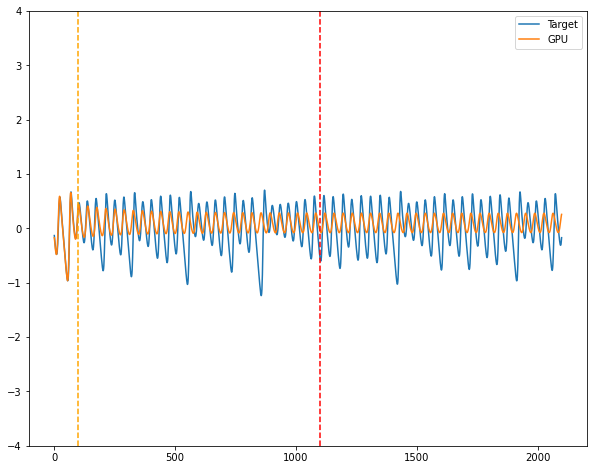

 Iter=27 a=0.743 sr=1.610 amp=1.000  ri=1.685 rr=2.285 loss=0.676155 nrmse=0.148114 CD 0.528041
Iter: 27 #### Time 4.68  NRMSE 0.148 CD 0.528
Iter: 28 #### Time 4.18  NRMSE 0.211 CD 1.002
Iter: 29 #### Time 4.22  NRMSE 1000.000 CD nan
Iter: 30 #### Time 4.13  NRMSE 0.191 CD 0.981
Iter: 31 #### Time 4.15  NRMSE 0.204 CD 0.820
Iter: 32 #### Time 4.18  NRMSE 1000.000 CD 0.999
Iter: 33 #### Time 4.14  NRMSE 0.193 CD 0.941
Iter: 34 #### Time 4.12  NRMSE 0.220 CD 0.892
Iter: 35 #### Time 4.11  NRMSE 0.327 CD 0.985
Iter: 36 #### Time 4.11  NRMSE 0.503 CD 0.997
Iter: 37 #### Time 4.13  NRMSE 1000.000 CD nan
Iter: 38 #### Time 4.11  NRMSE 0.214 CD 0.889
Iter: 39 #### Time 4.11  NRMSE 0.243 CD 0.982
Iter: 40 #### Time 4.55  NRMSE 0.228 CD 1.011
Iter: 41 #### Time 4.34  NRMSE 0.218 CD 1.005
Iter: 42 #### Time 4.44  NRMSE 0.204 CD 0.874
Iter: 43 #### Time 4.32  NRMSE 0.183 CD 0.963
Iter: 44 #### Time 4.30  NRMSE 0.295 CD 1.216
Iter: 45 #### Time 4.87  NRMSE 1000.000 CD nan
Iter: 46 #### Time 5.41 

Iter: 98 #### Time 4.21  NRMSE 0.232 CD 0.960
Iter: 99 #### Time 4.67  NRMSE 0.536 CD 1.008
End Run 1 Time 453.316

Best result = 0.6029821762358047
a = 0.7516268718210609
sr = 1.5626395084356992
amp = 3.327453173050867
ri = 3.154922412130608
********** Size16 ref 1 -- Run 2 ***********
Iter: 0 #### Time 4.29  NRMSE 0.271 CD 1.146
Iter: 1 #### Time 4.27  NRMSE 1000.000 CD nan
Iter: 2 #### Time 4.14  NRMSE 0.206 CD 0.936
Iter: 3 #### Time 4.19  NRMSE 0.267 CD 0.992
Iter: 4 #### Time 4.24  NRMSE 0.205 CD 0.979
Iter: 5 #### Time 4.27  NRMSE 0.195 CD 0.976
Iter: 6 #### Time 4.90  NRMSE 1000.000 CD nan
Iter: 7 #### Time 4.79  NRMSE 0.525 CD 1.001
Iter: 8 #### Time 4.21  NRMSE 0.193 CD 0.555
Iter: 9 #### Time 4.86  NRMSE 0.250 CD 0.862
Iter: 10 #### Time 5.16  NRMSE 0.249 CD 0.961
Iter: 11 #### Time 4.19  NRMSE 1000.000 CD nan
Iter: 12 #### Time 4.64  NRMSE 0.203 CD 1.027
Iter: 13 #### Time 5.00  NRMSE 0.185 CD 0.888
Iter: 14 #### Time 4.10  NRMSE 0.214 CD 0.822
Iter: 15 #### Time 4.16  NRMS

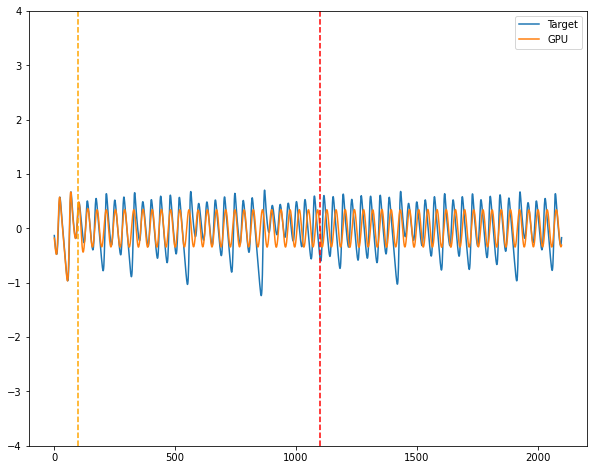

 Iter=46 a=0.985 sr=2.929 amp=1.000  ri=0.484 rr=1.469 loss=0.594787 nrmse=0.147066 CD 0.447721
Iter: 46 #### Time 4.69  NRMSE 0.147 CD 0.448
Iter: 47 #### Time 4.27  NRMSE 1000.000 CD nan
Iter: 48 #### Time 4.62  NRMSE 282570114406825091973880217600.000 CD 0.997
Iter: 49 #### Time 4.12  NRMSE 0.183 CD 0.880
Iter: 50 #### Time 4.31  NRMSE 0.270 CD 1.124
Iter: 51 #### Time 4.63  NRMSE 0.185 CD 0.938
Iter: 52 #### Time 4.62  NRMSE 0.276 CD 0.941
Iter: 53 #### Time 4.81  NRMSE 0.248 CD 1.035
Iter: 54 #### Time 4.20  NRMSE 0.237 CD 1.098
Iter: 55 #### Time 4.13  NRMSE 0.973 CD 1.001
Iter: 56 #### Time 4.17  NRMSE 129528905716414742528.000 CD 1.050
Iter: 57 #### Time 4.23  NRMSE 0.188 CD 0.731
Iter: 58 #### Time 4.18  NRMSE 1000.000 CD nan
Iter: 59 #### Time 4.16  NRMSE 1000.000 CD nan
Iter: 60 #### Time 4.18  NRMSE 0.221 CD 0.851
Iter: 61 #### Time 4.17  NRMSE 0.242 CD 1.069
Iter: 62 #### Time 4.15  NRMSE 1000.000 CD nan
Iter: 63 #### Time 4.13  NRMSE 0.221 CD 0.915
Iter: 64 #### Time 4.16

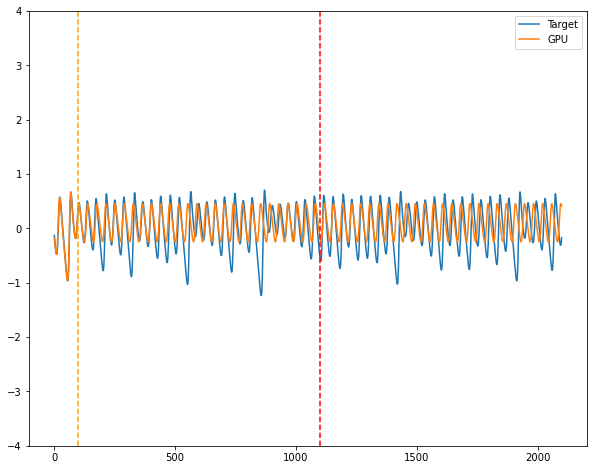

 Iter=99 a=0.914 sr=1.970 amp=1.000  ri=3.125 rr=3.808 loss=0.636218 nrmse=0.147562 CD 0.488656
Iter: 99 #### Time 4.32  NRMSE 0.148 CD 0.489
End Run 4 Time 448.356

Best result = 0.6362182948654788
a = 0.9139848411722984
sr = 1.9700761283666548
amp = 3.1250075761579406
ri = 3.808002223227673

Best mn:0.743	 mn:0.985
New bounds mn--mx: 0.197--0.008

Best mn:1.610	 mn:2.929
New bounds mn--mx: 0.430--0.785

Best mn:1.000	 mn:1.000
New bounds mn--mx: 0.500--1.000

Best mn:0.484	 mn:3.125
New bounds mn--mx: 0.167--1.062

Best mn:1.469	 mn:3.808
New bounds mn--mx: 0.635--1.096
Refined search bounds:

Alpha (0.5465367969601984, 0.9923511815998851)

Rho (1.1800273059344009, 3.7145506726466864)

Gamma (0.50025, 2.0)

r-in (0.31682877933912335, 4.1875037880789705)

r-res (0.83453669592297, 4.9040011116138364)

********** Size16 ref 2 -- Run 0 ***********
Iter: 0 #### Time 4.18  NRMSE 0.246 CD 1.075
Iter: 1 #### Time 4.15  NRMSE 0.211 CD 0.978
Iter: 2 #### Time 4.18  NRMSE 0.213 CD 1.092
Iter: 3

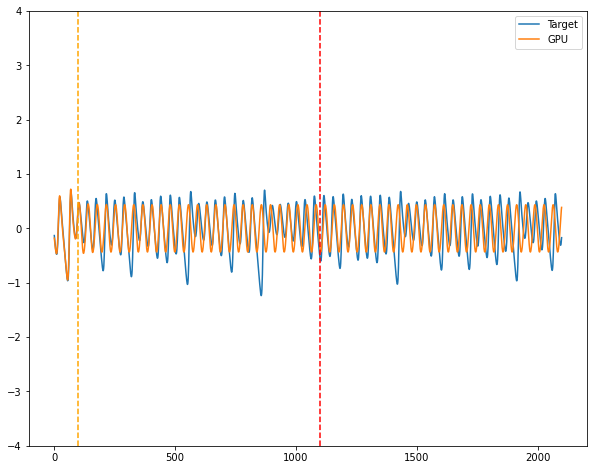

 Iter=54 a=0.990 sr=1.729 amp=1.000  ri=2.002 rr=1.867 loss=0.594690 nrmse=0.147236 CD 0.447454
Iter: 54 #### Time 4.81  NRMSE 0.147 CD 0.447
Iter: 55 #### Time 5.47  NRMSE 0.204 CD 0.979
Iter: 56 #### Time 4.55  NRMSE 0.221 CD 0.987
Iter: 57 #### Time 4.42  NRMSE 1000.000 CD nan
Iter: 58 #### Time 5.06  NRMSE 0.201 CD 0.958
Iter: 59 #### Time 4.42  NRMSE 0.191 CD 0.977
Iter: 60 #### Time 4.14  NRMSE 0.387 CD 1.088
Iter: 61 #### Time 4.23  NRMSE 1000.000 CD nan
Iter: 62 #### Time 4.64  NRMSE 0.193 CD 0.980
Iter: 63 #### Time 4.15  NRMSE 1000.000 CD 0.988
Iter: 64 #### Time 4.13  NRMSE 0.202 CD 0.980
Iter: 65 #### Time 4.20  NRMSE 0.945 CD 0.988
Iter: 66 #### Time 4.19  NRMSE 0.186 CD 0.977
Iter: 67 #### Time 4.21  NRMSE 0.244 CD 1.029
Iter: 68 #### Time 4.20  NRMSE 0.269 CD 0.911
Iter: 69 #### Time 5.01  NRMSE 0.247 CD 1.028
Iter: 70 #### Time 5.06  NRMSE 0.243 CD 1.102
Iter: 71 #### Time 4.73  NRMSE 0.519 CD 0.995
Iter: 72 #### Time 4.86  NRMSE 0.198 CD 0.968
Iter: 73 #### Time 4.30  

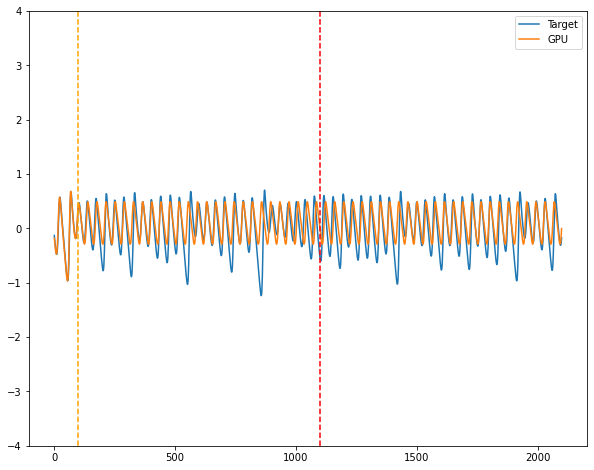

 Iter=10 a=0.869 sr=2.622 amp=1.000  ri=2.251 rr=1.132 loss=0.593565 nrmse=0.145629 CD 0.447936
Iter: 10 #### Time 4.77  NRMSE 0.146 CD 0.448
Iter: 11 #### Time 4.13  NRMSE 0.187 CD 0.969
Iter: 12 #### Time 4.12  NRMSE 0.210 CD 0.851
Iter: 13 #### Time 4.20  NRMSE 556221547287440752794822323575193600.000 CD 1.001
Iter: 14 #### Time 4.23  NRMSE 0.228 CD 0.679
Iter: 15 #### Time 4.22  NRMSE 0.241 CD 1.026
Iter: 16 #### Time 4.18  NRMSE 1000.000 CD nan
Iter: 17 #### Time 4.17  NRMSE 1000.000 CD nan
Iter: 18 #### Time 4.15  NRMSE 1000.000 CD nan
Iter: 19 #### Time 4.15  NRMSE 0.518 CD 0.979
Iter: 20 #### Time 4.11  NRMSE 0.533 CD 1.002
Iter: 21 #### Time 4.07  NRMSE 0.208 CD 1.042
Iter: 22 #### Time 4.13  NRMSE 0.223 CD 0.990
Iter: 23 #### Time 4.16  NRMSE 0.217 CD 0.980
Iter: 24 #### Time 4.22  NRMSE 1000.000 CD nan
Iter: 25 #### Time 4.26  NRMSE 0.262 CD 0.974
Iter: 26 #### Time 4.88  NRMSE 0.188 CD 0.974
Iter: 27 #### Time 4.82  NRMSE 0.222 CD 0.768
Iter: 28 #### Time 4.14  NRMSE 0.234 

Iter: 80 #### Time 5.20  NRMSE 0.182 CD 0.894
Iter: 81 #### Time 4.83  NRMSE 0.192 CD 0.968
Iter: 82 #### Time 4.18  NRMSE 0.160 CD 0.466
Iter: 83 #### Time 4.12  NRMSE 0.186 CD 0.944
Iter: 84 #### Time 4.10  NRMSE 109710428710885081088.000 CD 0.997
Iter: 85 #### Time 4.16  NRMSE 0.192 CD 0.987
Iter: 86 #### Time 4.21  NRMSE 0.205 CD 1.050
Iter: 87 #### Time 4.15  NRMSE 0.260 CD 1.095
Iter: 88 #### Time 4.33  NRMSE 0.181 CD 0.899
Iter: 89 #### Time 4.34  NRMSE 0.201 CD 0.987
Iter: 90 #### Time 4.18  NRMSE 0.219 CD 0.988
Iter: 91 #### Time 4.56  NRMSE 0.194 CD 0.987
Iter: 92 #### Time 4.15  NRMSE 0.237 CD 0.654
Iter: 93 #### Time 4.17  NRMSE 0.224 CD 0.874
Iter: 94 #### Time 4.43  NRMSE 1000.000 CD nan
Iter: 95 #### Time 4.61  NRMSE 0.228 CD 0.957
Iter: 96 #### Time 4.10  NRMSE 1000.000 CD nan
Iter: 97 #### Time 4.13  NRMSE 0.198 CD 0.993
Iter: 98 #### Time 4.13  NRMSE 0.204 CD 1.049
Iter: 99 #### Time 4.45  NRMSE 1000.000 CD nan
End Run 3 Time 432.292

Best result = 0.6261655190639286


Iter: 36 #### Time 4.06  NRMSE 1000.000 CD nan
Iter: 37 #### Time 4.07  NRMSE 0.188 CD 0.956
Iter: 38 #### Time 4.09  NRMSE 0.197 CD 0.968
Iter: 39 #### Time 4.10  NRMSE 0.202 CD 0.982
Iter: 40 #### Time 4.09  NRMSE 0.194 CD 0.638
Iter: 41 #### Time 4.03  NRMSE 1000.000 CD nan
Iter: 42 #### Time 4.04  NRMSE 0.244 CD 1.049
Iter: 43 #### Time 4.08  NRMSE 0.212 CD 0.984
Iter: 44 #### Time 4.07  NRMSE 0.255 CD 1.063
Iter: 45 #### Time 4.05  NRMSE 1000.000 CD nan
Iter: 46 #### Time 4.02  NRMSE 0.196 CD 0.975
Iter: 47 #### Time 4.11  NRMSE 0.191 CD 0.971
Iter: 48 #### Time 4.06  NRMSE 1000.000 CD nan
Iter: 49 #### Time 4.05  NRMSE 0.219 CD 0.919
Iter: 50 #### Time 4.11  NRMSE 0.250 CD 0.884
Iter: 51 #### Time 4.05  NRMSE 1000.000 CD nan
Iter: 52 #### Time 4.03  NRMSE 0.210 CD 0.990
Iter: 53 #### Time 4.05  NRMSE 0.229 CD 0.890
Iter: 54 #### Time 4.04  NRMSE 0.193 CD 0.974
Iter: 55 #### Time 4.05  NRMSE 0.218 CD 0.915
Iter: 56 #### Time 4.02  NRMSE 0.184 CD 0.946
Iter: 57 #### Time 4.06  NRMS

Iter: 4 #### Time 4.12  NRMSE 0.192 CD 0.967
Iter: 5 #### Time 4.23  NRMSE 0.206 CD 1.020
Iter: 6 #### Time 4.05  NRMSE 0.179 CD 0.874
Iter: 7 #### Time 4.12  NRMSE 1000.000 CD nan
Iter: 8 #### Time 4.05  NRMSE 6670.998 CD 1.005
Iter: 9 #### Time 4.12  NRMSE 0.168 CD 0.564
Iter: 10 #### Time 4.27  NRMSE 1000.000 CD 0.999
Iter: 11 #### Time 4.07  NRMSE 0.238 CD 1.136
Iter: 12 #### Time 4.09  NRMSE 0.224 CD 0.941
Iter: 13 #### Time 4.25  NRMSE 1000.000 CD nan
Iter: 14 #### Time 4.11  NRMSE 1000.000 CD nan
Iter: 15 #### Time 4.07  NRMSE 0.198 CD 0.984
Iter: 16 #### Time 4.10  NRMSE 1000.000 CD nan
Iter: 17 #### Time 4.21  NRMSE 0.200 CD 0.961
Iter: 18 #### Time 4.11  NRMSE 0.196 CD 0.976
Iter: 19 #### Time 4.09  NRMSE 0.220 CD 0.988
Iter: 20 #### Time 4.06  NRMSE 1000.000 CD nan
Iter: 21 #### Time 4.11  NRMSE 0.220 CD 0.952
Iter: 22 #### Time 4.13  NRMSE 0.196 CD 0.981
Iter: 23 #### Time 4.12  NRMSE 0.191 CD 0.897
Iter: 24 #### Time 4.10  NRMSE 0.197 CD 0.966
Iter: 25 #### Time 4.10  NRMS

Iter: 75 #### Time 4.13  NRMSE 0.222 CD 0.674
Iter: 76 #### Time 4.04  NRMSE 1000.000 CD nan
Iter: 77 #### Time 4.06  NRMSE 0.182 CD 0.953
Iter: 78 #### Time 4.06  NRMSE 191681103.770 CD 0.970
Iter: 79 #### Time 4.08  NRMSE 0.226 CD 0.870
Iter: 80 #### Time 4.07  NRMSE 1000.000 CD nan
Iter: 81 #### Time 4.11  NRMSE 1000.000 CD nan
Iter: 82 #### Time 4.12  NRMSE 0.198 CD 0.982
Iter: 83 #### Time 4.11  NRMSE 0.201 CD 0.982
Iter: 84 #### Time 4.08  NRMSE 1000.000 CD nan
Iter: 85 #### Time 4.22  NRMSE 1000.000 CD nan
Iter: 86 #### Time 4.09  NRMSE 0.184 CD 0.875
Iter: 87 #### Time 4.06  NRMSE 0.530 CD 1.000
Iter: 88 #### Time 4.07  NRMSE 0.193 CD 0.979
Iter: 89 #### Time 4.06  NRMSE 0.197 CD 0.996
Iter: 90 #### Time 4.05  NRMSE 2703866.164 CD 1.003
Iter: 91 #### Time 4.07  NRMSE 1000.000 CD nan
Iter: 92 #### Time 4.05  NRMSE 0.212 CD 1.026
Iter: 93 #### Time 4.13  NRMSE 0.208 CD 0.876
Iter: 94 #### Time 4.11  NRMSE 0.509 CD 1.007
Iter: 95 #### Time 4.10  NRMSE 1000.000 CD nan
Iter: 96 ####

Iter: 38 #### Time 4.96  NRMSE 1000.000 CD nan
Iter: 39 #### Time 5.32  NRMSE 1000.000 CD nan
Iter: 40 #### Time 4.77  NRMSE 0.485 CD 0.985
Iter: 41 #### Time 4.71  NRMSE 0.221 CD 0.986
Iter: 42 #### Time 4.24  NRMSE 0.301 CD 0.929
Iter: 43 #### Time 4.85  NRMSE 0.241 CD 1.080
Iter: 44 #### Time 4.70  NRMSE 0.195 CD 0.985
Iter: 45 #### Time 5.61  NRMSE 1000.000 CD nan
Iter: 46 #### Time 5.35  NRMSE 1000.000 CD nan
Iter: 47 #### Time 4.93  NRMSE 0.201 CD 0.970
Iter: 48 #### Time 4.46  NRMSE 1000.000 CD nan
Iter: 49 #### Time 4.76  NRMSE 0.197 CD 0.974
Iter: 50 #### Time 4.40  NRMSE 1000.000 CD nan
Iter: 51 #### Time 4.81  NRMSE 0.290 CD 1.307
Iter: 52 #### Time 5.21  NRMSE 0.189 CD 0.806
Iter: 53 #### Time 4.84  NRMSE 0.272 CD 1.030
Iter: 54 #### Time 4.25  NRMSE 0.217 CD 1.019
Iter: 55 #### Time 4.28  NRMSE 0.186 CD 0.948
Iter: 56 #### Time 4.22  NRMSE 1000.000 CD nan
Iter: 57 #### Time 4.15  NRMSE 0.260 CD 1.355
Iter: 58 #### Time 4.16  NRMSE 1000.000 CD nan
Iter: 59 #### Time 4.13  N

Iter: 6 #### Time 4.18  NRMSE 1.300 CD 0.997
Iter: 7 #### Time 4.27  NRMSE 1000.000 CD nan
Iter: 8 #### Time 5.06  NRMSE 0.200 CD 0.973
Iter: 9 #### Time 5.46  NRMSE 1000.000 CD nan
Iter: 10 #### Time 4.17  NRMSE 0.196 CD 0.966
Iter: 11 #### Time 4.21  NRMSE 0.230 CD 0.989
Iter: 12 #### Time 4.19  NRMSE 0.286 CD 1.293
Iter: 13 #### Time 4.22  NRMSE 0.248 CD 0.887
Iter: 14 #### Time 4.31  NRMSE 0.248 CD 0.941
Iter: 15 #### Time 4.16  NRMSE 0.335 CD 0.971
Iter: 16 #### Time 4.16  NRMSE 261.391 CD 1.000
Iter: 17 #### Time 5.44  NRMSE 1000.000 CD nan
Iter: 18 #### Time 5.57  NRMSE 1000.000 CD nan
Iter: 19 #### Time 4.73  NRMSE 0.184 CD 0.948
Iter: 20 #### Time 4.23  NRMSE 1000.000 CD nan
Iter: 21 #### Time 4.22  NRMSE 0.191 CD 0.965
Iter: 22 #### Time 4.18  NRMSE 0.274 CD 1.154
Iter: 23 #### Time 4.21  NRMSE 1000.000 CD nan
Iter: 24 #### Time 4.16  NRMSE 1000.000 CD nan
Iter: 25 #### Time 4.15  NRMSE 0.220 CD 0.976
Iter: 26 #### Time 4.23  NRMSE 1000.000 CD nan
Iter: 27 #### Time 4.19  NRM

Iter: 77 #### Time 4.11  NRMSE 0.186 CD 0.905
Iter: 78 #### Time 4.09  NRMSE 1000.000 CD nan
Iter: 79 #### Time 4.03  NRMSE 1000.000 CD nan
Iter: 80 #### Time 4.07  NRMSE 1000.000 CD nan
Iter: 81 #### Time 4.14  NRMSE 0.192 CD 0.579
Iter: 82 #### Time 4.13  NRMSE 1000.000 CD nan
Iter: 83 #### Time 4.03  NRMSE 0.207 CD 0.975
Iter: 84 #### Time 4.09  NRMSE 0.185 CD 0.896
Iter: 85 #### Time 4.24  NRMSE 0.181 CD 0.955
Iter: 86 #### Time 4.14  NRMSE 0.247 CD 0.993
Iter: 87 #### Time 4.13  NRMSE 0.254 CD 1.008
Iter: 88 #### Time 4.13  NRMSE 1000.000 CD nan
Iter: 89 #### Time 4.14  NRMSE 0.184 CD 0.969
Iter: 90 #### Time 4.22  NRMSE 0.187 CD 0.880
Iter: 91 #### Time 4.14  NRMSE 0.241 CD 0.910
Iter: 92 #### Time 4.17  NRMSE 0.219 CD 0.889
Iter: 93 #### Time 4.13  NRMSE 1000.000 CD nan
Iter: 94 #### Time 4.15  NRMSE 0.188 CD 0.967
Iter: 95 #### Time 4.71  NRMSE 0.185 CD 1.002
Iter: 96 #### Time 4.28  NRMSE 1000.000 CD 0.999
Iter: 97 #### Time 4.21  NRMSE 452.394 CD 1.000
Iter: 98 #### Time 4.17

Iter: 40 #### Time 5.63  NRMSE 0.386 CD 0.993
Iter: 41 #### Time 4.58  NRMSE 1000.000 CD nan
Iter: 42 #### Time 5.19  NRMSE 0.486 CD 0.992
Iter: 43 #### Time 4.69  NRMSE 0.198 CD 0.985
Iter: 44 #### Time 5.27  NRMSE 0.203 CD 0.923
Iter: 45 #### Time 5.62  NRMSE 1000.000 CD nan
Iter: 46 #### Time 4.34  NRMSE 0.181 CD 0.944
Iter: 47 #### Time 4.14  NRMSE 3136284.588 CD 0.970
Iter: 48 #### Time 4.07  NRMSE 1000.000 CD nan
Iter: 49 #### Time 4.10  NRMSE 1000.000 CD nan
Iter: 50 #### Time 4.10  NRMSE 0.184 CD 0.946
Iter: 51 #### Time 4.09  NRMSE 0.213 CD 0.814
Iter: 52 #### Time 4.09  NRMSE 0.418 CD 0.999
Iter: 53 #### Time 4.08  NRMSE 1000.000 CD 1.002
Iter: 54 #### Time 4.06  NRMSE 1000.000 CD nan
Iter: 55 #### Time 4.05  NRMSE 0.234 CD 0.989
Iter: 56 #### Time 4.09  NRMSE 1000.000 CD nan
Iter: 57 #### Time 4.08  NRMSE 0.179 CD 0.905
Iter: 58 #### Time 4.08  NRMSE 1000.000 CD nan
Iter: 59 #### Time 4.06  NRMSE 0.262 CD 1.102
Iter: 60 #### Time 4.07  NRMSE 0.211 CD 0.979
Iter: 61 #### Time

Iter: 7 #### Time 4.51  NRMSE 0.181 CD 0.811
Iter: 8 #### Time 4.88  NRMSE 0.201 CD 0.961
Iter: 9 #### Time 4.67  NRMSE 1000.000 CD 0.999
Iter: 10 #### Time 5.50  NRMSE 1000.000 CD nan
Iter: 11 #### Time 4.13  NRMSE 0.210 CD 0.872
Iter: 12 #### Time 4.13  NRMSE 0.224 CD 0.823
Iter: 13 #### Time 4.18  NRMSE 0.197 CD 0.983
Iter: 14 #### Time 4.16  NRMSE 0.415 CD 1.036
Iter: 15 #### Time 4.16  NRMSE 0.265 CD 1.163
Iter: 16 #### Time 4.15  NRMSE 1009095462.223 CD 1.003
Iter: 17 #### Time 4.15  NRMSE 0.195 CD 0.981
Iter: 18 #### Time 4.14  NRMSE 1000.000 CD nan
Iter: 19 #### Time 4.12  NRMSE 0.270 CD 1.056
Iter: 20 #### Time 4.17  NRMSE 0.200 CD 0.861
Iter: 21 #### Time 4.14  NRMSE 0.228 CD 0.986
Iter: 22 #### Time 4.37  NRMSE 0.259 CD 0.995
Iter: 23 #### Time 5.67  NRMSE 0.245 CD 1.119
Iter: 24 #### Time 5.27  NRMSE 1000.000 CD nan
Iter: 25 #### Time 5.21  NRMSE 0.183 CD 0.867
Iter: 26 #### Time 4.20  NRMSE 1000.000 CD nan
Iter: 27 #### Time 4.13  NRMSE 0.187 CD 0.979
Iter: 28 #### Time 4.

Iter: 79 #### Time 5.07  NRMSE 0.191 CD 0.964
Iter: 80 #### Time 5.03  NRMSE 1000.000 CD nan
Iter: 81 #### Time 4.31  NRMSE 64431.658 CD 0.990
Iter: 82 #### Time 4.52  NRMSE 0.198 CD 0.987
Iter: 83 #### Time 4.23  NRMSE 1000.000 CD 1.011
Iter: 84 #### Time 4.23  NRMSE 0.289 CD 1.110
Iter: 85 #### Time 4.18  NRMSE 1000.000 CD nan
Iter: 86 #### Time 4.35  NRMSE 0.183 CD 0.861
Iter: 87 #### Time 4.26  NRMSE 0.255 CD 1.082
Iter: 88 #### Time 4.17  NRMSE 0.926 CD 0.965
Iter: 89 #### Time 4.18  NRMSE 1000.000 CD nan
Iter: 90 #### Time 4.20  NRMSE 0.528 CD 0.991
Iter: 91 #### Time 4.26  NRMSE 0.275 CD 1.034
Iter: 92 #### Time 4.13  NRMSE 0.528 CD 0.995
Iter: 93 #### Time 4.17  NRMSE 0.186 CD 0.955
Iter: 94 #### Time 4.21  NRMSE 1000.000 CD nan
Iter: 95 #### Time 4.72  NRMSE 0.242 CD 0.954
Iter: 96 #### Time 5.53  NRMSE 0.232 CD 0.979
Iter: 97 #### Time 4.80  NRMSE 0.304 CD 1.119
Iter: 98 #### Time 4.65  NRMSE 1000.000 CD nan
Iter: 99 #### Time 4.33  NRMSE 1000.000 CD 0.994
End Run 3 Time 448.

Iter: 44 #### Time 4.36  NRMSE 0.188 CD 0.978
Iter: 45 #### Time 4.18  NRMSE 0.206 CD 0.956
Iter: 46 #### Time 4.13  NRMSE 0.199 CD 0.974
Iter: 47 #### Time 4.15  NRMSE 0.536 CD 0.978
Iter: 48 #### Time 4.17  NRMSE 1000.000 CD nan
Iter: 49 #### Time 4.56  NRMSE 0.199 CD 0.964
Iter: 50 #### Time 4.15  NRMSE 1000.000 CD 1.000
Iter: 51 #### Time 4.36  NRMSE 53428881981880590336.000 CD 0.982
Iter: 52 #### Time 4.21  NRMSE 0.209 CD 0.969
Iter: 53 #### Time 4.30  NRMSE 0.221 CD 0.730
Iter: 54 #### Time 4.21  NRMSE 0.190 CD 0.974
Iter: 55 #### Time 4.14  NRMSE 1000.000 CD nan
Iter: 56 #### Time 4.12  NRMSE 1000.000 CD nan
Iter: 57 #### Time 4.14  NRMSE 0.208 CD 0.951
Iter: 58 #### Time 4.19  NRMSE 22.441 CD 0.970
Iter: 59 #### Time 4.14  NRMSE 0.207 CD 1.151
Iter: 60 #### Time 4.11  NRMSE 1000.000 CD nan
Iter: 61 #### Time 4.11  NRMSE 0.198 CD 0.956
Iter: 62 #### Time 4.12  NRMSE 0.150 CD 0.501
Iter: 63 #### Time 4.18  NRMSE 0.199 CD 0.968
Iter: 64 #### Time 4.15  NRMSE 0.192 CD 0.926
Iter: 6

Iter: 12 #### Time 4.10  NRMSE 0.184 CD 0.699
Iter: 13 #### Time 4.16  NRMSE 0.224 CD 0.983
Iter: 14 #### Time 4.68  NRMSE 0.206 CD 0.955
Iter: 15 #### Time 4.24  NRMSE 0.192 CD 0.976
Iter: 16 #### Time 4.08  NRMSE 0.190 CD 0.988
Iter: 17 #### Time 4.47  NRMSE 0.192 CD 0.972
Iter: 18 #### Time 5.71  NRMSE 0.192 CD 0.977
Iter: 19 #### Time 5.16  NRMSE 0.204 CD 1.013
Iter: 20 #### Time 4.14  NRMSE 0.190 CD 0.976
Iter: 21 #### Time 4.15  NRMSE 0.198 CD 0.981
Iter: 22 #### Time 4.23  NRMSE 0.166 CD 0.601
Iter: 23 #### Time 4.33  NRMSE 0.150 CD 0.442
Iter: 24 #### Time 4.44  NRMSE 0.176 CD 0.833
Iter: 25 #### Time 4.14  NRMSE 1.245 CD 0.988
Iter: 26 #### Time 4.18  NRMSE 0.221 CD 0.927
Iter: 27 #### Time 4.55  NRMSE 0.184 CD 0.912
Iter: 28 #### Time 5.20  NRMSE 0.188 CD 0.949
Iter: 29 #### Time 4.14  NRMSE 0.230 CD 0.747
Iter: 30 #### Time 5.13  NRMSE 0.493 CD 0.990
Iter: 31 #### Time 4.32  NRMSE 0.202 CD 0.978
Iter: 32 #### Time 5.69  NRMSE 0.216 CD 0.996
Iter: 33 #### Time 5.61  NRMSE 0.2

Iter: 84 #### Time 3.97  NRMSE 0.216 CD 0.980
Iter: 85 #### Time 4.28  NRMSE 0.209 CD 0.741
Iter: 86 #### Time 4.14  NRMSE 1000.000 CD nan
Iter: 87 #### Time 4.13  NRMSE 1000.000 CD nan
Iter: 88 #### Time 4.16  NRMSE 27.518 CD 1.000
Iter: 89 #### Time 4.12  NRMSE 0.198 CD 0.978
Iter: 90 #### Time 4.11  NRMSE 0.234 CD 1.057
Iter: 91 #### Time 4.20  NRMSE 0.238 CD 0.914
Iter: 92 #### Time 4.11  NRMSE 0.195 CD 0.990
Iter: 93 #### Time 4.14  NRMSE 0.192 CD 0.595
Iter: 94 #### Time 4.12  NRMSE 0.219 CD 1.001
Iter: 95 #### Time 4.10  NRMSE 0.239 CD 0.915
Iter: 96 #### Time 4.11  NRMSE 3588.558 CD 1.017
Iter: 97 #### Time 4.09  NRMSE 1000.000 CD nan
Iter: 98 #### Time 4.07  NRMSE 1000.000 CD nan
Iter: 99 #### Time 4.08  NRMSE 0.223 CD 1.031
End Run 3 Time 415.860

Best result = 0.7869925524860379
a = 0.8506230615246231
sr = 2.2387872903162127
amp = 1.054237531250701
ri = 2.9221723413451897
********** Size14 ref 1 -- Run 4 ***********
Iter: 0 #### Time 4.13  NRMSE 0.190 CD 0.955
Iter: 1 #### T

Iter: 50 #### Time 4.16  NRMSE 0.241 CD 1.076
Iter: 51 #### Time 4.15  NRMSE 0.185 CD 0.944
Iter: 52 #### Time 4.14  NRMSE 0.200 CD 0.986
Iter: 53 #### Time 4.12  NRMSE 0.171 CD 0.465
Iter: 54 #### Time 4.14  NRMSE 0.237 CD 1.035
Iter: 55 #### Time 4.09  NRMSE 0.206 CD 0.995
Iter: 56 #### Time 4.15  NRMSE 1000.000 CD nan
Iter: 57 #### Time 4.11  NRMSE 0.529 CD 1.001
Iter: 58 #### Time 4.16  NRMSE 0.184 CD 0.938
Iter: 59 #### Time 4.15  NRMSE 0.213 CD 0.780
Iter: 60 #### Time 4.20  NRMSE 0.182 CD 0.945
Iter: 61 #### Time 4.10  NRMSE 0.199 CD 0.981
Iter: 62 #### Time 4.13  NRMSE 0.184 CD 0.946
Iter: 63 #### Time 4.15  NRMSE 1000.000 CD nan
Iter: 64 #### Time 4.19  NRMSE 0.186 CD 0.934
Iter: 65 #### Time 4.11  NRMSE 0.200 CD 0.799
Iter: 66 #### Time 4.15  NRMSE 0.256 CD 1.075
Iter: 67 #### Time 4.30  NRMSE 0.249 CD 0.994
Iter: 68 #### Time 4.30  NRMSE 0.178 CD 0.883
Iter: 69 #### Time 4.13  NRMSE 0.206 CD 0.984
Iter: 70 #### Time 4.15  NRMSE 0.206 CD 0.857
Iter: 71 #### Time 4.14  NRMSE 1

Iter: 18 #### Time 4.15  NRMSE 1000.000 CD nan
Iter: 19 #### Time 4.12  NRMSE 0.191 CD 0.986
Iter: 20 #### Time 4.22  NRMSE 0.188 CD 0.953
Iter: 21 #### Time 4.12  NRMSE 0.186 CD 0.998
Iter: 22 #### Time 4.15  NRMSE 0.209 CD 0.982
Iter: 23 #### Time 4.10  NRMSE 0.203 CD 0.996
Iter: 24 #### Time 4.09  NRMSE 0.206 CD 0.986
Iter: 25 #### Time 4.12  NRMSE 0.182 CD 0.964
Iter: 26 #### Time 4.20  NRMSE 0.208 CD 0.920
Iter: 27 #### Time 4.23  NRMSE 0.197 CD 0.972
Iter: 28 #### Time 4.16  NRMSE 0.209 CD 0.987
Iter: 29 #### Time 4.17  NRMSE 0.206 CD 0.956
Iter: 30 #### Time 4.16  NRMSE 0.224 CD 1.054
Iter: 31 #### Time 4.14  NRMSE 1000.000 CD nan
Iter: 32 #### Time 4.10  NRMSE 0.266 CD 1.098
Iter: 33 #### Time 4.08  NRMSE 0.216 CD 0.934
Iter: 34 #### Time 4.12  NRMSE 0.188 CD 0.972
Iter: 35 #### Time 4.16  NRMSE 327.282 CD 0.999
Iter: 36 #### Time 4.14  NRMSE 0.213 CD 0.980
Iter: 37 #### Time 4.23  NRMSE 0.213 CD 1.018
Iter: 38 #### Time 4.29  NRMSE 0.189 CD 0.976
Iter: 39 #### Time 4.16  NRMSE

Iter: 91 #### Time 4.07  NRMSE 0.332 CD 0.961
Iter: 92 #### Time 4.10  NRMSE 0.157 CD 0.575
Iter: 93 #### Time 4.08  NRMSE 281491065737753088.000 CD 0.998
Iter: 94 #### Time 4.21  NRMSE 1000.000 CD nan
Iter: 95 #### Time 4.18  NRMSE 0.188 CD 0.955
Iter: 96 #### Time 4.20  NRMSE 1000.000 CD nan
Iter: 97 #### Time 4.19  NRMSE 0.217 CD 0.687
Iter: 98 #### Time 4.12  NRMSE 0.183 CD 0.918
Iter: 99 #### Time 4.13  NRMSE 0.239 CD 1.069
End Run 3 Time 432.532

Best result = 0.5911457294338827
a = 0.8101220776423205
sr = 2.9474274427792784
amp = 2.634964803126401
ri = 3.020958941943835
********** Size14 ref 2 -- Run 4 ***********
Iter: 0 #### Time 4.13  NRMSE 0.184 CD 0.965
Iter: 1 #### Time 4.14  NRMSE 0.197 CD 0.976
Iter: 2 #### Time 4.13  NRMSE 1000.000 CD nan
Iter: 3 #### Time 4.29  NRMSE 0.204 CD 1.016
Iter: 4 #### Time 4.35  NRMSE 0.216 CD 1.038
Iter: 5 #### Time 4.49  NRMSE 0.196 CD 0.981
Iter: 6 #### Time 4.34  NRMSE 0.180 CD 0.929
Iter: 7 #### Time 4.29  NRMSE 0.247 CD 1.058
Iter: 8 ##

Iter: 57 #### Time 4.79  NRMSE 0.248 CD 0.940
Iter: 58 #### Time 4.73  NRMSE 0.258 CD 1.089
Iter: 59 #### Time 4.19  NRMSE 0.212 CD 0.812
Iter: 60 #### Time 4.21  NRMSE 0.194 CD 0.739
Iter: 61 #### Time 4.27  NRMSE 0.199 CD 0.978
Iter: 62 #### Time 4.28  NRMSE 0.209 CD 0.977
Iter: 63 #### Time 4.28  NRMSE 1000.000 CD nan
Iter: 64 #### Time 4.29  NRMSE 0.200 CD 0.841
Iter: 65 #### Time 4.32  NRMSE 0.186 CD 0.884
Iter: 66 #### Time 4.25  NRMSE 0.219 CD 1.046
Iter: 67 #### Time 4.20  NRMSE 1000.000 CD nan
Iter: 68 #### Time 4.29  NRMSE 1.659 CD 0.998
Iter: 69 #### Time 4.24  NRMSE 0.211 CD 0.955
Iter: 70 #### Time 4.17  NRMSE 0.224 CD 0.803
Iter: 71 #### Time 4.49  NRMSE 0.280 CD 1.221
Iter: 72 #### Time 5.33  NRMSE 0.530 CD 0.998
Iter: 73 #### Time 4.22  NRMSE 1000.000 CD 0.998
Iter: 74 #### Time 4.30  NRMSE 0.190 CD 0.969
Iter: 75 #### Time 4.42  NRMSE 0.204 CD 0.848
Iter: 76 #### Time 4.98  NRMSE 1000.000 CD nan
Iter: 77 #### Time 4.44  NRMSE 0.231 CD 1.070
Iter: 78 #### Time 4.21  NRM

Iter: 25 #### Time 4.33  NRMSE 0.207 CD 0.972
Iter: 26 #### Time 4.25  NRMSE 0.181 CD 0.923
Iter: 27 #### Time 4.34  NRMSE 0.239 CD 0.878
Iter: 28 #### Time 4.19  NRMSE 0.187 CD 0.917
Iter: 29 #### Time 4.32  NRMSE 1000.000 CD nan
Iter: 30 #### Time 4.15  NRMSE 1000.000 CD nan
Iter: 31 #### Time 4.15  NRMSE 1000.000 CD nan
Iter: 32 #### Time 4.22  NRMSE 0.176 CD 0.496
Iter: 33 #### Time 4.24  NRMSE 0.255 CD 1.052
Iter: 34 #### Time 4.64  NRMSE 0.194 CD 0.965
Iter: 35 #### Time 5.03  NRMSE 0.197 CD 0.980
Iter: 36 #### Time 5.32  NRMSE 0.365 CD 1.042
Iter: 37 #### Time 4.92  NRMSE 859522592659.716 CD 1.000
Iter: 38 #### Time 4.16  NRMSE 0.249 CD 1.005
Iter: 39 #### Time 4.38  NRMSE 1000.000 CD 1.005
Iter: 40 #### Time 5.36  NRMSE 0.197 CD 0.969
Iter: 41 #### Time 4.90  NRMSE 1000.000 CD nan
Iter: 42 #### Time 4.18  NRMSE 0.364 CD 1.099
Iter: 43 #### Time 4.26  NRMSE 0.174 CD 0.449
Iter: 44 #### Time 4.19  NRMSE 1000.000 CD nan
Iter: 45 #### Time 4.25  NRMSE 0.226 CD 0.875
Iter: 46 #### T

Iter: 97 #### Time 4.25  NRMSE 0.200 CD 0.777
Iter: 98 #### Time 4.20  NRMSE 0.197 CD 0.976
Iter: 99 #### Time 4.16  NRMSE 0.196 CD 0.975
End Run 3 Time 493.231

Best result = 0.6226277559914479
a = 0.9009922605739258
sr = 1.7592992313796956
amp = 2.9958006010293294
ri = 2.489969104200491
********** Size14 ref 3 -- Run 4 ***********
Iter: 0 #### Time 4.17  NRMSE 0.185 CD 0.918
Iter: 1 #### Time 4.33  NRMSE 0.261 CD 1.058
Iter: 2 #### Time 4.37  NRMSE 0.180 CD 0.926
Iter: 3 #### Time 4.28  NRMSE 0.188 CD 0.938
Iter: 4 #### Time 4.24  NRMSE 0.223 CD 0.989
Iter: 5 #### Time 4.23  NRMSE 0.184 CD 0.627
Iter: 6 #### Time 4.34  NRMSE 0.209 CD 0.976
Iter: 7 #### Time 4.18  NRMSE 0.160 CD 0.491
Iter: 8 #### Time 4.24  NRMSE 0.199 CD 0.993
Iter: 9 #### Time 4.18  NRMSE 0.205 CD 0.983
Iter: 10 #### Time 4.28  NRMSE 1000.000 CD nan
Iter: 11 #### Time 4.36  NRMSE 0.196 CD 0.955
Iter: 12 #### Time 4.23  NRMSE 1000.000 CD nan
Iter: 13 #### Time 4.24  NRMSE 0.182 CD 0.940
Iter: 14 #### Time 4.20  NRMS

Iter: 62 #### Time 4.20  NRMSE 0.230 CD 0.991
Iter: 63 #### Time 4.21  NRMSE 0.204 CD 0.979
Iter: 64 #### Time 4.37  NRMSE 0.205 CD 0.987
Iter: 65 #### Time 4.45  NRMSE 0.221 CD 1.059
Iter: 66 #### Time 4.31  NRMSE 1000.000 CD 0.995
Iter: 67 #### Time 4.24  NRMSE 1000.000 CD 1.001
Iter: 68 #### Time 4.27  NRMSE 0.189 CD 0.968
Iter: 69 #### Time 4.22  NRMSE 0.198 CD 0.936
Iter: 70 #### Time 4.29  NRMSE 0.230 CD 0.999
Iter: 71 #### Time 4.27  NRMSE 0.222 CD 0.968
Iter: 72 #### Time 4.28  NRMSE 0.187 CD 0.979
Iter: 73 #### Time 4.24  NRMSE 0.191 CD 0.975
Iter: 74 #### Time 4.35  NRMSE 1000.000 CD nan
Iter: 75 #### Time 4.33  NRMSE 0.199 CD 0.978
Iter: 76 #### Time 4.33  NRMSE 1000.000 CD nan
Iter: 77 #### Time 4.59  NRMSE 0.244 CD 1.024
Iter: 78 #### Time 4.42  NRMSE 72824184600751025025974272.000 CD 1.000
Iter: 79 #### Time 4.35  NRMSE 0.188 CD 0.943
Iter: 80 #### Time 4.34  NRMSE 1000.000 CD 1.004
Iter: 81 #### Time 4.33  NRMSE 0.189 CD 0.966
Iter: 82 #### Time 4.28  NRMSE 1000.000 CD 1

Iter: 29 #### Time 4.35  NRMSE 0.195 CD 0.959
Iter: 30 #### Time 4.29  NRMSE 0.171 CD 0.641
Iter: 31 #### Time 4.48  NRMSE 1000.000 CD nan
Iter: 32 #### Time 4.25  NRMSE 0.217 CD 0.892
Iter: 33 #### Time 4.32  NRMSE 0.363 CD 0.993
Iter: 34 #### Time 4.27  NRMSE 0.198 CD 0.973
Iter: 35 #### Time 4.47  NRMSE 0.201 CD 0.986
Iter: 36 #### Time 4.29  NRMSE 0.314 CD 0.989
Iter: 37 #### Time 4.47  NRMSE 0.264 CD 1.060
Iter: 38 #### Time 4.27  NRMSE 0.185 CD 0.976
Iter: 39 #### Time 4.37  NRMSE 0.265 CD 1.176
Iter: 40 #### Time 4.83  NRMSE 0.201 CD 0.983
Iter: 41 #### Time 4.60  NRMSE 0.178 CD 0.893
Iter: 42 #### Time 4.47  NRMSE 0.189 CD 0.961
Iter: 43 #### Time 4.39  NRMSE 0.181 CD 0.905
Iter: 44 #### Time 4.40  NRMSE 0.197 CD 0.972
Iter: 45 #### Time 4.23  NRMSE 0.267 CD 1.002
Iter: 46 #### Time 4.30  NRMSE 0.192 CD 0.945
Iter: 47 #### Time 4.26  NRMSE 1000.000 CD nan
Iter: 48 #### Time 4.35  NRMSE 0.175 CD 0.475
Iter: 49 #### Time 4.32  NRMSE 0.443 CD 0.997
Iter: 50 #### Time 4.24  NRMSE 0

Iter: 0 #### Time 4.48  NRMSE 0.198 CD 0.976
Iter: 1 #### Time 4.23  NRMSE 0.201 CD 0.834
Iter: 2 #### Time 4.27  NRMSE 0.269 CD 1.161
Iter: 3 #### Time 4.25  NRMSE 0.222 CD 0.978
Iter: 4 #### Time 4.42  NRMSE 0.217 CD 0.975
Iter: 5 #### Time 4.34  NRMSE 0.525 CD 0.991
Iter: 6 #### Time 4.43  NRMSE 0.238 CD 1.114
Iter: 7 #### Time 4.31  NRMSE 1000.000 CD nan
Iter: 8 #### Time 4.25  NRMSE 0.206 CD 0.990
Iter: 9 #### Time 4.34  NRMSE 0.212 CD 0.992
Iter: 10 #### Time 4.30  NRMSE 1000.000 CD nan
Iter: 11 #### Time 4.25  NRMSE 0.248 CD 0.979
Iter: 12 #### Time 4.26  NRMSE 0.185 CD 0.874
Iter: 13 #### Time 4.19  NRMSE 0.198 CD 0.984
Iter: 14 #### Time 4.32  NRMSE 1000.000 CD nan
Iter: 15 #### Time 4.25  NRMSE 0.218 CD 0.882
Iter: 16 #### Time 4.30  NRMSE 0.183 CD 0.967
Iter: 17 #### Time 4.25  NRMSE 0.219 CD 0.926
Iter: 18 #### Time 4.31  NRMSE 0.190 CD 0.840
Iter: 19 #### Time 4.29  NRMSE 5070.625 CD 0.990
Iter: 20 #### Time 4.27  NRMSE 0.227 CD 1.056
Iter: 21 #### Time 4.34  NRMSE 0.211 C

Iter: 69 #### Time 4.30  NRMSE 0.247 CD 1.022
Iter: 70 #### Time 4.24  NRMSE 0.263 CD 1.121
Iter: 71 #### Time 4.40  NRMSE 0.199 CD 0.967
Iter: 72 #### Time 4.28  NRMSE 27613.076 CD 1.001
Iter: 73 #### Time 4.34  NRMSE 0.536 CD 1.008
Iter: 74 #### Time 5.07  NRMSE 0.238 CD 0.989
Iter: 75 #### Time 5.93  NRMSE 1879.488 CD 0.998
Iter: 76 #### Time 5.87  NRMSE 1000.000 CD nan
Iter: 77 #### Time 5.88  NRMSE 0.292 CD 0.991
Iter: 78 #### Time 5.88  NRMSE 0.195 CD 0.968
Iter: 79 #### Time 5.83  NRMSE 1000.000 CD nan
Iter: 80 #### Time 5.97  NRMSE 0.203 CD 1.040
Iter: 81 #### Time 5.90  NRMSE 1000.000 CD nan
Iter: 82 #### Time 5.98  NRMSE 1000.000 CD nan
Iter: 83 #### Time 5.88  NRMSE 0.173 CD 0.695
Iter: 84 #### Time 5.99  NRMSE 0.210 CD 0.990
Iter: 85 #### Time 4.79  NRMSE 0.256 CD 1.064
Iter: 86 #### Time 4.94  NRMSE 0.197 CD 0.980
Iter: 87 #### Time 5.18  NRMSE 0.193 CD 0.970
Iter: 88 #### Time 4.24  NRMSE 0.529 CD 1.001
Iter: 89 #### Time 4.24  NRMSE 1027.043 CD 1.000
Iter: 90 #### Time 4

Iter: 37 #### Time 4.28  NRMSE 0.176 CD 0.740
Iter: 38 #### Time 4.31  NRMSE 0.236 CD 1.082
Iter: 39 #### Time 4.28  NRMSE 9841472377.790 CD 1.014
Iter: 40 #### Time 4.28  NRMSE 0.243 CD 1.068
Iter: 41 #### Time 4.28  NRMSE 1000.000 CD nan
Iter: 42 #### Time 4.30  NRMSE 0.924 CD 0.995
Iter: 43 #### Time 4.23  NRMSE 0.317 CD 1.123
Iter: 44 #### Time 4.27  NRMSE 0.199 CD 0.979
Iter: 45 #### Time 4.31  NRMSE 0.182 CD 0.950
Iter: 46 #### Time 4.34  NRMSE 0.181 CD 0.939
Iter: 47 #### Time 4.32  NRMSE 0.236 CD 1.124
Iter: 48 #### Time 4.33  NRMSE 1000.000 CD nan
Iter: 49 #### Time 4.31  NRMSE 0.225 CD 0.902
Iter: 50 #### Time 4.38  NRMSE 0.190 CD 0.973
Iter: 51 #### Time 4.40  NRMSE 0.207 CD 0.979
Iter: 52 #### Time 4.30  NRMSE 0.179 CD 0.660
Iter: 53 #### Time 4.31  NRMSE 1000.000 CD nan
Iter: 54 #### Time 4.36  NRMSE 0.196 CD 0.991
Iter: 55 #### Time 4.39  NRMSE 1000.000 CD nan
Iter: 56 #### Time 4.46  NRMSE 0.194 CD 0.960
Iter: 57 #### Time 4.33  NRMSE 0.213 CD 0.988
Iter: 58 #### Time 4.

Iter: 5 #### Time 4.16  NRMSE 1000.000 CD nan
Iter: 6 #### Time 4.22  NRMSE 0.183 CD 0.890
Iter: 7 #### Time 4.18  NRMSE 0.207 CD 0.977
Iter: 8 #### Time 4.18  NRMSE 1000.000 CD nan
Iter: 9 #### Time 4.18  NRMSE 0.190 CD 0.976
Iter: 10 #### Time 4.18  NRMSE 0.205 CD 0.991
Iter: 11 #### Time 4.15  NRMSE 0.185 CD 0.958
Iter: 12 #### Time 4.14  NRMSE 0.277 CD 0.870
Iter: 13 #### Time 4.15  NRMSE 0.217 CD 0.880
Iter: 14 #### Time 4.13  NRMSE 0.241 CD 1.046
Iter: 15 #### Time 4.12  NRMSE 0.194 CD 0.964
Iter: 16 #### Time 4.22  NRMSE 0.187 CD 0.855
Iter: 17 #### Time 4.15  NRMSE 1000.000 CD nan
Iter: 18 #### Time 4.14  NRMSE 0.184 CD 0.902
Iter: 19 #### Time 4.16  NRMSE 0.224 CD 1.085
Iter: 20 #### Time 4.17  NRMSE 0.201 CD 0.677
Iter: 21 #### Time 4.14  NRMSE 0.243 CD 1.106
Iter: 22 #### Time 4.15  NRMSE 0.186 CD 0.916
Iter: 23 #### Time 4.13  NRMSE 0.193 CD 0.990
Iter: 24 #### Time 4.13  NRMSE 0.236 CD 1.056
Iter: 25 #### Time 4.18  NRMSE 0.197 CD 0.989
Iter: 26 #### Time 4.16  NRMSE 0.198

Iter: 75 #### Time 4.00  NRMSE 1000.000 CD 1.001
Iter: 76 #### Time 4.02  NRMSE 0.236 CD 1.044
Iter: 77 #### Time 3.98  NRMSE 0.181 CD 0.953
Iter: 78 #### Time 3.99  NRMSE 0.286 CD 1.258
Iter: 79 #### Time 3.98  NRMSE 0.197 CD 0.979
Iter: 80 #### Time 3.96  NRMSE 558931.826 CD 1.001
Iter: 81 #### Time 3.99  NRMSE 0.195 CD 0.969
Iter: 82 #### Time 3.97  NRMSE 0.183 CD 0.849
Iter: 83 #### Time 3.98  NRMSE 1000.000 CD nan
Iter: 84 #### Time 3.98  NRMSE 0.197 CD 0.974
Iter: 85 #### Time 4.06  NRMSE 0.184 CD 0.854
Iter: 86 #### Time 4.02  NRMSE 0.202 CD 1.019
Iter: 87 #### Time 4.00  NRMSE 0.246 CD 1.115
Iter: 88 #### Time 4.06  NRMSE 0.182 CD 0.962
Iter: 89 #### Time 3.97  NRMSE 0.267 CD 1.183
Iter: 90 #### Time 3.96  NRMSE 0.248 CD 1.075
Iter: 91 #### Time 3.96  NRMSE 0.256 CD 1.106
Iter: 92 #### Time 3.97  NRMSE 1000.000 CD nan
Iter: 93 #### Time 3.98  NRMSE 0.355 CD 1.015
Iter: 94 #### Time 4.01  NRMSE 0.199 CD 0.988
Iter: 95 #### Time 3.96  NRMSE 0.186 CD 0.974
Iter: 96 #### Time 3.98 

Iter: 44 #### Time 3.98  NRMSE 1000.000 CD nan
Iter: 45 #### Time 3.98  NRMSE 0.219 CD 0.807
Iter: 46 #### Time 4.04  NRMSE 1000.000 CD nan
Iter: 47 #### Time 3.98  NRMSE 1000.000 CD nan
Iter: 48 #### Time 3.99  NRMSE 1000.000 CD nan
Iter: 49 #### Time 4.06  NRMSE 0.181 CD 0.955
Iter: 50 #### Time 4.02  NRMSE 1000.000 CD nan
Iter: 51 #### Time 4.00  NRMSE 0.266 CD 1.081
Iter: 52 #### Time 3.99  NRMSE 0.249 CD 0.990
Iter: 53 #### Time 4.00  NRMSE 0.200 CD 0.820
Iter: 54 #### Time 4.00  NRMSE 0.191 CD 0.984
Iter: 55 #### Time 3.98  NRMSE 0.177 CD 0.830
Iter: 56 #### Time 3.97  NRMSE 0.182 CD 0.969
Iter: 57 #### Time 3.99  NRMSE 0.249 CD 0.803
Iter: 58 #### Time 3.99  NRMSE 0.189 CD 0.921
Iter: 59 #### Time 4.06  NRMSE 7.777 CD 1.239
Iter: 60 #### Time 3.99  NRMSE 1000.000 CD nan
Iter: 61 #### Time 3.99  NRMSE 0.184 CD 0.992
Iter: 62 #### Time 3.99  NRMSE 0.182 CD 0.951
Iter: 63 #### Time 4.01  NRMSE 0.183 CD 0.976
Iter: 64 #### Time 4.00  NRMSE 0.219 CD 1.114
Iter: 65 #### Time 4.01  NRM

Iter: 12 #### Time 4.01  NRMSE 1000.000 CD nan
Iter: 13 #### Time 4.02  NRMSE 0.496 CD 0.991
Iter: 14 #### Time 4.00  NRMSE 0.203 CD 0.979
Iter: 15 #### Time 4.14  NRMSE 0.181 CD 0.916
Iter: 16 #### Time 4.01  NRMSE 0.261 CD 0.963
Iter: 17 #### Time 4.01  NRMSE 0.191 CD 0.969
Iter: 18 #### Time 3.99  NRMSE 0.248 CD 0.988
Iter: 19 #### Time 4.01  NRMSE 0.181 CD 0.797
Iter: 20 #### Time 4.00  NRMSE 0.189 CD 0.670
Iter: 21 #### Time 4.02  NRMSE 0.236 CD 1.015
Iter: 22 #### Time 3.99  NRMSE 0.184 CD 0.890
Iter: 23 #### Time 4.01  NRMSE 0.263 CD 1.098
Iter: 24 #### Time 3.98  NRMSE 0.189 CD 0.964
Iter: 25 #### Time 4.07  NRMSE 0.209 CD 0.990
Iter: 26 #### Time 4.01  NRMSE 0.283 CD 1.257
Iter: 27 #### Time 4.00  NRMSE 0.222 CD 1.080
Iter: 28 #### Time 3.98  NRMSE 1000.000 CD nan
Iter: 29 #### Time 3.99  NRMSE 1000.000 CD nan
Iter: 30 #### Time 4.03  NRMSE 0.191 CD 0.970
Iter: 31 #### Time 3.99  NRMSE 0.186 CD 0.907
Iter: 32 #### Time 4.01  NRMSE 0.194 CD 0.859
Iter: 33 #### Time 3.98  NRMSE 

Iter: 82 #### Time 4.03  NRMSE 0.190 CD 0.985
Iter: 83 #### Time 4.00  NRMSE 1000.000 CD nan
Iter: 84 #### Time 4.00  NRMSE 0.188 CD 0.963
Iter: 85 #### Time 4.00  NRMSE 0.332 CD 1.108
Iter: 86 #### Time 4.11  NRMSE 0.211 CD 0.932
Iter: 87 #### Time 4.01  NRMSE 0.212 CD 0.668
Iter: 88 #### Time 4.01  NRMSE 0.210 CD 0.945
Iter: 89 #### Time 4.01  NRMSE 0.186 CD 0.910
Iter: 90 #### Time 4.01  NRMSE 0.264 CD 1.027
Iter: 91 #### Time 4.03  NRMSE 0.293 CD 1.004
Iter: 92 #### Time 4.03  NRMSE 0.215 CD 0.830
Iter: 93 #### Time 4.03  NRMSE 0.188 CD 0.963
Iter: 94 #### Time 4.00  NRMSE 0.187 CD 0.773
Iter: 95 #### Time 4.00  NRMSE 0.269 CD 1.172
Iter: 96 #### Time 4.01  NRMSE 0.182 CD 0.978
Iter: 97 #### Time 4.00  NRMSE 1000.000 CD nan
Iter: 98 #### Time 4.02  NRMSE 0.175 CD 0.851
Iter: 99 #### Time 4.03  NRMSE 0.197 CD 0.981
End Run 0 Time 405.083

Best result = 0.7282999316565514
a = 0.742782739899231
sr = 2.540175120932373
amp = 3.449373512485035
ri = 3.8085446734819515
********** Size12 re

Iter: 51 #### Time 3.99  NRMSE 1000.000 CD nan
Iter: 52 #### Time 3.98  NRMSE 0.239 CD 0.996
Iter: 53 #### Time 3.99  NRMSE 0.206 CD 0.752
Iter: 54 #### Time 4.00  NRMSE 0.226 CD 0.883
Iter: 55 #### Time 4.00  NRMSE 1000.000 CD nan
Iter: 56 #### Time 3.98  NRMSE 0.187 CD 0.977
Iter: 57 #### Time 3.99  NRMSE 0.207 CD 0.987
Iter: 58 #### Time 3.98  NRMSE 0.197 CD 0.963
Iter: 59 #### Time 3.98  NRMSE 0.279 CD 1.139
Iter: 60 #### Time 4.01  NRMSE 1000.000 CD nan
Iter: 61 #### Time 3.98  NRMSE 0.203 CD 0.961
Iter: 62 #### Time 3.98  NRMSE 0.168 CD 0.576
Iter: 63 #### Time 3.98  NRMSE 0.268 CD 1.216
Iter: 64 #### Time 4.00  NRMSE 0.315 CD 1.426
Iter: 65 #### Time 4.21  NRMSE 0.198 CD 0.991
Iter: 66 #### Time 3.99  NRMSE 0.231 CD 1.029
Iter: 67 #### Time 4.04  NRMSE 0.192 CD 0.991
Iter: 68 #### Time 3.98  NRMSE 0.182 CD 0.982
Iter: 69 #### Time 4.03  NRMSE 0.186 CD 0.982
Iter: 70 #### Time 4.00  NRMSE 0.186 CD 0.952
Iter: 71 #### Time 4.01  NRMSE 0.276 CD 1.107
Iter: 72 #### Time 4.04  NRMSE 

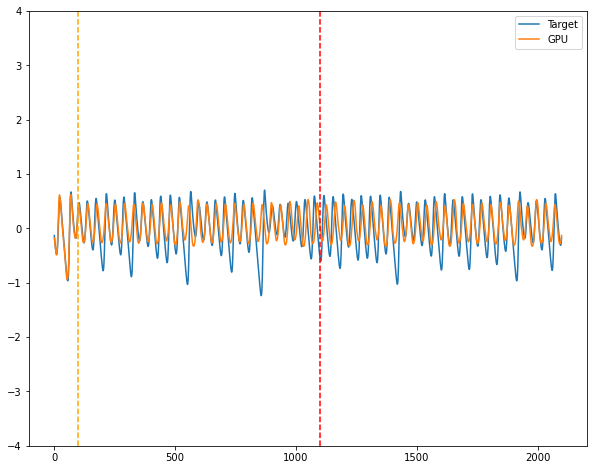

 Iter=15 a=0.829 sr=2.195 amp=1.000  ri=2.571 rr=0.536 loss=0.604657 nrmse=0.147951 CD 0.456707
Iter: 15 #### Time 4.45  NRMSE 0.148 CD 0.457
Iter: 16 #### Time 4.02  NRMSE 0.187 CD 0.861
Iter: 17 #### Time 4.02  NRMSE 0.194 CD 0.979
Iter: 18 #### Time 4.03  NRMSE 0.233 CD 0.985
Iter: 19 #### Time 4.02  NRMSE 0.186 CD 0.925
Iter: 20 #### Time 4.00  NRMSE 0.190 CD 0.955
Iter: 21 #### Time 4.07  NRMSE 1000.000 CD nan
Iter: 22 #### Time 4.02  NRMSE 0.520 CD 0.964
Iter: 23 #### Time 4.03  NRMSE 1000.000 CD 1.000
Iter: 24 #### Time 4.00  NRMSE 0.226 CD 1.093
Iter: 25 #### Time 3.98  NRMSE 6804577005383547092992.000 CD 0.995
Iter: 26 #### Time 4.05  NRMSE 0.185 CD 0.888
Iter: 27 #### Time 4.02  NRMSE 0.204 CD 0.987
Iter: 28 #### Time 4.00  NRMSE 0.197 CD 0.878
Iter: 29 #### Time 4.02  NRMSE 0.183 CD 0.933
Iter: 30 #### Time 3.99  NRMSE 1000.000 CD nan
Iter: 31 #### Time 4.01  NRMSE 0.197 CD 0.956
Iter: 32 #### Time 4.00  NRMSE 0.181 CD 0.960
Iter: 33 #### Time 4.05  NRMSE 1000.000 CD 1.054
I

Iter: 85 #### Time 4.03  NRMSE 0.249 CD 0.991
Iter: 86 #### Time 4.02  NRMSE 0.183 CD 0.948
Iter: 87 #### Time 4.00  NRMSE 1000.000 CD nan
Iter: 88 #### Time 4.01  NRMSE 0.206 CD 1.015
Iter: 89 #### Time 4.03  NRMSE 0.185 CD 0.969
Iter: 90 #### Time 4.08  NRMSE 1000.000 CD nan
Iter: 91 #### Time 3.99  NRMSE 0.534 CD 0.995
Iter: 92 #### Time 4.00  NRMSE 0.215 CD 0.983
Iter: 93 #### Time 4.00  NRMSE 0.252 CD 1.105
Iter: 94 #### Time 3.99  NRMSE 1000.000 CD nan
Iter: 95 #### Time 4.00  NRMSE 0.256 CD 0.991
Iter: 96 #### Time 3.99  NRMSE 1000.000 CD nan
Iter: 97 #### Time 4.00  NRMSE 0.524 CD 0.997
Iter: 98 #### Time 3.98  NRMSE 0.222 CD 0.900
Iter: 99 #### Time 3.99  NRMSE 0.268 CD 1.117
End Run 4 Time 405.068

Best result = 0.7858957402611257
a = 0.9531685626612669
sr = 1.8703007980999915
amp = 3.300377693755631
ri = 2.3163051903336607

Best mn:0.829	 mn:0.829
New bounds mn--mx: 0.327--0.085

Best mn:2.195	 mn:2.195
New bounds mn--mx: 0.910--2.278

Best mn:1.000	 mn:1.000
New bounds mn--

Iter: 42 #### Time 4.13  NRMSE 0.175 CD 0.843
Iter: 43 #### Time 3.98  NRMSE 0.234 CD 0.993
Iter: 44 #### Time 4.01  NRMSE 0.198 CD 0.966
Iter: 45 #### Time 3.98  NRMSE 0.199 CD 0.987
Iter: 46 #### Time 4.00  NRMSE 0.214 CD 0.861
Iter: 47 #### Time 4.06  NRMSE 0.206 CD 0.885
Iter: 48 #### Time 4.01  NRMSE 1000.000 CD 0.970
Iter: 49 #### Time 3.98  NRMSE 0.192 CD 0.965
Iter: 50 #### Time 4.00  NRMSE 0.202 CD 0.970
Iter: 51 #### Time 4.12  NRMSE 0.262 CD 1.164
Iter: 52 #### Time 4.03  NRMSE 0.246 CD 1.098
Iter: 53 #### Time 3.99  NRMSE 1000.000 CD nan
Dist 0.448212


New N best!!!!!!!!!!!!


[12, 3, 1, 54]


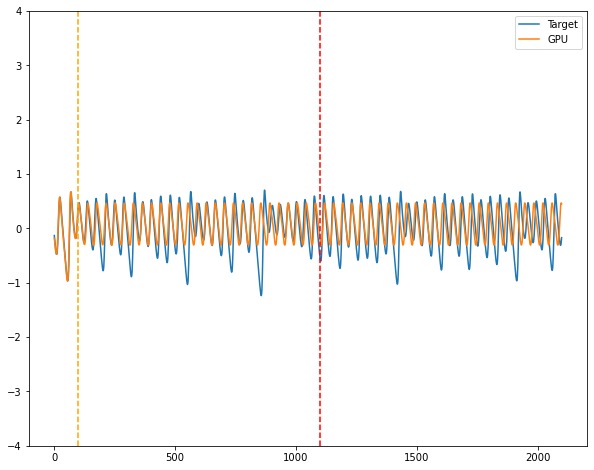

 Iter=54 a=0.821 sr=2.329 amp=1.000  ri=3.257 rr=0.631 loss=0.591958 nrmse=0.143746 CD 0.448212
Iter: 54 #### Time 4.51  NRMSE 0.144 CD 0.448
Iter: 55 #### Time 4.10  NRMSE 1000.000 CD nan
Iter: 56 #### Time 3.98  NRMSE 1000.000 CD nan
Iter: 57 #### Time 4.01  NRMSE 0.203 CD 0.813
Iter: 58 #### Time 3.98  NRMSE 0.211 CD 0.866
Iter: 59 #### Time 4.00  NRMSE 0.196 CD 0.983
Iter: 60 #### Time 3.99  NRMSE 0.201 CD 0.858
Iter: 61 #### Time 3.98  NRMSE 27.380 CD 0.933
Iter: 62 #### Time 4.00  NRMSE 0.204 CD 0.726
Iter: 63 #### Time 4.01  NRMSE 0.943 CD 1.062
Iter: 64 #### Time 4.00  NRMSE 0.196 CD 0.974
Iter: 65 #### Time 3.98  NRMSE 0.182 CD 0.878
Iter: 66 #### Time 3.99  NRMSE 0.210 CD 0.977
Iter: 67 #### Time 4.07  NRMSE 0.203 CD 0.983
Iter: 68 #### Time 4.02  NRMSE 1000.000 CD nan
Iter: 69 #### Time 4.05  NRMSE 0.307 CD 1.018
Iter: 70 #### Time 4.02  NRMSE 0.233 CD 0.979
Iter: 71 #### Time 3.99  NRMSE 1000.000 CD nan
Iter: 72 #### Time 4.01  NRMSE 0.231 CD 0.882
Iter: 73 #### Time 3.99  

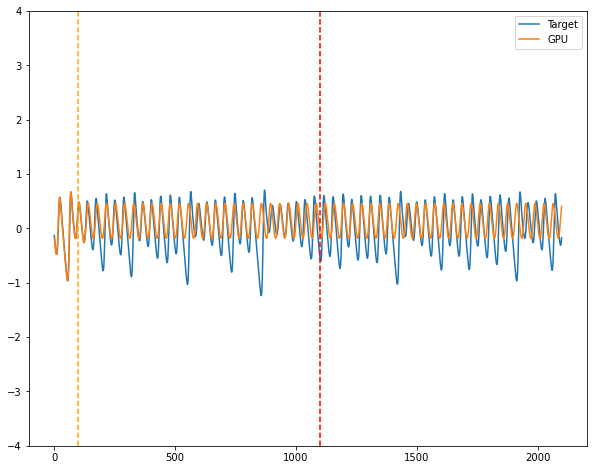

 Iter=8 a=0.943 sr=2.098 amp=1.000  ri=1.659 rr=1.889 loss=0.630466 nrmse=0.144915 CD 0.485551
Iter: 8 #### Time 4.10  NRMSE 0.145 CD 0.486
Iter: 9 #### Time 3.99  NRMSE 1000.000 CD nan
Iter: 10 #### Time 4.03  NRMSE 0.199 CD 0.983
Iter: 11 #### Time 4.01  NRMSE 0.225 CD 0.987
Iter: 12 #### Time 4.01  NRMSE 0.266 CD 1.132
Iter: 13 #### Time 3.98  NRMSE 0.223 CD 0.988
Iter: 14 #### Time 3.99  NRMSE 0.215 CD 0.918
Iter: 15 #### Time 4.01  NRMSE 0.222 CD 1.058
Iter: 16 #### Time 3.98  NRMSE 0.217 CD 0.736
Iter: 17 #### Time 3.98  NRMSE 1000.000 CD nan
Iter: 18 #### Time 3.98  NRMSE 0.198 CD 0.985
Iter: 19 #### Time 3.97  NRMSE 0.202 CD 0.698
Iter: 20 #### Time 4.00  NRMSE 1000.000 CD 1.008
Iter: 21 #### Time 4.06  NRMSE 0.486 CD 1.013
Iter: 22 #### Time 4.05  NRMSE 0.256 CD 0.989
Iter: 23 #### Time 3.96  NRMSE 0.200 CD 0.902
Iter: 24 #### Time 4.02  NRMSE 0.197 CD 0.980
Iter: 25 #### Time 4.04  NRMSE 0.233 CD 1.021
Iter: 26 #### Time 4.01  NRMSE 1000.000 CD nan
Iter: 27 #### Time 4.02  NR

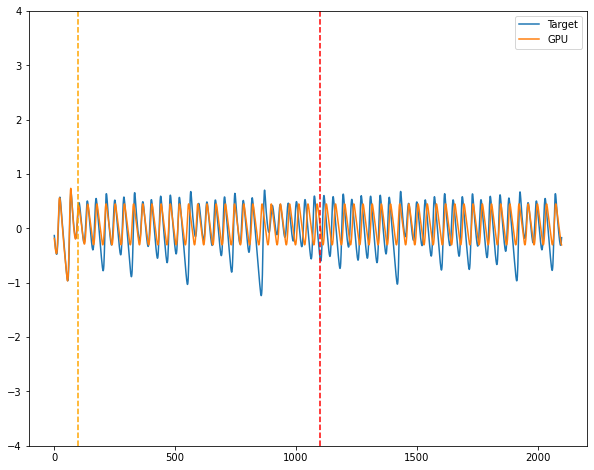

 Iter=98 a=0.914 sr=2.063 amp=1.000  ri=2.104 rr=3.750 loss=0.605841 nrmse=0.147980 CD 0.457861
Iter: 98 #### Time 4.14  NRMSE 0.148 CD 0.458
Iter: 99 #### Time 4.13  NRMSE 1000.000 CD nan
End Run 2 Time 403.829

Best result = 0.5867767557126036
a = 0.79190818896846
sr = 2.3799299535206004
amp = 1.1797443427292762
ri = 2.0365879592354332
********** Size12 ref 3 -- Run 3 ***********
Iter: 0 #### Time 4.10  NRMSE 1000.000 CD nan
Iter: 1 #### Time 4.00  NRMSE 0.218 CD 0.916
Iter: 2 #### Time 3.99  NRMSE 0.228 CD 1.099
Iter: 3 #### Time 3.99  NRMSE 0.201 CD 0.991
Iter: 4 #### Time 3.97  NRMSE 0.202 CD 0.973
Iter: 5 #### Time 4.03  NRMSE 0.193 CD 0.915
Iter: 6 #### Time 3.98  NRMSE 0.245 CD 1.113
Iter: 7 #### Time 3.98  NRMSE 0.228 CD 0.656
Iter: 8 #### Time 3.99  NRMSE 0.189 CD 0.967
Iter: 9 #### Time 4.03  NRMSE 0.391 CD 0.924
Iter: 10 #### Time 4.01  NRMSE 0.243 CD 0.986
Iter: 11 #### Time 4.00  NRMSE 0.193 CD 0.967
Iter: 12 #### Time 4.01  NRMSE 0.217 CD 0.981
Iter: 13 #### Time 3.99  N

Iter: 63 #### Time 4.15  NRMSE 1000.000 CD nan
Iter: 64 #### Time 4.05  NRMSE 1000.000 CD nan
Iter: 65 #### Time 4.00  NRMSE 1000.000 CD nan
Iter: 66 #### Time 4.10  NRMSE 0.151 CD 0.454
Iter: 67 #### Time 4.05  NRMSE 0.189 CD 0.963
Iter: 68 #### Time 4.02  NRMSE 0.218 CD 0.892
Iter: 69 #### Time 4.05  NRMSE 1000.000 CD 0.997
Iter: 70 #### Time 4.03  NRMSE 1000.000 CD nan
Iter: 71 #### Time 4.03  NRMSE 2.650 CD 1.051
Iter: 72 #### Time 4.04  NRMSE 0.198 CD 0.981
Iter: 73 #### Time 4.02  NRMSE 0.197 CD 0.988
Iter: 74 #### Time 4.09  NRMSE 0.205 CD 0.989
Iter: 75 #### Time 4.02  NRMSE 0.189 CD 0.979
Iter: 76 #### Time 4.07  NRMSE 0.310 CD 0.993
Iter: 77 #### Time 4.07  NRMSE 1000.000 CD nan
Iter: 78 #### Time 4.03  NRMSE 197140620105982500285072936009728.000 CD 1.002
Iter: 79 #### Time 4.05  NRMSE 0.236 CD 0.991
Iter: 80 #### Time 4.01  NRMSE 0.200 CD 0.913
Iter: 81 #### Time 4.05  NRMSE 0.201 CD 0.978
Iter: 82 #### Time 4.06  NRMSE 29230025.758 CD 0.995
Iter: 83 #### Time 4.04  NRMSE 0.

Iter: 20 #### Time 4.03  NRMSE 1000.000 CD 1.004
Iter: 21 #### Time 3.99  NRMSE 0.254 CD 0.980
Iter: 22 #### Time 4.02  NRMSE 1000.000 CD nan
Iter: 23 #### Time 4.03  NRMSE 0.184 CD 0.867
Iter: 24 #### Time 4.06  NRMSE 1000.000 CD nan
Iter: 25 #### Time 4.03  NRMSE 0.219 CD 0.673
Iter: 26 #### Time 4.02  NRMSE 4.541 CD 1.011
Iter: 27 #### Time 4.02  NRMSE 1000.000 CD nan
Iter: 28 #### Time 4.02  NRMSE 0.182 CD 0.957
Iter: 29 #### Time 4.06  NRMSE 0.187 CD 0.980
Iter: 30 #### Time 4.05  NRMSE 0.197 CD 0.982
Iter: 31 #### Time 4.06  NRMSE 0.211 CD 0.981
Iter: 32 #### Time 4.00  NRMSE 0.498 CD 0.991
Iter: 33 #### Time 4.03  NRMSE 85823.539 CD 1.009
Iter: 34 #### Time 4.01  NRMSE 0.490 CD 1.020
Iter: 35 #### Time 4.04  NRMSE 0.310 CD 0.935
Iter: 36 #### Time 4.04  NRMSE 0.205 CD 0.982
Iter: 37 #### Time 4.03  NRMSE 0.185 CD 0.959
Iter: 38 #### Time 4.03  NRMSE 1000.000 CD nan
Iter: 39 #### Time 4.01  NRMSE 1000.000 CD nan
Iter: 40 #### Time 4.02  NRMSE 1000.000 CD nan
Iter: 41 #### Time 4.

Iter: 92 #### Time 4.02  NRMSE 1000.000 CD nan
Iter: 93 #### Time 4.00  NRMSE 1000.000 CD nan
Iter: 94 #### Time 3.99  NRMSE 1000.000 CD nan
Iter: 95 #### Time 4.03  NRMSE 1000.000 CD nan
Iter: 96 #### Time 4.01  NRMSE 0.252 CD 1.238
Iter: 97 #### Time 4.00  NRMSE 0.183 CD 0.833
Iter: 98 #### Time 3.97  NRMSE 0.195 CD 0.975
Iter: 99 #### Time 3.98  NRMSE 1000.000 CD nan
End Run 2 Time 403.447

Best result = 0.601835002929261
a = 0.8020997415038438
sr = 1.7869249341058442
amp = 2.1124207227585208
ri = 0.49731475218463983
********** Size12 ref 4 -- Run 3 ***********
Iter: 0 #### Time 3.99  NRMSE 0.201 CD 0.978
Iter: 1 #### Time 3.98  NRMSE 0.189 CD 0.807
Iter: 2 #### Time 4.06  NRMSE 1000.000 CD nan
Iter: 3 #### Time 4.02  NRMSE 0.216 CD 0.989
Iter: 4 #### Time 3.99  NRMSE 1000.000 CD nan
Iter: 5 #### Time 4.04  NRMSE 0.188 CD 0.966
Iter: 6 #### Time 4.06  NRMSE 0.191 CD 0.982
Iter: 7 #### Time 4.05  NRMSE 0.207 CD 0.794
Iter: 8 #### Time 4.05  NRMSE 0.179 CD 0.910
Iter: 9 #### Time 4.02

Iter: 60 #### Time 4.15  NRMSE 0.263 CD 0.906
Iter: 61 #### Time 4.02  NRMSE 1000.000 CD nan
Iter: 62 #### Time 4.01  NRMSE 8.716 CD 1.001
Iter: 63 #### Time 4.02  NRMSE 0.193 CD 0.942
Iter: 64 #### Time 4.01  NRMSE 0.206 CD 0.964
Iter: 65 #### Time 4.16  NRMSE 0.221 CD 1.040
Iter: 66 #### Time 4.04  NRMSE 1000.000 CD nan
Iter: 67 #### Time 4.05  NRMSE 1000.000 CD nan
Iter: 68 #### Time 4.04  NRMSE 1000.000 CD 1.000
Iter: 69 #### Time 4.05  NRMSE 0.198 CD 0.823
Iter: 70 #### Time 4.00  NRMSE 0.183 CD 0.864
Iter: 71 #### Time 4.01  NRMSE 1000.000 CD nan
Iter: 72 #### Time 4.00  NRMSE 0.184 CD 0.896
Iter: 73 #### Time 4.01  NRMSE 0.179 CD 0.901
Iter: 74 #### Time 4.07  NRMSE 0.230 CD 1.158
Iter: 75 #### Time 4.07  NRMSE 0.201 CD 0.980
Iter: 76 #### Time 3.97  NRMSE 0.216 CD 0.977
Iter: 77 #### Time 4.03  NRMSE 1000.000 CD nan
Iter: 78 #### Time 4.02  NRMSE 1000.000 CD 1.001
Iter: 79 #### Time 4.02  NRMSE 0.245 CD 0.990
Iter: 80 #### Time 4.03  NRMSE 0.227 CD 0.953
Iter: 81 #### Time 4.04

In [6]:
CALLS = 100
s = torch.torch.from_numpy(signal).cuda(DEVICE).type(dtype)
# Skipped 1000
#size = [300,50,40,30,20,10]
size = [28,26,24,22,20,18,16,14,12]
rand_state = [11,37,3,24,91]

dict_counters = {}
dict_model = {}
for N in size:
    model_counter = 0
    error_per_N = []
    best_N_model = [N,0,0,0]
    
    min_a, max_a = .7, 1.
    min_sr, max_sr = 1.5, 3.
    min_g, max_g = .001, 2.
    min_ri, max_ri = .3, 3.5
    min_rr, max_rr = .4, 4.
    space = [Real(min_a, max_a, name='a'),
             Real(min_sr, max_sr, name='sr'),
             Real(min_ri, max_ri, name='ri'),
             Real(min_rr, max_rr, name='rr')
            ]
    error_over_N = 1000
    for ref in range(5):
        
        alphas = []
        rhos = []
        gammas = []
        inScales = []
        resScales = []
        
        for rn in range(5):
            start = time.time()
            running_error = 1000
            counter = 0 
            print(f'********** Size{N} ref {ref} -- Run {rn} ***********')
            result_gp = gp_minimize(loop,
                                    space,
                                    n_calls=CALLS,
                                    random_state=rand_state[rn],
                                    n_jobs=4,
                                    n_initial_points=100)
            end = time.time()-start
            print(f'End Run {rn} Time {end:.3f}')
            print(f'\nBest result = {result_gp.fun}')
            names = ['a','sr','amp','ri','rr']
            for i in range(len(space)):
                print(f'{names[i]} = {result_gp.x[i]}')
            
        min_a, max_a   = resize_spaces(min_a, max_a,
                                       np.array(alphas),
                                       isAlpha=True)
        min_sr, max_sr = resize_spaces(min_sr, max_sr, np.array(rhos))
        min_g, max_g   = resize_spaces(min_g, max_g, np.array(gammas))
        min_ri, max_ri = resize_spaces(min_ri, max_ri, np.array(inScales))
        min_rr, max_rr = resize_spaces(min_rr, max_rr, np.array(resScales))
        print('Refined search bounds:\n')
        print(f'Alpha ({min_a}, {max_a})\n')
        print(f'Rho ({min_sr}, {max_sr})\n')
        print(f'Gamma ({min_g}, {max_g})\n')
        print(f'r-in ({min_ri}, {max_ri})\n')
        print(f'r-res ({min_rr}, {max_rr})\n')
        
        
    print(f'Overall best model {best_N_model}')
    dict_counters[str(N)] = {'numModels': model_counter,
                             'meanError': np.mean(np.array(error_per_N)).tolist(),
                             'varError' : np.var(np.array(error_per_N)).tolist()}
    with open('Dicts/diag_Lz_sm.json', 'w') as fp:
        json.dump(dict_counters, fp, cls=NumpyArrayEncoder)
    with open('Dicts/models_Lz_sm.json', 'w') as fp:
        json.dump(dict_model, fp, cls=NumpyArrayEncoder)
print(dict_counters)

### Analysis

In [5]:
fontsize = 24
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["text.usetex"] = True 
plt.rcParams["axes.xmargin"] = 0 
plt.rcParams["axes.titlesize"] = fontsize 
plt.rcParams["axes.labelsize"] = fontsize
plt.rcParams["xtick.labelsize"] = fontsize
plt.rcParams["ytick.labelsize"] = fontsize
plt.rcParams["axes.labelsize"] = fontsize
plt.rcParams["font.weight"] = "heavy"
plt.rcParams["axes.labelweight"] = "heavy"

In [ ]:
fpath = 'Dicts/diag_Lz.json'
with open(fpath,'r') as j:
    dict_diag = json.loads(j.read())

fpath = 'Dicts/models_Lz.json'
with open(fpath,'r') as j:
    dict_models = json.loads(j.read())

In [18]:
dict_diag.keys()

dict_keys(['300', '50', '40', '30', '20', '10', '28', '26', '24', '22', '18', '16', '14', '12'])

N=300   Error = 0.005882 Div = 0.054
N=50   Error = 0.005964 Div = 0.194
N=40   Error = 0.007311 Div = 0.091
N=30   Error = 0.007258 Div = 0.106
N=20   Error = 0.006994 Div = 0.387
N=10   Error = 0.007237 Div = 0.317
N=28   Error = 0.007227 Div = 0.045
N=26   Error = 0.007211 Div = 1.291
N=24   Error = 0.007110 Div = 0.386
N=22   Error = 0.006907 Div = 1.489
N=18   Error = 0.007217 Div = 0.299
N=16   Error = 0.007134 Div = 0.100
N=12   Error = 0.007113 Div = 1.292


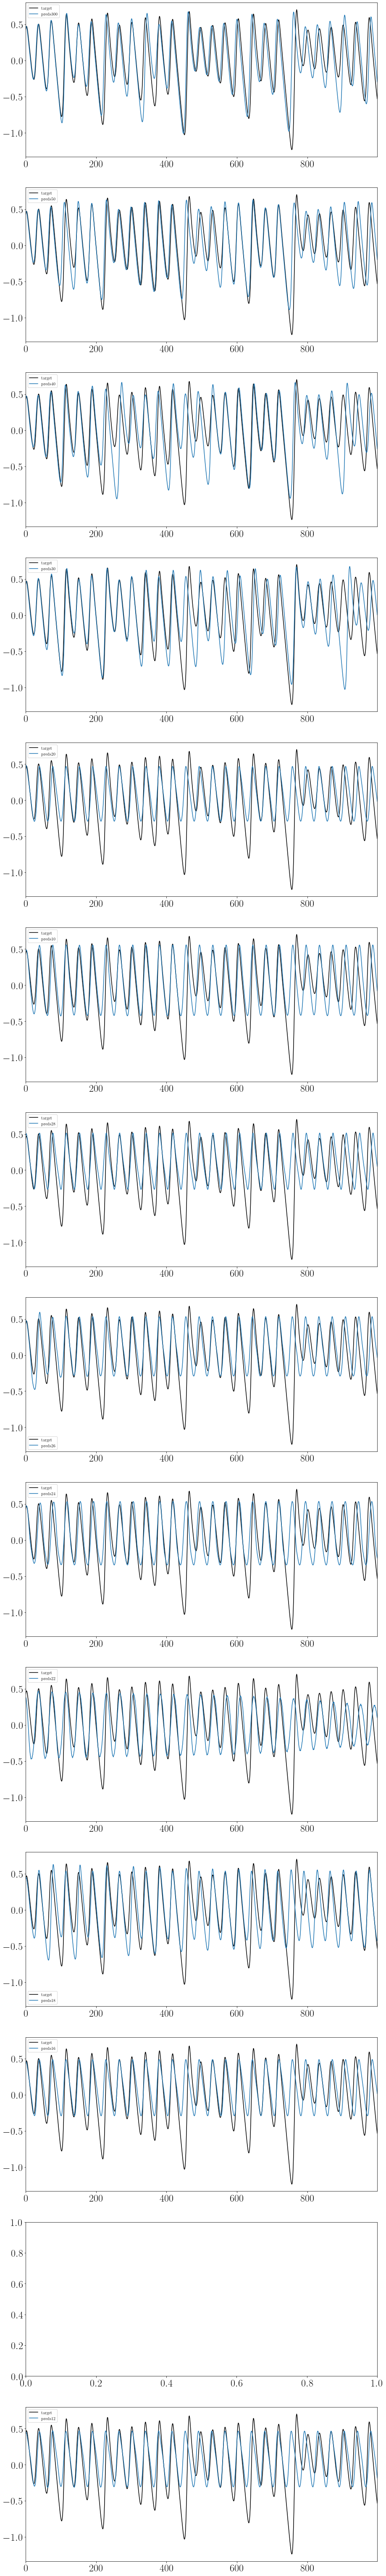

In [29]:
size = [300, 50, 40, 30, 20, 10, 28, 26, 24, 22, 18, 16, 14, 12]
Nplots = len(size)
fig, axs = plt.subplots(Nplots, figsize=(15,8*Nplots)) 

for i in range(len(size)):
    if(dict_diag[str(size[i])]['numModels']==0):
        continue
    axs[i].plot(signal[TRAINLENGTH:TRAINLENGTH + TEST], color='k', label='target')
    preds = dict_models[str(size[i])]['Preds']
    error_testset = rca.NRMSE(signal[TRAINLENGTH:TRAINLENGTH + TEST],
                              preds[TRAINLENGTH:TRAINLENGTH + TEST],
                              MINMAX)
    kl,_,_,_ = rca.distribution(signal[TRAINLENGTH:TRAINLENGTH + TEST],
                                preds[TRAINLENGTH:TRAINLENGTH + TEST],
                                 np.min(signal[:TRAINLENGTH+TEST]),
                                 np.max(signal[:TRAINLENGTH+TEST]),
                                 bins=50)
    print(f'N={size[i]}   Error = {error_testset:3f} Div = {kl:.3f}')
    axs[i].plot(preds[TRAINLENGTH:TRAINLENGTH + TEST], label=f'preds{size[i]}')
    axs[i].legend()
plt.show()

### Get Ranks

Alpha 0.8872706721376742 --- Gamma 1.0
Ave rank for N=300 is 20 Tolerance 1e-14 Rho A 1.65
Alpha 0.9804581386469675 --- Gamma 1.0
Ave rank for N=50 is 38 Tolerance 1e-16 Rho A 1.616
Alpha 0.7224174732267955 --- Gamma 1.0
Ave rank for N=40 is 13 Tolerance 1e-08 Rho A 1.714
Alpha 0.941839904009472 --- Gamma 1.0
Ave rank for N=30 is 10 Tolerance 1e-05 Rho A 1.724
Alpha 0.9232817649169263 --- Gamma 1.0
Ave rank for N=20 is 6 Tolerance 0.001 Rho A 1.722
Alpha 0.9480810455960621 --- Gamma 1.0
Ave rank for N=10 is 5 Tolerance 0.01 Rho A 1.869
Alpha 0.785022211147712 --- Gamma 1.0
Ave rank for N=28 is 14 Tolerance 1e-09 Rho A 2.351
Alpha 0.7317224490178691 --- Gamma 1.0
Ave rank for N=26 is 10 Tolerance 1e-07 Rho A 2.151
Alpha 0.9957869304045996 --- Gamma 1.0
Ave rank for N=24 is 7 Tolerance 0.0001 Rho A 1.671
Alpha 0.9713164770258284 --- Gamma 1.0
Ave rank for N=22 is 10 Tolerance 0.001 Rho A 1.457
Alpha 0.7596416916440414 --- Gamma 1.0
Ave rank for N=18 is 5 Tolerance 0.1 Rho A 1.574
Alpha 0

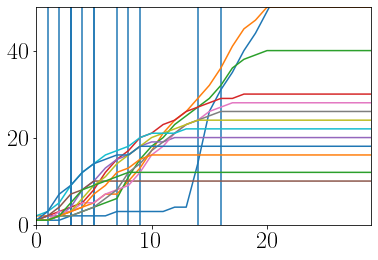

In [32]:
from scipy.optimize import fsolve
def rank_curve(cplus, tols):
    rank_tols = []
    for i in tols:
        rank_tols.append(rca.rank(cplus, i))
    return np.array(rank_tols)

K = 1
L = 1
tols = [1/10**x for x in range(0,30)]
plt.figure()
for i in range(Nplots):
    n = size[i]
    if(dict_diag[str(size[i])]['numModels']==0):
        continue
    mat = np.array(dict_models[str(n)]['Wnet'])
    Wr, Wi = rca.get_mats(None, K,n, matrix=mat)
    # params [alpha, spectralradius, gamma, ri, rr, loss]
    p = dict_models[str(n)]['Params']
    a,g = p[0], p[2]
    print(f'Alpha {a} --- Gamma {g}')
    x0 = np.zeros((n,1))
    u0 = np.zeros((K,1))
    A = rca.leaky_jacobian(x0, u0, a, g, Wi, Wr)
    B = rca.partial_u(x0, u0, a, g, Wi, Wr)
    rhoA = np.max(np.abs(rca.eig_spectrum(A)))
    Cn = np.nan_to_num(rca.reachable_matrix(A,B))
    if(K != 3): # Square Cn
        Cn = Cn/np.max(np.abs(rca.eig_spectrum(Cn)))
    else:            # Non-square Cn
        Cn = Cn/np.max(np.abs(np.linalg.svd(Cn, compute_uv=False)))

    rkc = rank_curve(Cn, tols)
    v = np.argmax(np.gradient(rkc))
    plt.plot(rkc, label=f'N={n}')
    plt.vlines([v],0,50)
    ave_rank = (rkc[v]+rkc[v+1])//2
    print(f'Ave rank for N={n} is {ave_rank} Tolerance {tols[v]} Rho A {rhoA.round(3)}')
plt.ylim(0,50)
plt.show()

### Get divergence

k-size=30 Trainingset min=0.962  threshold=0.914  Location=308


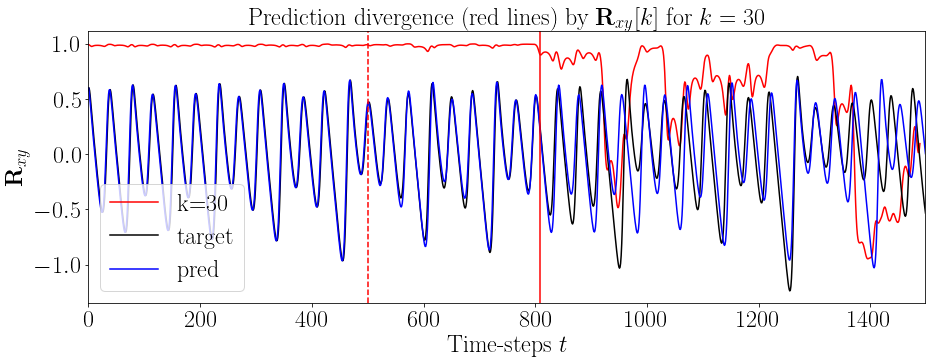

In [10]:
def Rxy(x,y):
    return np.dot(x.T,y)/(np.linalg.norm(x)*np.linalg.norm(y))

thresh = []
start = TRAINLENGTH - 1000
stop = M+FREERUN
k_list = [30]
plt.figure(figsize=(15,5))
for k in k_list:
    lengthTC = (stop-start)-k
    trainCorr = np.zeros(lengthTC) # 21000-k
    pred = np.array(dict_models[str(k)]['Preds'])
    for j in range(start,stop-k):
        tar = signal[j:j+k].reshape((k,1))
        prd = pred[j:j+k].reshape((k,1))
        trainCorr[j-start] = Rxy(tar,prd)
    minVal = trainCorr[:1000].min()
    threshold = minVal*.95
    thresholdLoc = np.where(trainCorr[1000:]<threshold)[0][0]
    thresh.append(thresholdLoc)
    print(f'k-size={k} Trainingset min={minVal.round(3)}  threshold={threshold:.3f}',
          f' Location={thresholdLoc}')
    plt.plot(trainCorr[500:2000], color='r', label=f'k={k}')
plt.plot(signal[TRAINLENGTH-500:TRAINLENGTH+TEST], color='k', label='target')
plt.plot(pred[TRAINLENGTH-500:TRAINLENGTH+TEST],color='b', label='pred')
plt.axvline(500+thresholdLoc,color='r')
plt.axvline(500,color='r',linestyle='dashed')
plt.ylabel('$\mathbf{R}_{xy}$')
plt.xlabel('Time-steps $t$')
plt.legend(fontsize=24,loc='lower left')
plt.title('Prediction divergence (red lines) by $\mathbf{R}_{xy}[k]$ for $k=30$')
plt.show()

### Chaos plot

In [ ]:
import seaborn as sns
import pandas as pd
def rank_along_trajectory(wr, wi, a, g, forcing, n, k, tolerance, delX):
    T = forcing.shape[0]
    ranks = np.zeros(T)
    conds = np.zeros(T)
    radii = np.zeros(T)
    uncertainty = np.zeros((n,T))
    def Func(x):
        return np.squeeze(-x.reshape(n,1) + (1-a)*x.reshape(n,1) +\
                          a*g*np.tanh(np.dot(wr,x.reshape(n,1)) +\
                         (np.dot(wi,ueq.reshape(k,1)).reshape(n,1))))
    for i in range(T):
        ueq = forcing[i]
        x0 = np.ones((n,1))*.5
        xeq = (fsolve(Func,x0)).reshape(n,1)
        A = rca.leaky_jacobian(xeq, ueq.reshape(k,1), a, g, Wi, Wr)
        radii[i] = np.max(np.abs(rca.eig_spectrum(A)))
        conds[i] = rca.condition_number(A)[0]
        B = rca.partial_u(xeq, ueq.reshape(k,1), a, g, Wi, Wr)
        uncertainty[:,i] = np.squeeze(np.dot(A,delX))
        Cplus = rca.controllability_matrix(A, B)
        ranks[i] = rca.rank(Cplus, tolerance)
        print(f'Time-step: {i} Rank: {ranks[i]} Uncertainty: {np.linalg.norm(uncertainty):.2f}  CondNum: {conds[i]:.2f}')
    return ranks, uncertainty, conds, radii




n=30
pred = np.array(dict_models[str(n)]['Preds'])
data_dict = {'y': signal[14000:],
             'yh': np.squeeze(pred[14000:]),
            }
alpha = .5
bins = 50
df = pd.DataFrame(data=data_dict)
fig= plt.figure(figsize=(10,14))
ax1 = plt.subplot(211)
sns.distplot(df['y'],
             label='$MG$',
             bins=bins,
             color='k',
             axlabel=False,
             norm_hist=True,
             hist_kws=dict(alpha=alpha))
sns.distplot(df['yh'],
             label='$\widehat{\mathbf{y}},\,N=30$',
             bins=bins,
             color='b',
             axlabel=False,
             norm_hist=True,
             hist_kws=dict(alpha=alpha))
plt.legend(loc='upper left', fontsize=fontsize)
plt.ylabel(r'${P}(u_t)$', fontsize=26,  color='black', weight='heavy')
plt.xlabel(r'Range of $u_t$', fontsize=26,  color='black', weight='heavy')
plt.xticks(c='black', fontsize=fontsize)
plt.yticks(c='black', fontsize=fontsize)
ax1.text(-0.2, 1.,s='$(\mathbf{a})$', transform=ax1.transAxes, 
            size=30, weight='bold')

ax2 = plt.subplot(212)
plt.rcParams['xtick.major.pad']='8'
ax2.text(-0.2, 1.,s='$(\mathbf{b})$', transform=ax2.transAxes, 
            size=30, weight='bold')
ax2.plot(signal[TRAINLENGTH-100:TRAINLENGTH+TEST],'k', label=r'$MG$')
ax2.plot(pred[TRAINLENGTH-100:TRAINLENGTH+TEST],'b-', label='$\widehat{\mathbf{y}},\,N=30$')
ax2.axvline(100, c='k',ls='dashed' )
ax2.axvline(100+thresholdLoc, c='r',ls='dashed' )
ax2.legend(loc='lower right',fontsize=20)
ax2.set_xticks([0,100,200,300,400])
ax2.set_xticklabels([-100,0,100,200,300])
ax2.set_xlabel('Test Data Time-steps '+'($t$)', fontsize=26, color='black', weight='heavy')
ax2.set_ylabel(r'${u_{t+1} - \mu}$', fontsize=26, color='black', weight='heavy')

plt.show()

In [16]:
fpath = 'Dicts/diag_Lz_sm.json'
with open(fpath,'r') as j:
    dict_diag_sm = json.loads(j.read())

dict_diag = {**dict_diag, ** dict_diag_sm}

fpath = 'Dicts/models_Lz_sm.json'
with open(fpath,'r') as j:
    dict_models_sm = json.loads(j.read())

dict_models = {**dict_models, ** dict_models_sm}